# This file is used to analyze real experiment data collected in December of 2022



## This file focuses on producing within-subject graphs, in response to the referees' reports received in June, 2023

## Created on Oct 30, 2023




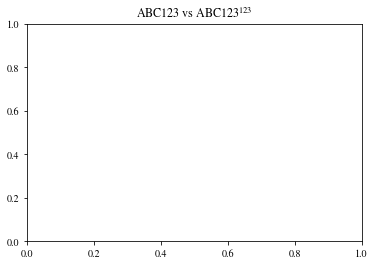

In [1]:
import pandas as pd
import numpy as np
import sys
import copy

import matplotlib.pyplot as plt
%matplotlib inline
# To change the default font like latex font
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

import itertools
import scipy.stats as stats

In [21]:
def countCommas(s):
    try:
        return s.count(',')
    except:
        return np.nan
    
def bootstrap_ci(data, n_samples, stat):
    
    n = len(data)                                #get length of the data
    ix = np.random.randint(0, n, (n_samples, n)) #get an array of bootsrapped indices
    samples = data[ix]                           #create bootrapped samples
    
    distribution = stat(samples, axis=1)

    return np.percentile(distribution,5),np.percentile(distribution,95)

In [22]:
def CreateMean_CI_byHypothese(data, var, treatment_var, treatment_list, totalR):
    all_data = data
    # Create a matrix for 3 outputs: mean, upper CI, lower CI
    # The size is #Rounds * #Treatments
    output = np.empty((3, totalR, len(treatment_list)))
    output[:]=np.nan
    
    for i,t in enumerate(treatment_list): # Fixed the treatment order
        for r in range(1,totalR+1):
            pop_a = all_data.loc[(all_data[treatment_var]==t) & (all_data['subsession.period']==r), var]

            if not pop_a.empty :
                output[0,r-1,i] = pop_a.mean()
                output[1,r-1,i],output[2,r-1,i] = bootstrap_ci(np.array(pop_a), 10000, np.mean)
            else : 
                pass
    return output

# Content

- [Data Import](#Data-Import)
- [Define functions and important variables](#Define-functions-and-important-variables)
- [Start Data Analysis](#Start-Data-Analysis)


# Data Import

-[Return](#Content)

In [3]:
data_ABA= pd.read_csv('..\\ProcessedData\\data_ABA.csv')
data_BAB=pd.read_csv('..\\ProcessedData\\data_BAB.csv')

In [4]:
# Data with opportunity 
data_Oppor_B1 = pd.read_csv('..\\ProcessedData\\data_Oppor_B1.csv')
data_Oppor_allB = pd.read_csv('..\\ProcessedData\\data_Oppor_allB.csv')

In [5]:
# Data local only 
data_noOppor_AllA = pd.read_csv('..\\ProcessedData\\data_noOppor_AllA.csv')
data_noOppor_A2=pd.read_csv('..\\ProcessedData\\data_noOppor_A2.csv')

In [6]:
# Data smaple
## Main: All 5 supergames, focusing on first 10 rounds
## Robustness check: all rounds; only first 4 supergames
## 	Order effect: checking sequence 

doFile_name = "01-group-data-Dec-2022-within-subject-focus-colored"

sample_name = "-all5-" #"first4"



In [7]:
# Environment local only
# Data local only 
data_noOppor = data_noOppor_AllA
data_noOppor['End_level'] = "High (30)"
data_noOppor.loc[data_noOppor['endowment']==10,'End_level'] = "Low (10)"
data_noOppor.loc[data_noOppor['endowment']==20,'End_level'] = "Homo (20)"
data_noOppor['tot_cont_share'] = data_noOppor['tot_contr'] / data_noOppor['endowment'] * 100
data_noOppor['T_endw_comp']= data_noOppor['Treatment'] + ', ' + data_noOppor['End_level']
data_noOppor

subsession.round_number  subsession.period  subsession.sg  \
0                           1                  1              1   
1                           1                  1              1   
2                           1                  1              1   
3                           1                  1              1   
4                           1                  1              1   
...                       ...                ...            ...   
3195                       20                 20              1   
3196                       20                 20              1   
3197                       20                 20              1   
3198                       20                 20              1   
3199                       20                 20              1   

      player.id_in_group  player.endowment  player.join_club  \
0                      1             300.0                 0   
1                      5             300.0                 0   
2                      2             300.0                 0   
3                      6             300.0                 0   
4                      3             100.0                 0   
...                  ...               ...               ...   
3195                   6             200.0                 0   
3196                   3             200.0                 0   
3197                   7             200.0                 0   
3198                   4             200.0                 0   
3199                   8             200.0                 0   

      player.local_community  player.id_in_local  player.contribution_local  \
0                          1                   0                       10.0   
1                          2                   0                       10.0   
2                          1                   1                       10.0   
3                          2                   1                        0.0   
4                          1                   2                        4.0   
...                      ...                 ...                        ...   
3195                       0                   1                       20.0   
3196                       3                   2                        0.0   
3197                       0                   2                        1.0   
3198                       3                   3                        7.0   
3199                       0                   3                        0.0   

      player.contribution_global  ...  endowment_nj  tot_contr  privateAcc  \
0                            0.0  ...         300.0       10.0        20.0   
1                            0.0  ...         300.0       10.0        20.0   
2                            0.0  ...         300.0       10.0        20.0   
3                            0.0  ...         300.0        0.0        30.0   
4                            0.0  ...         100.0        4.0         6.0   
...                          ...  ...           ...        ...         ...   
3195                         0.0  ...         200.0       20.0         0.0   
3196                         0.0  ...         200.0        0.0        20.0   
3197                         0.0  ...         200.0        1.0        19.0   
3198                         0.0  ...         200.0        7.0        13.0   
3199                         0.0  ...         200.0        0.0        20.0   

      player.payoff_globalagg  player.endowment_globalagg  Efficiency  \
0                       230.0                      1600.0    0.598958   
1                       230.0                      1600.0    0.598958   
2                       230.0                      1600.0    0.598958   
3                       230.0                      1600.0    0.598958   
4                       230.0                      1600.0    0.598958   
...                       ...                         ...         ...   
3195                    207.6      

In [8]:
# Environment local + global 
data_Oppor = data_Oppor_allB
data_Oppor['End_level'] = "Homo (20)" 
data_Oppor.loc[data_Oppor['endowment']<=10,'End_level'] = "Low (10)"
data_Oppor.loc[data_Oppor['endowment']>20,'End_level'] = "High (30)"
data_Oppor['tot_cont_share'] = data_Oppor['tot_contr'] / data_Oppor['endowment'] * 100
data_Oppor['T_endw_comp']= data_Oppor['Treatment'] + ', ' + data_Oppor['End_level']
data_Oppor['local_share'] = data_Oppor['player.contribution_local']/ data_Oppor['endowment'] * 100
data_Oppor['global_share'] = data_Oppor['player.contribution_global']/ data_Oppor['endowment'] * 100

data_Oppor

subsession.round_number  subsession.period  subsession.sg  \
0                           1                  1              1   
1                           1                  1              1   
2                           1                  1              1   
3                           1                  1              1   
4                           1                  1              1   
...                       ...                ...            ...   
7035                       10                 10              1   
7036                       10                 10              1   
7037                       10                 10              1   
7038                       10                 10              1   
7039                       10                 10              1   

      player.id_in_group  player.endowment  player.join_club  \
0                      1             280.0                 1   
1                      5             280.0                 1   
2                      2             300.0                 0   
3                      6             280.0                 1   
4                      3              80.0                 1   
...                  ...               ...               ...   
7035                   6             180.0                 1   
7036                   3             180.0                 1   
7037                   7             180.0                 1   
7038                   4             180.0                 1   
7039                   8             180.0                 1   

      player.local_community  player.id_in_local  player.contribution_local  \
0                          1                   0                        8.0   
1                          2                   0                        5.0   
2                          1                   1                       10.0   
3                          2                   1                        6.0   
4                          1                   2                        3.0   
...                      ...                 ...                        ...   
7035                       0                   1                        0.0   
7036                       3                   2                        0.0   
7037                       0                   2                        0.0   
7038                       3                   3                        2.0   
7039                       0                   3                        0.0   

      player.contribution_global  ...  LocalTotal  ClubSize  SocialBenefitMax  \
0                            8.0  ...       300.0         7            5592.0   
1                            5.0  ...       300.0         7            5592.0   
2                            0.0  ...       300.0         7            5592.0   
3                            6.0  ...       300.0         7            5592.0   
4                            5.0  ...       300.0         7            5592.0   
...                          ...  ...         ...       ...               ...   
7035                         0.0  ...         0.0         8            6912.0   
7036                         0.0  ...         0.0         8            6912.0   
7037                         3.0  ...         0.0         8            6912.0   
7038                         9.0  ...         0.0         8            6912.0   
7039                        18.0  ...         0.0         8            6912.0   

      Efficiency2  Sequence  End_level  tot_cont_share        T_endw_comp  \
0        0.568670        B1  High (30)       57.142857  HETERO, High (30)   
1        0.568670        B1  High (30)       35.714286  HETERO, High (30)   
2        0.568670        B1  High (30)       33.333333  HETERO, High (30)   
3        0.568670        B1  High (30)       42.857143  HETERO, High (30)   
4        0.568670        B1   Low (10)      100.000000   HETERO, Low (10)   
...           ...       ...        ...          

In [9]:
# Selecting colors
import seaborn as sns

palette_tab20 = sns.color_palette("tab20", 20)

In [10]:
data_Oppor.columns

Index(['subsession.round_number', 'subsession.period', 'subsession.sg',
       'player.id_in_group', 'player.endowment', 'player.join_club',
       'player.local_community', 'player.id_in_local',
       'player.contribution_local', 'player.contribution_global',
       'player.total_contribution_local', 'player.individual_share_local',
       'player.payoff', 'group.id_in_subsession', 'group.FC',
       'group.total_contribution_global', 'group.individual_share_global',
       'session.code', 'Treatment', 'FC', 'participant.code', 'endowment',
       'endowment_j', 'endowment_nj', 'tot_contr', 'privateAcc',
       'FC_globalagg', 'player.payoff_globalagg', 'player.endowment_globalagg',
       'Efficiency', 'player.payoff_globalMax', 'ClubTotal', 'LocalTotal',
       'ClubSize', 'SocialBenefitMax', 'Efficiency2', 'Sequence', 'End_level',
       'tot_cont_share', 'T_endw_comp', 'local_share', 'global_share'],
      dtype='object')

index 0 0 HOMO tot_contr
index 0 1 HOMO player.contribution_local
index 0 2 HOMO player.contribution_global
index 0 3 HOMO player.join_club
index 0 4 HOMO player.payoff
index 1 0 HETERO tot_contr
index 1 1 HETERO player.contribution_local
index 1 2 HETERO player.contribution_global
index 1 3 HETERO player.join_club
index 1 4 HETERO player.payoff
index 2 0 HOMO tot_contr
index 2 1 HOMO player.contribution_local
index 2 2 HOMO player.contribution_global
index 2 3 HOMO player.join_club
index 2 4 HOMO player.payoff
index 3 0 HETERO tot_contr
index 3 1 HETERO player.contribution_local
index 3 2 HETERO player.contribution_global
index 3 3 HETERO player.join_club
index 3 4 HETERO player.payoff
index 0 0 HOMO tot_contr
index 0 1 HOMO player.contribution_local
index 0 2 HOMO player.contribution_global
index 0 3 HOMO player.join_club
index 0 4 HOMO player.payoff
index 1 0 HETERO tot_contr
index 1 1 HETERO player.contribution_local
index 1 2 HETERO player.contribution_global
index 1 3 HETERO play

C:\Users\xinxi\AppData\Local\Temp/ipykernel_7900/3835496071.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.arange(0,101,20),fontsize=15)


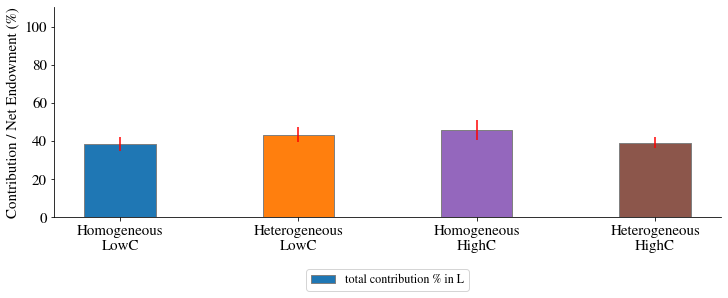

In [13]:
# % This is created to produce a bar graph for local public good contribution only, comparing L and L/G environments
# Only use percentage

treatment_list = ['HOMO','HETERO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_t = 'tot_contr'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_join = 'player.join_club'
var_payoffs = 'player.payoff'
var_of_interest =  [var_t, var_l, var_g, var_join,var_payoffs]
var_of_interest2 = [var_t,var_l, var_g, 'endowment',var_join,var_payoffs]
R_max = 10
sample_round = "first10" # "first1"; "allRounds";"first10"
ValorShare= "-Share-"

LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest2].sum().reset_index()


output = np.empty((4,len(var_of_interest), 3))
output[:]=np.nan



for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        if v==var_join or v==var_payoffs:
            pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                    (LocalGlobal['subsession.period']<=R_max)&
                                    (LocalGlobal['FC']==20), v] / 4
        else :     
            pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                    (LocalGlobal['subsession.period']<=R_max)&
                                    (LocalGlobal['FC']==20), v] / LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                    (LocalGlobal['subsession.period']<=R_max)&
                                    (LocalGlobal['FC']==20), 'endowment']
       
        print('index', i,j, t, v)
        output[i, j, 0]=pop_a.mean()
        output[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        if v==var_join or v==var_payoffs:
            pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                    (LocalGlobal['subsession.period']<=R_max)&
                                    (LocalGlobal['FC']==80), v]  / 4

        else :
            pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                    (LocalGlobal['subsession.period']<=R_max)&
                                    (LocalGlobal['FC']==80), v]  / LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                    (LocalGlobal['subsession.period']<=R_max)&
                                    (LocalGlobal['FC']==80), 'endowment']

        print('index', i+2, j, t,v)
        output[i+2,j, 0]=pop_a.mean()
        output[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        


LocalOnly = data_noOppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest2].sum().reset_index()


output_noC = np.empty((4,len(var_of_interest), 3))
output_noC[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        if v==var_join or v==var_payoffs:
            pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==20), v]  / 4
        else:
            pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                    (LocalOnly['subsession.period']<=R_max)&
                                    (LocalOnly['FC']==20), v]  / LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                    (LocalOnly['subsession.period']<=R_max)&
                                    (LocalOnly['FC']==20), 'endowment']

        print('index', i,j, t, v)
        output_noC[i, j, 0]=pop_a.mean()
        output_noC[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        if v==var_join or v==var_payoffs:
            pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==80), v]  / 4
        else :
            pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==80), v]  / LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==80), 'endowment']
       
        print('index', i+2, j, t,v)
        output_noC[i+2,j, 0]=pop_a.mean()
        output_noC[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        
var_of_interest = 'endowment'
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()
total_e = np.empty((2,2,3))
total_e[:]=np.nan

for i,t in enumerate(treatment_list): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]
    total_e[i,0,0] =pop_a.mean()
    total_e[i, 0, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
    
    pop_b = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]
    total_e[i,1,0] = np.mean(pop_b)
    total_e[i, 1, 1:3]=bootstrap_ci(np.array(pop_b), 10000, np.mean)  
#     print(i,t)


# ************************************************************************************************************************#

mainV = "-localC-"


labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']

# labels=  ['HOMO\nLowC', 'HETERO\nLowC', 'HOMO\nHighC', 'HETERO\nHighC']
labels_both = ["Local PG in L", "Local PG in L/G"]
colors = ['grey', 'white']
hatchs = ['', '/']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))



# No club
axes.bar([0,1], output_noC[[0,1],0, 0], 
             yerr=[output_noC[[0,1],0,0]-output_noC[[0,1],0,1], output_noC[[0,1],0,2]-output_noC[[0,1],0,0]],
         label='total contribution % in L',
         hatch=hatchs[0],
             color=[palette_tab20[0],palette_tab20[2]], width=.4, ecolor='red', edgecolor='gray')


# No club
axes.bar([2,3], output_noC[[2,3],0, 0], 
             yerr=[output_noC[[2,3],0,0]-output_noC[[2,3],0,1], output_noC[[2,3],0,2]-output_noC[[2,3],0,0]],
             hatch=hatchs[0],
             color=[palette_tab20[8],palette_tab20[10]] ,width=.4 ,ecolor='red', edgecolor='gray')



# axes.bar([3,4], total_e[[0,1],1, 0], 
#          yerr=[total_e[[0,1],1,0]-total_e[[0,1],1,1], total_e[[0,1],1,2]-total_e[[0,1],1,0]],
#           fill=False, label=labels2[2],
#         edgecolor = 'black')

axes.set_xticks(x)
axes.set_xticklabels(labels,fontsize=15)
axes.set_ylim(0,1.1)
axes.set_yticklabels(np.arange(0,101,20),fontsize=15)
axes.set_ylabel('Contribution / Net Endowment (%)',fontsize=15)
axes.tick_params(axis='y', labelsize=15)

lines, labels = axes.get_legend_handles_labels()
axes.legend( lines, labels, bbox_to_anchor=(.5,-.3), loc="center" , ncol=4,fontsize=12)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

print(doFile_name+sample_name+sample_round+mainV+ValorShare)
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+ValorShare+".pdf", bbox_inches="tight" )  

C:\Users\xinxi\AppData\Local\Temp/ipykernel_7900/1706216646.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.arange(0,101,20),fontsize=15)


01-group-data-Dec-2022-within-subject-focus-colored-all5-first10-localC--Share-


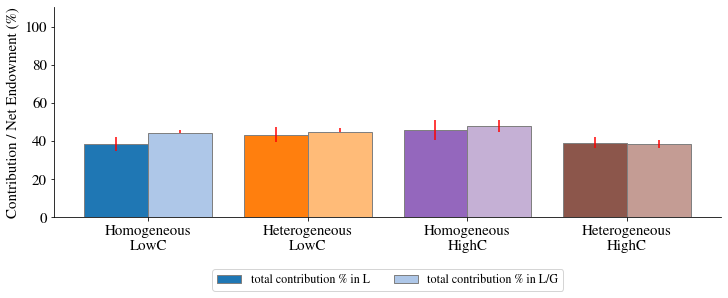

In [14]:
# ************************************************************************************************************************#

mainV = "-localC-"


labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
colors = ['grey', 'white']
hatchs = ['', '/']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))



# No club
axes.bar([-0.2,.8], output_noC[[0,1],0, 0], 
             yerr=[output_noC[[0,1],0,0]-output_noC[[0,1],0,1], output_noC[[0,1],0,2]-output_noC[[0,1],0,0]],
           label='total contribution % in L',
             color=[palette_tab20[0],palette_tab20[2]], width=.4, ecolor='red', edgecolor='gray')

# With club
axes.bar([0.2,1.2], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]- output[[0,1],0, 0], output[[0,1],0,2]- output[[0,1],0, 0]],
           label='total contribution % in L/G',
             color=[palette_tab20[1],palette_tab20[3]], width=.4, ecolor='red', edgecolor='gray') 
# No club
axes.bar([1.8,2.8], output_noC[[2,3],0, 0], 
             yerr=[output_noC[[2,3],0,0]-output_noC[[2,3],0,1], output_noC[[2,3],0,2]-output_noC[[2,3],0,0]],
             color=[palette_tab20[8],palette_tab20[10]] ,width=.4 ,ecolor='red', edgecolor='gray')
# With club
axes.bar([2.2,3.2], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
             color=[palette_tab20[9],palette_tab20[11]],width=.4, ecolor='red', edgecolor='gray' )


axes.set_xticks(x)
axes.set_xticklabels(labels,fontsize=15)
axes.set_ylim(0,1.1)
axes.set_yticklabels(np.arange(0,101,20),fontsize=15)
axes.set_ylabel('Contribution / Net Endowment (%)',fontsize=15)
axes.tick_params(axis='y', labelsize=15)

lines, labels = axes.get_legend_handles_labels()
axes.legend( lines, labels, bbox_to_anchor=(.5,-.3), loc="center" , ncol=4,fontsize=12)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

print(doFile_name+sample_name+sample_round+mainV+ValorShare)
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+ValorShare+"2.pdf", bbox_inches="tight" ) 

C:\Users\xinxi\AppData\Local\Temp/ipykernel_7900/1598302141.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.arange(0,101,20),fontsize=15)


01-group-data-Dec-2022-within-subject-focus-colored-all5-first10-localC--Share-


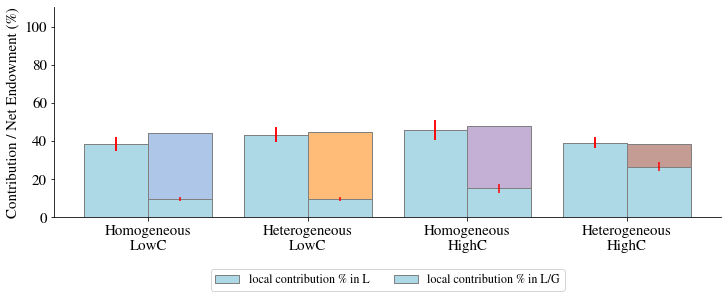

In [15]:
# ************************************************************************************************************************#

mainV = "-localC-"


labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
colors = ['grey', 'white']
hatchs = ['', '/']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))



# No club
axes.bar([-0.2,.8], output_noC[[0,1],0, 0], 
             yerr=[output_noC[[0,1],0,0]-output_noC[[0,1],0,1], output_noC[[0,1],0,2]-output_noC[[0,1],0,0]],
             color=[palette_tab20[0],palette_tab20[2]], width=.4, ecolor='red', edgecolor='gray')

# With club
axes.bar([0.2,1.2], output[[0,1],0, 0], 
             color=[palette_tab20[1],palette_tab20[3]], width=.4, ecolor='red', edgecolor='gray') 
# No club
axes.bar([1.8,2.8], output_noC[[2,3],0, 0], 
             yerr=[output_noC[[2,3],0,0]-output_noC[[2,3],0,1], output_noC[[2,3],0,2]-output_noC[[2,3],0,0]],
                 color=[palette_tab20[8],palette_tab20[10]] ,width=.4 ,ecolor='red', edgecolor='gray')
# With club
axes.bar([2.2,3.2], output[[2,3],0, 0], 
             color=[palette_tab20[9],palette_tab20[11]],width=.4, ecolor='red', edgecolor='gray' )

############# Point out local contribution 
# No club
axes.bar([-.2,.8], output_noC[[0,1],0, 0], 
             yerr=[output_noC[[0,1],0,0]-output_noC[[0,1],0,1], output_noC[[0,1],0,2]-output_noC[[0,1],0,0]],
          label='local contribution % in L',
             color = 'lightblue', width=.4, ecolor='red', edgecolor='gray')
# With club
axes.bar([0.2,1.2], output[[0,1],1, 0], 
             yerr=[output[[0,1],1,0]-output[[0,1],1,1], output[[0,1],1,2]-output[[0,1],1,0]],
          label='local contribution % in L/G',
             color = 'lightblue', width=.4, ecolor='red', edgecolor='gray')


# No club
axes.bar([1.8, 2.8], output_noC[[2,3],0, 0], 
             yerr=[output_noC[[2,3],0,0]-output_noC[[2,3],0,1], output_noC[[2,3],0,2]-output_noC[[2,3],0,0]],
             color ='lightblue' ,width=.4 ,ecolor='red', edgecolor='gray')
# With club
axes.bar([2.2,3.2], output[[2,3],1, 0], 
             yerr=[output[[2,3],1,0]-output[[2,3],1,1], output[[2,3],1,2]-output[[2,3],1,0]],
             color ='lightblue' ,width=.4, ecolor='red', edgecolor='gray' )


axes.set_xticks(x)
axes.set_xticklabels(labels,fontsize=15)
axes.set_ylim(0,1.1)
axes.set_yticklabels(np.arange(0,101,20),fontsize=15)
axes.set_ylabel('Contribution / Net Endowment (%)',fontsize=15)
axes.tick_params(axis='y', labelsize=15)

lines, labels = axes.get_legend_handles_labels()
axes.legend( lines, labels, bbox_to_anchor=(.5,-.3), loc="center" , ncol=4,fontsize=12)

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

print(doFile_name+sample_name+sample_round+mainV+ValorShare)
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+ValorShare+"3.pdf", bbox_inches="tight" ) 

C:\Users\xinxi\AppData\Local\Temp/ipykernel_7900/3488655897.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.arange(0,101,20),fontsize=15)
C:\Users\xinxi\AppData\Local\Temp/ipykernel_7900/3488655897.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes2.set_yticklabels(np.arange(0,51,10),fontsize=15)


01-group-data-Dec-2022-within-subject-focus-colored-all5-first10-localC--Share-


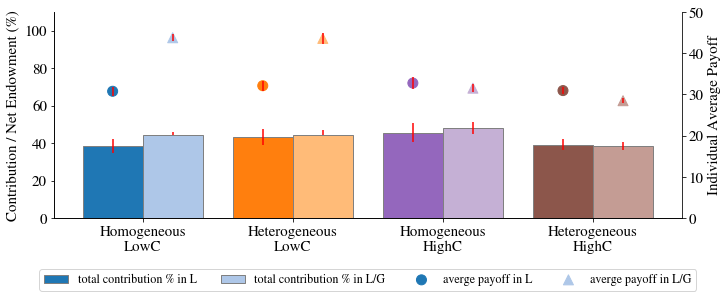

In [16]:
# ************************************************************************************************************************#
# Adding average payoffs
mainV = "-localC-"


labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
labels_both = ["total contribution % in L", "total contribution % in L/G"]
labels_both2 = ["averge payoff in L", "averge payoff in L/G"]
colors = ['grey', 'white']
hatchs = ['', '/']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))



# No club
axes.bar([-0.2,.8], output_noC[[0,1],0, 0], 
             yerr=[output_noC[[0,1],0,0]-output_noC[[0,1],0,1], output_noC[[0,1],0,2]-output_noC[[0,1],0,0]],
          label=labels_both[0],
             color=[palette_tab20[0],palette_tab20[2]], width=.4, ecolor='red', edgecolor='gray')

# With club
axes.bar([0.2,1.2], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]- output[[0,1],0, 0], output[[0,1],0,2]- output[[0,1],0, 0]],
          label=labels_both[1], 
             color=[palette_tab20[1],palette_tab20[3]], width=.4, ecolor='red', edgecolor='gray') 
# No club
axes.bar([1.8,2.8], output_noC[[2,3],0, 0], 
             yerr=[output_noC[[2,3],0,0]-output_noC[[2,3],0,1], output_noC[[2,3],0,2]-output_noC[[2,3],0,0]],
             color=[palette_tab20[8],palette_tab20[10]] ,width=.4 ,ecolor='red', edgecolor='gray')
# With club
axes.bar([2.2,3.2], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
             color=[palette_tab20[9],palette_tab20[11]],width=.4, ecolor='red', edgecolor='gray' )

############# Add average payoffs as dots
# No club
axes2 = axes.twinx()
a = [-.2,.8]
b = output_noC[[0,1],4, 0]
c = output_noC[[0,1],4, 0] - output_noC[[0,1],4, 1]
axes2.scatter(a, b,
             color=[palette_tab20[0],palette_tab20[2]] , label=labels_both2[0], s=100 )
axes2.errorbar(a,b,yerr=c, linestyle="None", c='red')

# With club

a = [0.2,1.2]
b = output[[0,1],4, 0]
c = output[[0,1],4, 0] -output[[0,1],4, 1]
axes2.scatter(a, b,  color=[palette_tab20[1],palette_tab20[3]],label=labels_both2[1],marker='^', s=100  )
axes2.errorbar(a,b,yerr=c, linestyle="None", c='red')


# # No club

a = [1.8, 2.8]
b = output_noC[[2,3],4, 0]
c = output_noC[[2,3],4, 0] - output_noC[[2,3],4, 1]
axes2.scatter(a, b, color=[palette_tab20[8],palette_tab20[10]] , marker='o' , s=100)
axes2.errorbar(a,b,yerr=c, linestyle="None", c='red')

# # With club

a = [2.2,3.2]
b = output[[2,3],4, 0]
c = output[[2,3],4, 0] - output[[2,3],4, 1]
axes2.scatter(a, b, color=[palette_tab20[9],palette_tab20[11]]  , marker='^', s=100)
axes2.errorbar(a,b,yerr=c, linestyle="None", c='red')


axes.set_xticks(x)
axes.set_xticklabels(labels,fontsize=15)
axes.set_ylim(0,1.1)
axes.set_yticklabels(np.arange(0,101,20),fontsize=15)
axes.set_ylabel('Contribution / Net Endowment (%)',fontsize=15)
axes.tick_params(axis='y', labelsize=15)
axes2.set_ylim(0, 50)
axes2.set_yticklabels(np.arange(0,51,10),fontsize=15)
axes2.set_ylabel('Individual Average Payoff',fontsize=15)

lines, labels = axes.get_legend_handles_labels()
lines2, labels2 = axes2.get_legend_handles_labels()
axes.legend( lines+lines2, labels+labels2, bbox_to_anchor=(.5,-.3), loc="center" , ncol=4,fontsize=12)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes2.spines['top'].set_visible(False)

print(doFile_name+sample_name+sample_round+mainV+ValorShare)
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+ValorShare+"4.pdf", bbox_inches="tight" ) 

01-group-data-Dec-2022-within-subject-focus-colored-all5-first10-globalC--Share-


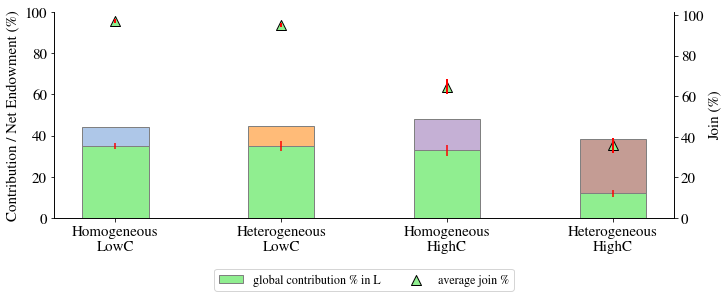

In [17]:
## Try to draw global contribution only, need to differentiate 

# ************************************************************************************************************************#

mainV = "-globalC-"


labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
labels_both = ["Local PG in L", "Local PG in L/G"]
colors = ['grey', 'white']
hatchs = ['', '/']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))



# With club
axes.bar([0,1], output[[0,1],0, 0] ,
         color=[palette_tab20[1],palette_tab20[3]], width=.4, ecolor='red', edgecolor='gray') 
# With club
axes.bar([2,3], output[[2,3],0, 0], 
             color=[palette_tab20[9],palette_tab20[11]],width=.4, ecolor='red', edgecolor='gray' )

########Global contribution 
# With club
axes.bar([0,1], output[[0,1],2, 0], 
             yerr=[output[[0,1],2,0]- output[[0,1],2, 1], output[[0,1],2,2]- output[[0,1],2, 0]],
          label="global contribution % in L",
             color='lightgreen', width=.4, ecolor='red', edgecolor='gray') 

# With club
axes.bar([2,3], output[[2,3],2, 0], 
             yerr=[output[[2,3],2,0]-output[[2,3],2,1], output[[2,3],2,2]-output[[2,3],2,0]],
             color='lightgreen',width=.4, ecolor='red', edgecolor='gray' )



########Global join behaviors 
axes2 = axes.twinx()
a = [0,1]
b = output[[0,1],3, 0]
c = output[[0,1],3, 0] -output[[0,1],3, 1]
axes2.scatter(a, b, color='lightgreen' , label="average join %" ,  marker='^', s=100,  edgecolor='black')
axes2.errorbar(a,b,yerr=c, linestyle="None", c='red',elinewidth=2)


a = [2,3]
b = output[[2,3],3, 0]
c = output[[2,3],3, 0] -output[[2,3],3, 1]
axes2.scatter(a, b, color='lightgreen', marker='^', s=100, edgecolor='black')
axes2.errorbar(a,b,yerr=c, linestyle="None", c='red',elinewidth=2)


axes.set_xticks(x)
axes.set_xticklabels(labels,fontsize=15)
axes.set_yticks(np.arange(0, 1.1, .2))
axes.set_yticklabels(np.arange(0,101,20),fontsize=15)
axes.set_ylabel('Contribution / Net Endowment (%)',fontsize=15)
axes2.set_yticks(np.arange(0, 1.1, .2))
axes2.set_yticklabels(np.arange(0,101,20),fontsize=15)
axes2.set_ylabel('Join (%)',fontsize=15)

axes.tick_params(axis='y', labelsize=15)

lines, labels = axes.get_legend_handles_labels()
lines2, labels2 = axes2.get_legend_handles_labels()
axes.legend( lines+lines2, labels+labels2, bbox_to_anchor=(.5,-.3), loc="center" , ncol=4,fontsize=12)

axes.spines['top'].set_visible(False)
axes2.spines['top'].set_visible(False)

print(doFile_name+sample_name+sample_round+mainV+ValorShare)
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+ValorShare+".pdf", bbox_inches="tight" ) 

In [18]:
 output[[0,1],3]

array([[0.97321429, 0.96339286, 0.98214286],
       [0.95089286, 0.94017857, 0.96160714]])

01-group-data-Dec-2022-within-subject-focus-colored-all5-first10-globalJoin--Share-


C:\Users\xinxi\AppData\Local\Temp/ipykernel_7900/402129175.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.arange(0,101,20),fontsize=15)


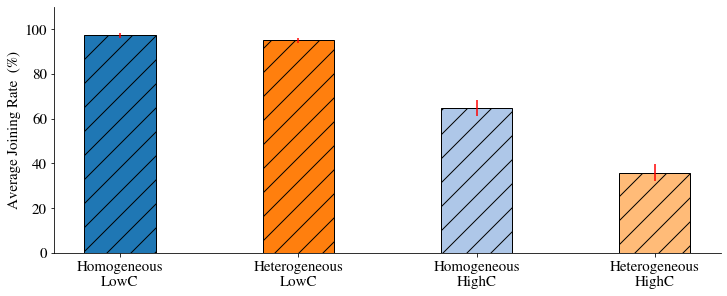

In [19]:
## Try to draw global contribution only, need to differentiate 

# ************************************************************************************************************************#

mainV = "-globalJoin-"


labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
labels_both = ["Local PG in L", "Local PG in L/G"]
colors = ['grey', 'white']
hatchs = ['', '/']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))





# With club
axes.bar([0,1], output[[0,1],3, 0], 
             yerr=[output[[0,1],3,0]- output[[0,1],3, 1], output[[0,1],3,2]- output[[0,1],3, 0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color=[palette_tab20[0],palette_tab20[2]], width=.4, ecolor='red', edgecolor='black') 

# With club
axes.bar([2,3], output[[2,3],3, 0], 
             yerr=[output[[2,3],3,0]-output[[2,3],3,1], output[[2,3],3,2]-output[[2,3],3,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color=[palette_tab20[1],palette_tab20[3]],width=.4, ecolor='red', edgecolor='black' )



axes.set_xticks(x)
axes.set_xticklabels(labels,fontsize=15)
axes.set_ylim(0,1.1)
axes.set_yticklabels(np.arange(0,101,20),fontsize=15)
axes.set_ylabel('Average Joining Rate  (%)',fontsize=15)
axes.tick_params(axis='y', labelsize=15)
# axes.legend( labels_both, bbox_to_anchor=(.5,-.3), loc="center" , ncol=3,fontsize=15)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

print(doFile_name+sample_name+sample_round+mainV+ValorShare)
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+ValorShare+".pdf", bbox_inches="tight" ) 

# Time Trend

01-group-data-Dec-2022-within-subject-focus-colored-all5-first10-ContrShare-L--Trend.pdf


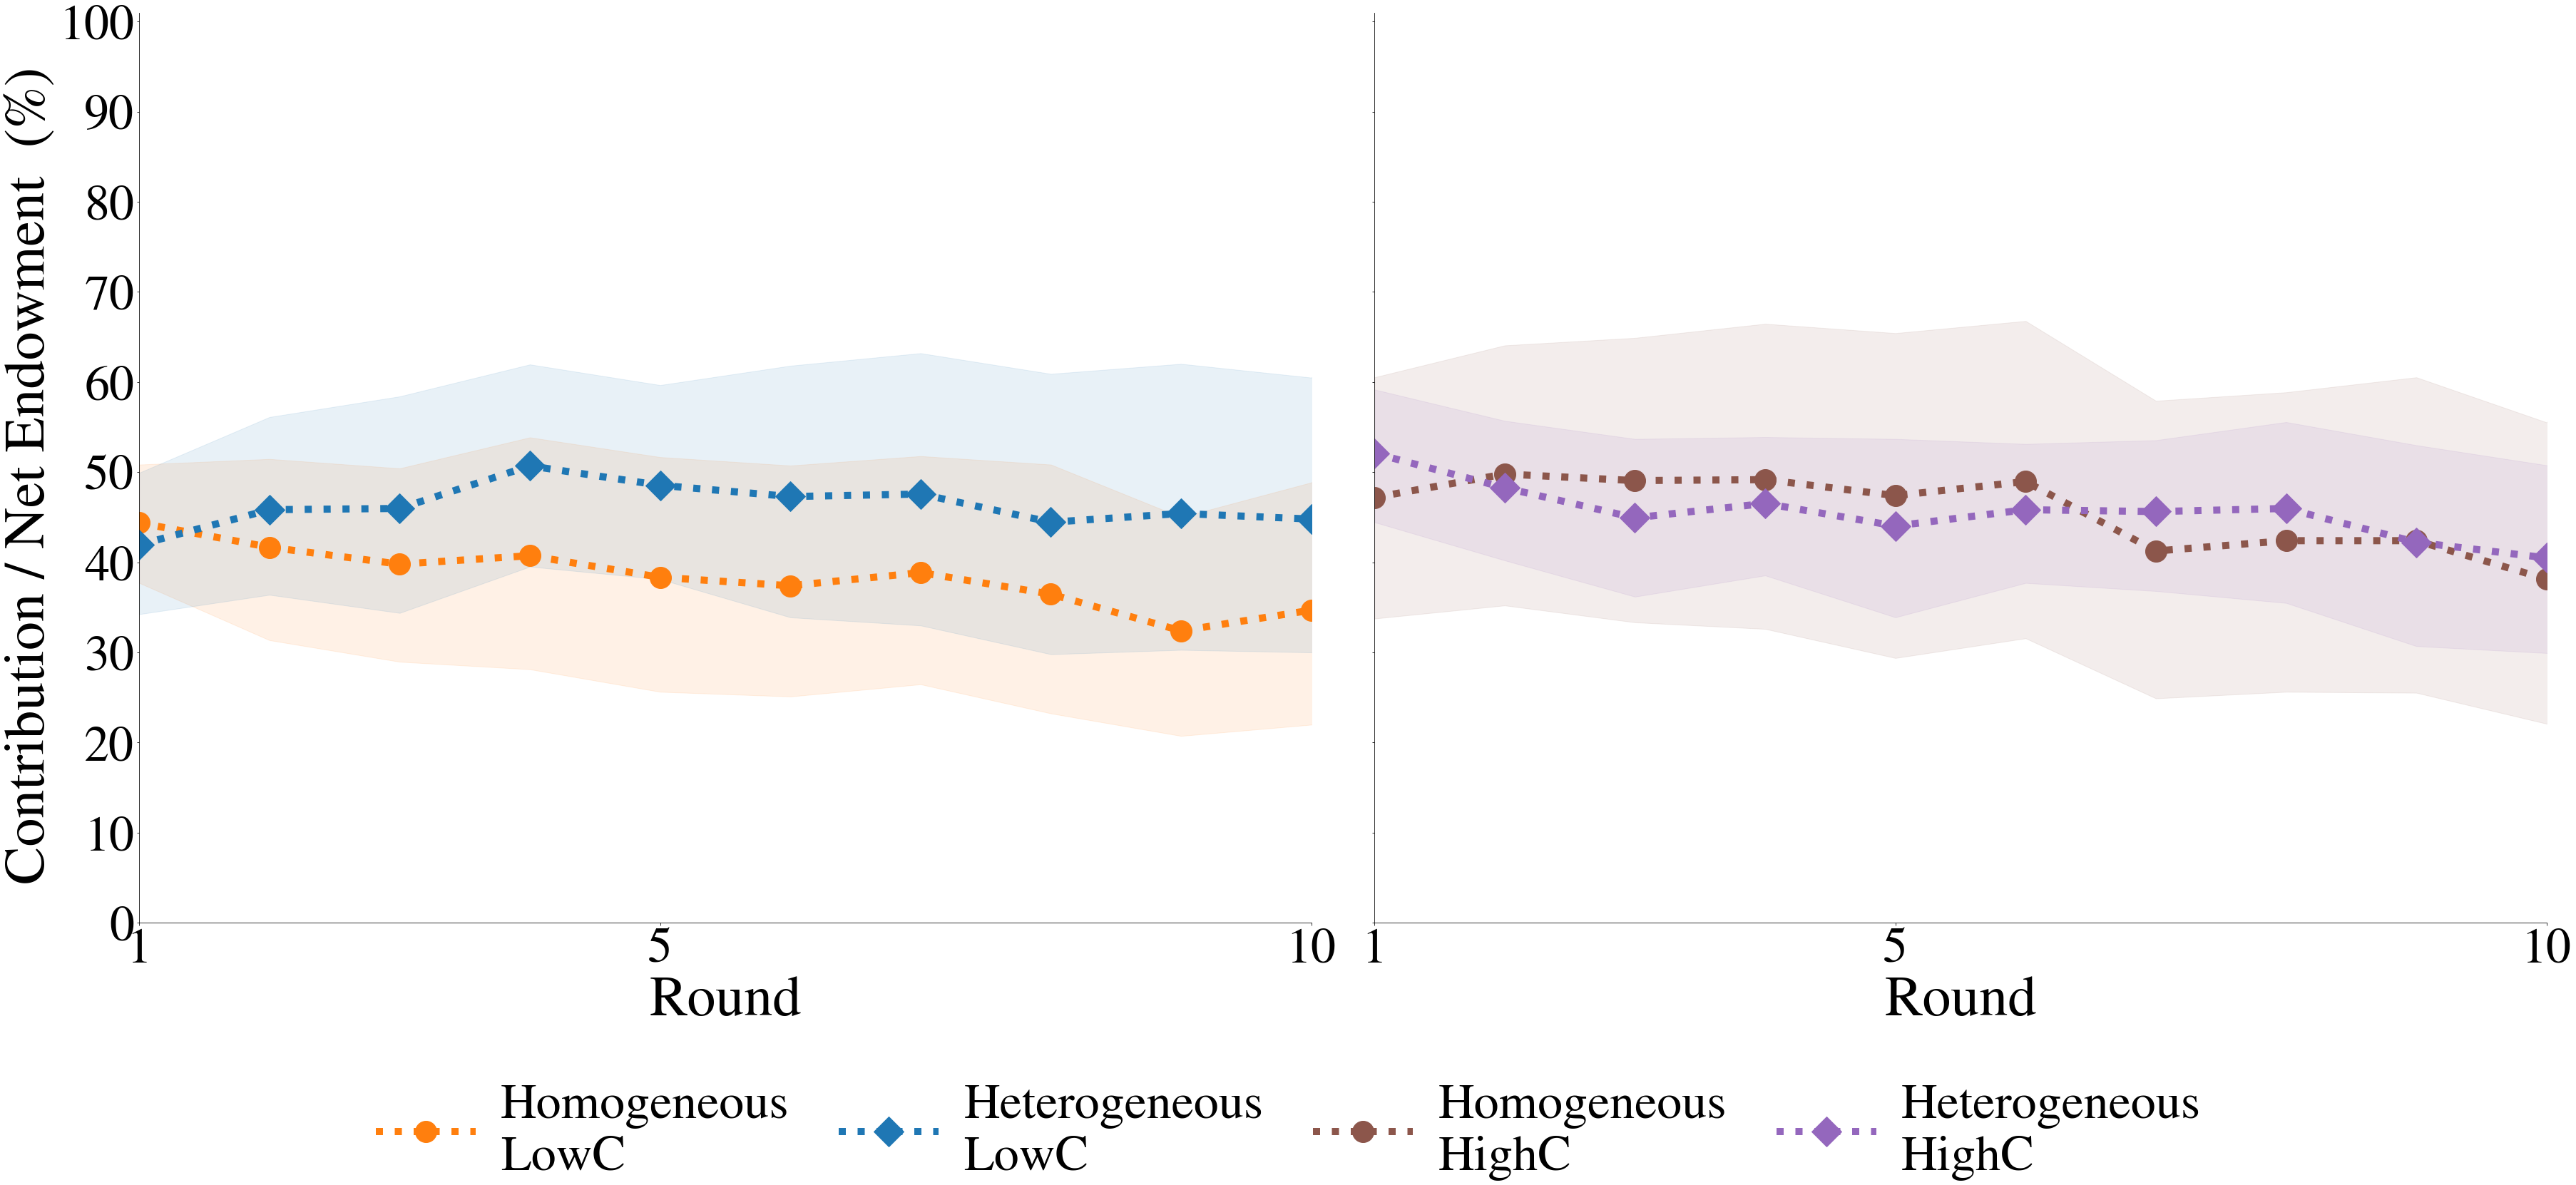

In [54]:
### This is to create the graph for all rounds
mainV = "-ContrShare-L-"


# treatment_list_r = ['Heterogeneous: high endowment','Heterogeneous: low endowment', 'Homogeneous']
treatment_list = ['HOMO','HETERO']
labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']

# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'Treatment'
# treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)

# right graph for FC=8

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list)


pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HETERO': 'D',
                    'HOMO, Homo (20)': 'o',
                    'HOMO': 'o'
                     }
    
custom_markercolor = [ palette_tab20[2], palette_tab20[0], ]
custom_markerfacecolor = [palette_tab20[2], palette_tab20[0]]
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list):
    axes[0].plot(df[yy], label=labels[j], marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=80)
axes[0].set_ylabel('Contribution / Net Endowment  (%) ', fontsize=80)
# axes[0].set_title('LowC', fontsize=80)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

custom_markercolor = [ palette_tab20[10],palette_tab20[8], ]
custom_markerfacecolor = [palette_tab20[10],palette_tab20[8]]

for j, yy in enumerate(treatment_list):
    axes[1].plot(df_r[yy], label=labels[j+2], marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

# axes[1].set_title('HighC', fontsize=80)
axes[1].set_xlabel('Round', fontsize=80)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=70)
    axes[i].tick_params(axis='y', labelsize=70)

# handles, labels = axes[0].get_legend_handles_labels() 

# fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
#                borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=70,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
print(doFile_name+sample_name+sample_round+mainV+"-Trend.pdf")
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+"-Trend.pdf", bbox_inches="tight" ) 


01-group-data-Dec-2022-within-subject-focus-colored-all5-first10-ContrShare-LG--Trend.pdf


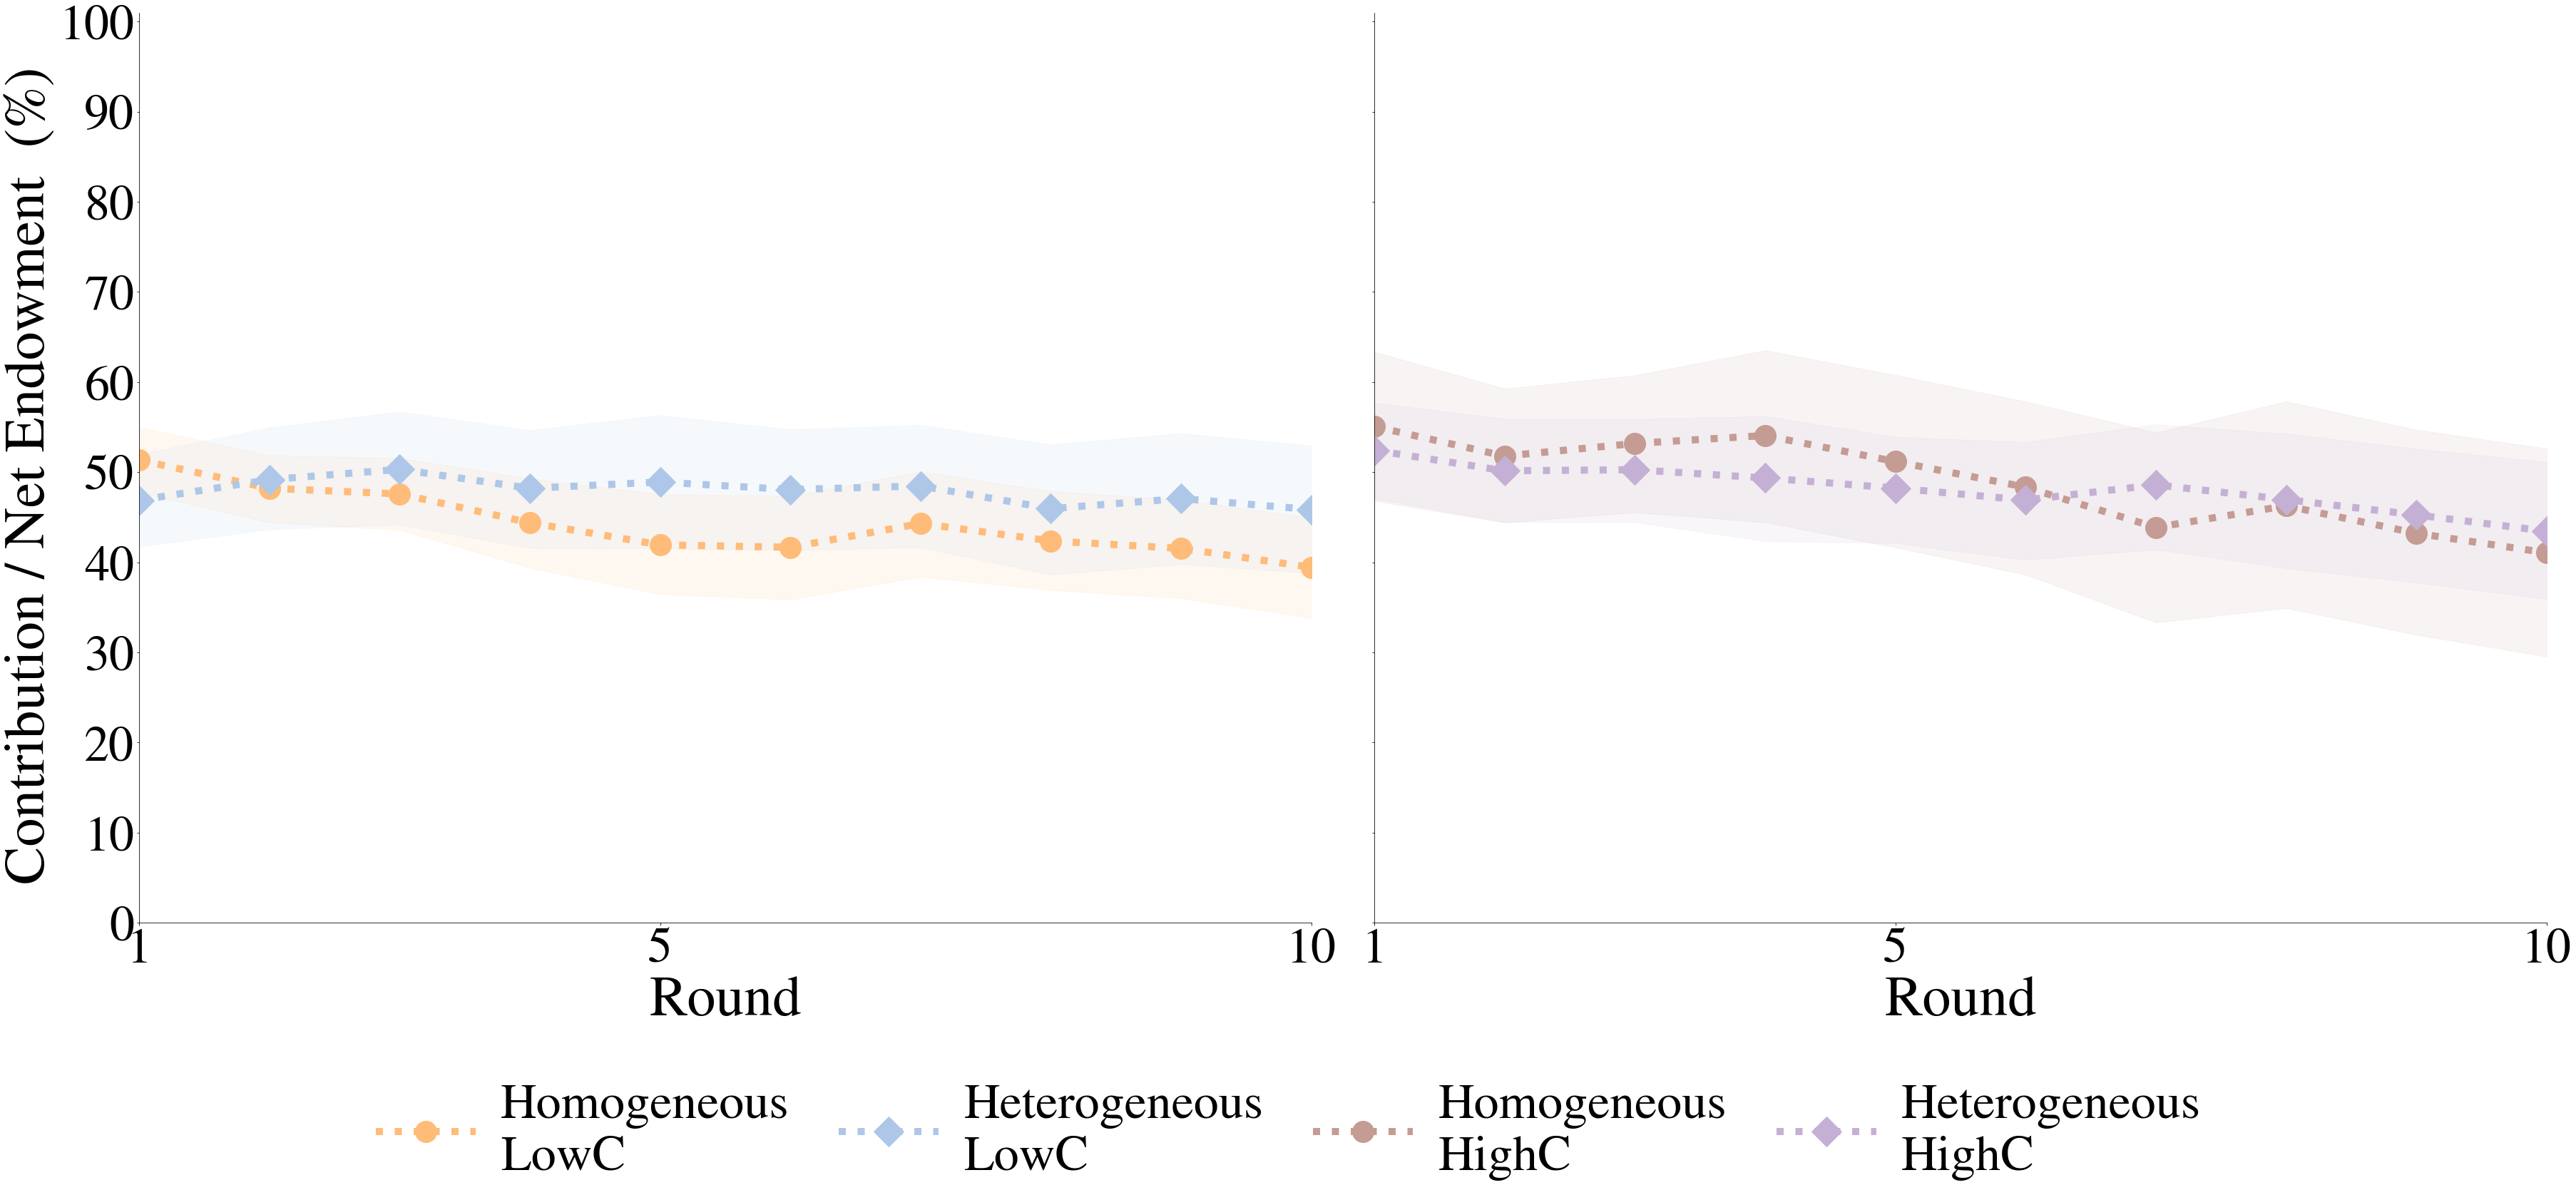

In [58]:
### This is to create the graph for all rounds
mainV = "-ContrShare-LG-"


# treatment_list_r = ['Heterogeneous: high endowment','Heterogeneous: low endowment', 'Homogeneous']
treatment_list = ['HOMO','HETERO']
labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']

# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'Treatment'
# treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)

# right graph for FC=8

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list)


pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HETERO': 'D',
                    'HOMO, Homo (20)': 'o',
                    'HOMO': 'o'
                     }
    
custom_markercolor = [ palette_tab20[3], palette_tab20[1], ]
custom_markerfacecolor = [palette_tab20[3], palette_tab20[1]]
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list):
    axes[0].plot(df[yy], label=labels[j], marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=80)
axes[0].set_ylabel('Contribution / Net Endowment  (%) ', fontsize=80)
# axes[0].set_title('LowC', fontsize=80)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

custom_markercolor = [ palette_tab20[11],palette_tab20[9], ]
custom_markerfacecolor = [palette_tab20[11],palette_tab20[9]]

for j, yy in enumerate(treatment_list):
    axes[1].plot(df_r[yy], label=labels[j+2], marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

# axes[1].set_title('HighC', fontsize=80)
axes[1].set_xlabel('Round', fontsize=80)


for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=70)
    axes[i].tick_params(axis='y', labelsize=70)

# handles, labels = axes[0].get_legend_handles_labels() 

# fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
#                borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=70,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
print(doFile_name+sample_name+sample_round+mainV+"-Trend.pdf")
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+"-Trend.pdf", bbox_inches="tight" ) 


01-group-data-Dec-2022-within-subject-focus-colored-all5-first10-Join-LG--Trend.pdf


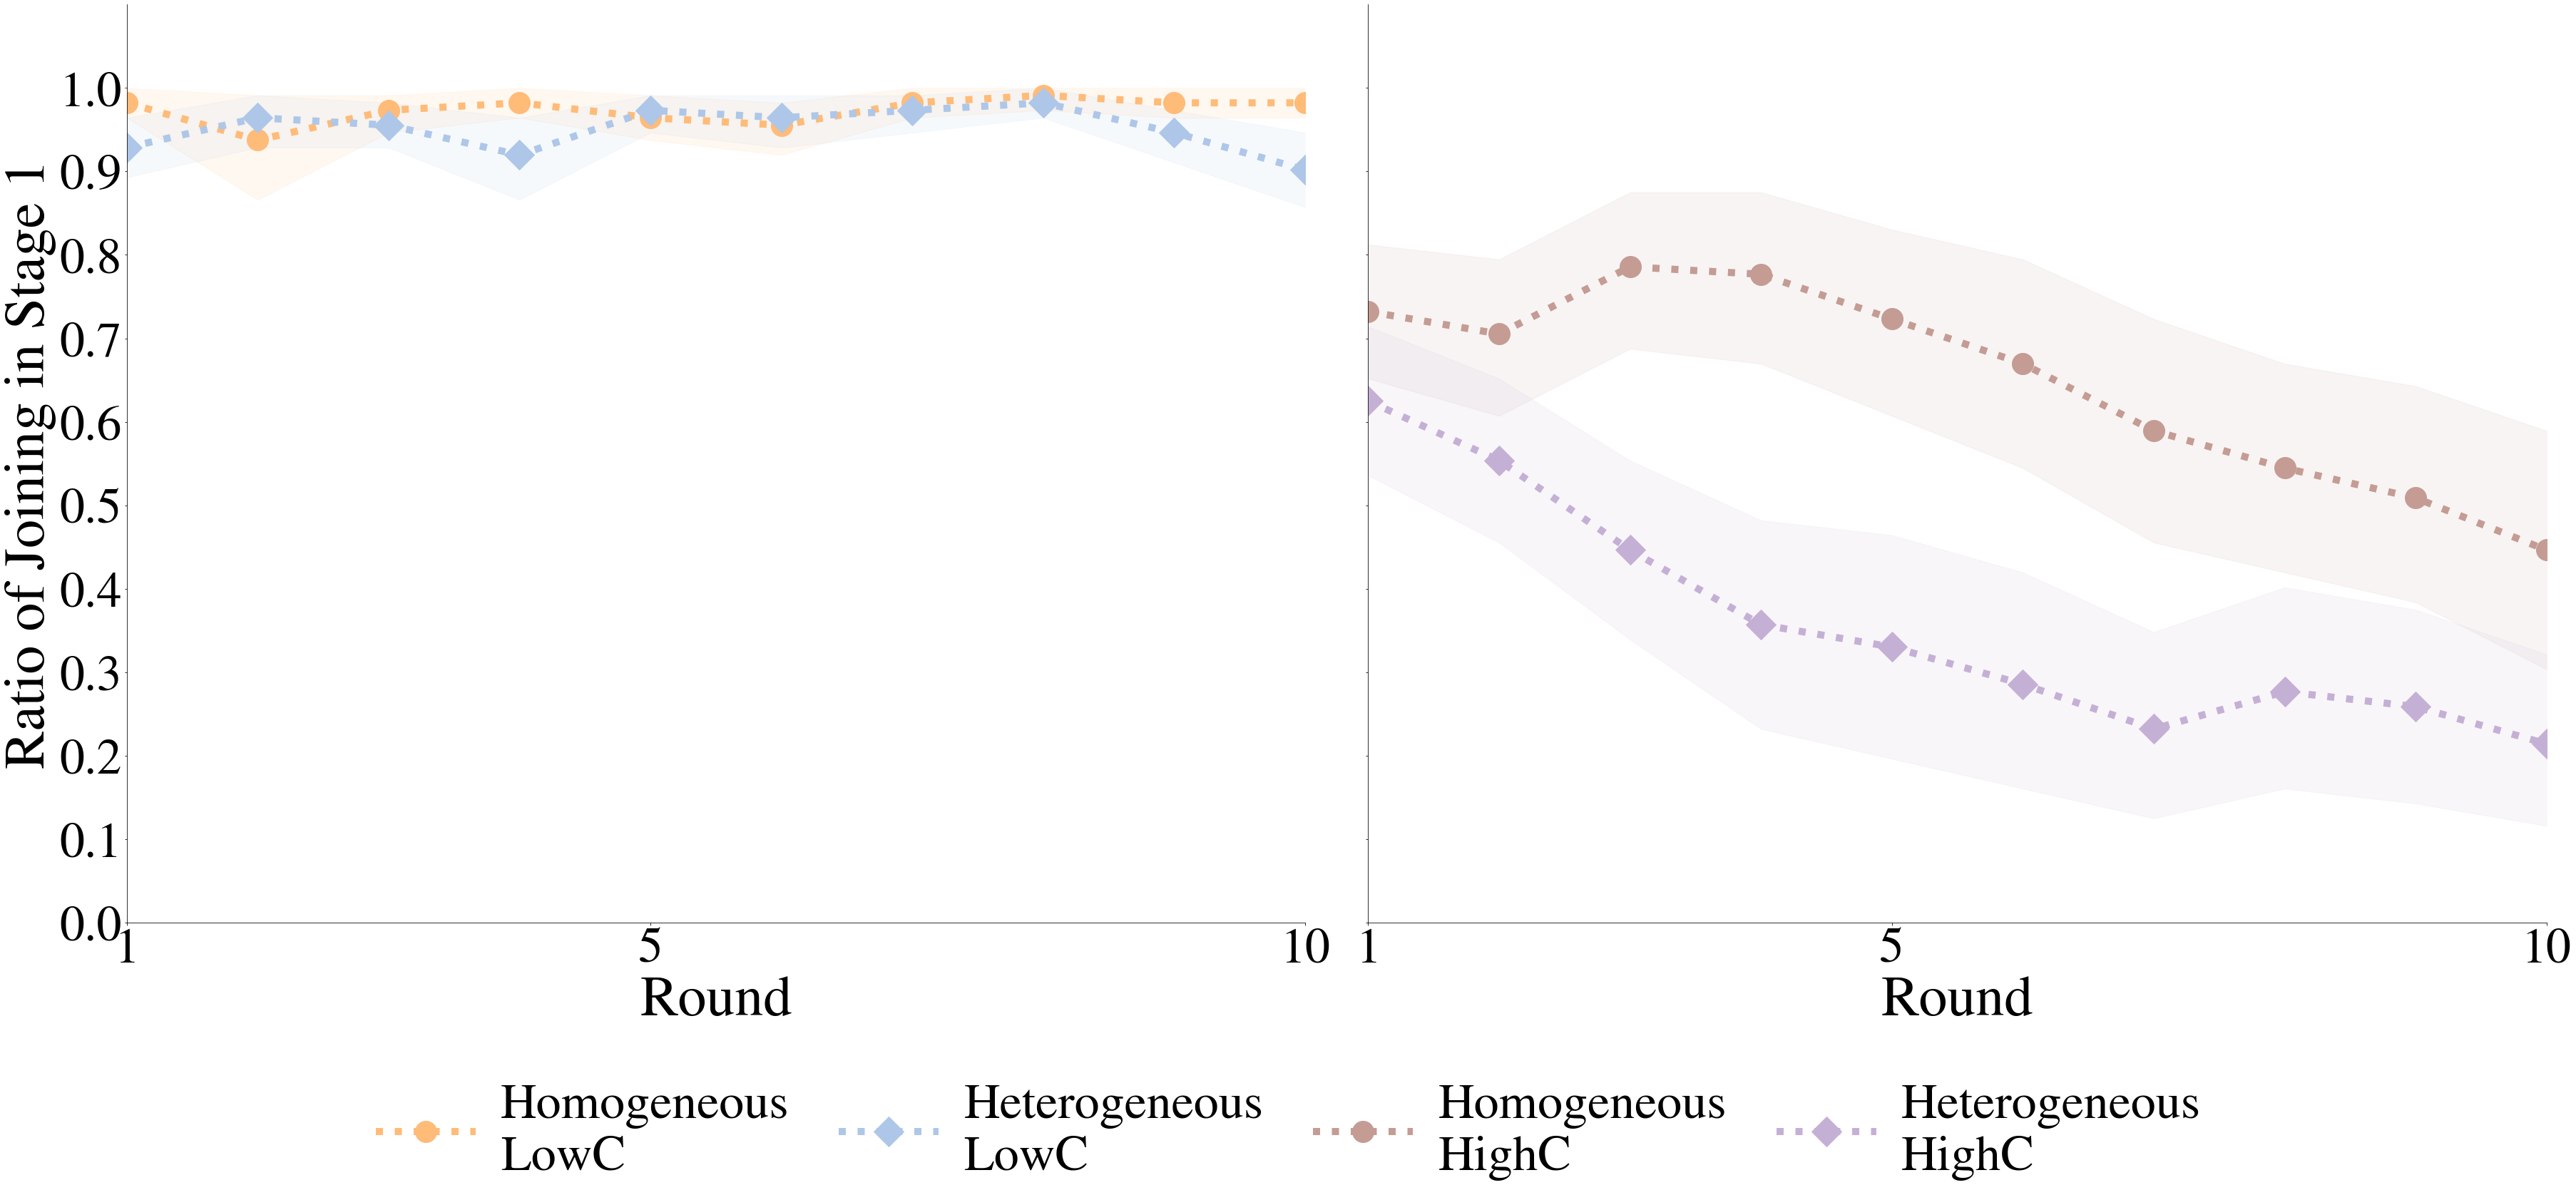

In [59]:
### This is to create the graph for all rounds
mainV = "-Join-LG-"


# treatment_list_r = ['Heterogeneous: high endowment','Heterogeneous: low endowment', 'Homogeneous']
treatment_list = ['HOMO','HETERO']
labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']

# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'Treatment'
# treatment_var = 'T_endw_comp'
var_join = 'player.join_club'
var_of_interest =  var_join
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)

# right graph for FC=8

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list)


pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 1.1)
custom_ytick = np.arange(0,1.1,step=.1)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HETERO': 'D',
                    'HOMO, Homo (20)': 'o',
                    'HOMO': 'o'
                     }
    
custom_markercolor = [ palette_tab20[3], palette_tab20[1], ]
custom_markerfacecolor = [palette_tab20[3], palette_tab20[1]]
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list):
    axes[0].plot(df[yy], label=labels[j], marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=80)
axes[0].set_ylabel('Ratio of Joining in Stage 1', fontsize=80)
# axes[0].set_title('LowC', fontsize=80)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

custom_markercolor = [ palette_tab20[11],palette_tab20[9], ]
custom_markerfacecolor = [palette_tab20[11],palette_tab20[9]]

for j, yy in enumerate(treatment_list):
    axes[1].plot(df_r[yy], label=labels[j+2], marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

# axes[1].set_title('HighC', fontsize=80)
axes[1].set_xlabel('Round', fontsize=80)
for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=70)
    axes[i].tick_params(axis='y', labelsize=70)

# handles, labels = axes[0].get_legend_handles_labels() 

# fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
#                borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=70,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
print(doFile_name+sample_name+sample_round+mainV+"-Trend.pdf")
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+"-Trend.pdf", bbox_inches="tight" ) 


index 0 0 HOMO player.contribution_local
index 0 1 HOMO player.contribution_global
index 1 0 HETERO player.contribution_local
index 1 1 HETERO player.contribution_global
index 2 0 HOMO player.contribution_local
index 2 1 HOMO player.contribution_global
index 3 0 HETERO player.contribution_local
index 3 1 HETERO player.contribution_global
index 0 0 HOMO player.contribution_local
index 0 1 HOMO player.contribution_global
index 1 0 HETERO player.contribution_local
index 1 1 HETERO player.contribution_global
index 2 0 HOMO player.contribution_local
index 2 1 HOMO player.contribution_global
index 3 0 HETERO player.contribution_local
index 3 1 HETERO player.contribution_global
01-group-data-Dec-2022-within-subject-focus--all5--first1--localC--Share-
01-group-data-Dec-2022-within-subject-focus--all5--first1--localCglobalC--Share-


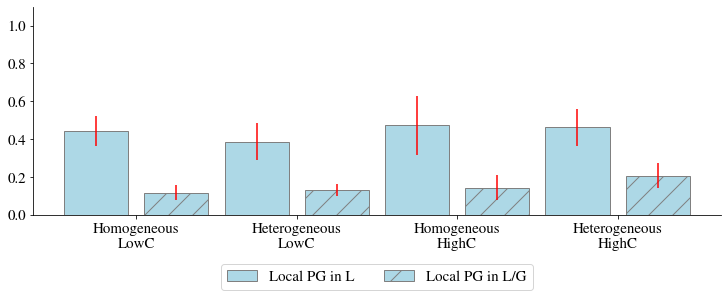

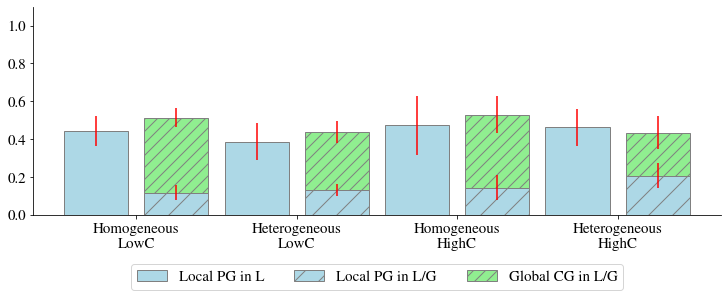

In [65]:
# % This is created to produce a bar graph for local public good contribution only, comparing L and L/G environments
# Only use percentage

treatment_list = ['HOMO','HETERO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
var_of_interest2 = [var_l, var_g, 'endowment']
R_max = 1
sample_round = "-first1-" # "first1"; "allRounds";"-first10-"
ValorShare= "-Share-"

LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest2].sum().reset_index()


output = np.empty((4,2, 3))
output[:]=np.nan



for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), v] / LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), 'endowment']
       
        print('index', i,j, t, v)
        output[i, j, 0]=pop_a.mean()
        output[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), v]  / LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), 'endowment']
       
        print('index', i+2, j, t,v)
        output[i+2,j, 0]=pop_a.mean()
        output[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        


LocalOnly = data_noOppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest2].sum().reset_index()


output_noC = np.empty((4,2, 3))
output_noC[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==20), v]  / LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==20), 'endowment']
       
        print('index', i,j, t, v)
        output_noC[i, j, 0]=pop_a.mean()
        output_noC[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==80), v]  / LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==80), 'endowment']
       
        print('index', i+2, j, t,v)
        output_noC[i+2,j, 0]=pop_a.mean()
        output_noC[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        
var_of_interest = 'endowment'
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()
total_e = np.empty((2,2,3))
total_e[:]=np.nan

for i,t in enumerate(treatment_list): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]
    total_e[i,0,0] =pop_a.mean()
    total_e[i, 0, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
    
    pop_b = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]
    total_e[i,1,0] = np.mean(pop_b)
    total_e[i, 1, 1:3]=bootstrap_ci(np.array(pop_b), 10000, np.mean)  
#     print(i,t)


# ************************************************************************************************************************#

mainV = "-localC-"


labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
labels_both = ["Local PG in L", "Local PG in L/G"]
colors = ['grey', 'white']
hatchs = ['', '/']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))



# No club
axes.bar([-.25,.75], output_noC[[0,1],0, 0], 
             yerr=[output_noC[[0,1],0,0]-output_noC[[0,1],0,1], output_noC[[0,1],0,2]-output_noC[[0,1],0,0]],
          label=labels_both[0],
         bottom = output_noC[[0,1],1, 0], 
             hatch=hatchs[0],
             color = 'lightblue', width=.4, ecolor='red', edgecolor='gray')
# With club
axes.bar([0.25,1.25], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color = 'lightblue', width=.4, ecolor='red', edgecolor='gray')


# No club
axes.bar([1.75, 2.75], output_noC[[2,3],0, 0], 
             yerr=[output_noC[[2,3],0,0]-output_noC[[2,3],0,1], output_noC[[2,3],0,2]-output_noC[[2,3],0,0]],
          label=labels_both[0],
         bottom = output_noC[[2,3],1, 0], 
             hatch=hatchs[0],
             color ='lightblue' ,width=.4 ,ecolor='red', edgecolor='gray')
# With club
axes.bar([2.25,3.25], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color ='lightblue' ,width=.4, ecolor='red', edgecolor='gray' )


# axes.bar([3,4], total_e[[0,1],1, 0], 
#          yerr=[total_e[[0,1],1,0]-total_e[[0,1],1,1], total_e[[0,1],1,2]-total_e[[0,1],1,0]],
#           fill=False, label=labels2[2],
#         edgecolor = 'black')

axes.set_xticks(x)
axes.set_xticklabels(labels,fontsize=15)
axes.set_ylim(0,1.1)
axes.tick_params(axis='y', labelsize=15)
axes.legend( labels_both, bbox_to_anchor=(.5,-.3), loc="center" , ncol=3,fontsize=15)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

print(doFile_name+sample_name+sample_round+mainV+ValorShare)
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+ValorShare+".pdf", bbox_inches="tight" )  
            
            
 # ************************************************************************************************************************#

mainV = "-localCglobalC-"


labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
labels_both = ["Local PG in L", "Local PG in L/G", "Global CG in L/G"]
colors = ['grey', 'white']
hatchs = ['', '/','//']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))



# No club
axes.bar([-.25,.75], output_noC[[0,1],0, 0], 
             yerr=[output_noC[[0,1],0,0]-output_noC[[0,1],0,1], output_noC[[0,1],0,2]-output_noC[[0,1],0,0]],
          label=labels_both[0],
         bottom = output_noC[[0,1],1, 0], 
             hatch=hatchs[0],
             color = 'lightblue', width=.4, ecolor='red' , edgecolor='gray')
# With club
axes.bar([0.25,1.25], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color = 'lightblue', width=.4, ecolor='red', edgecolor='gray' )


axes.bar([0.25,1.25], output[[0,1],1, 0], 
             yerr=[output[[0,1],1,0]-output[[0,1],1,1], output[[0,1],1,2]-output[[0,1],1,0]],
         bottom= output[[0,1],0, 0],
             label=labels_both[2],
             hatch=hatchs[2],
             color = 'lightgreen', width=.4, ecolor='red', edgecolor='gray' )

# No club
axes.bar([1.75, 2.75], output_noC[[2,3],0, 0], 
             yerr=[output_noC[[2,3],0,0]-output_noC[[2,3],0,1], output_noC[[2,3],0,2]-output_noC[[2,3],0,0]],
          label=labels_both[0],
         bottom = output_noC[[2,3],1, 0], 
             hatch=hatchs[0],
             color ='lightblue' ,width=.4 , ecolor='red', edgecolor='gray' )
# With club
axes.bar([2.25,3.25], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color ='lightblue' ,width=.4 , ecolor='red', edgecolor='gray' )

axes.bar([2.25,3.25], output[[2,3],1, 0], 
             yerr=[output[[2,3],1,0]-output[[2,3],1,1], output[[2,3],1,2]-output[[2,3],1,0]],
             label=labels_both[0],
             hatch=hatchs[2],
             bottom=output[[2,3],0, 0],
             color = 'lightgreen' ,width=.4 , ecolor='red', edgecolor='gray')


axes.set_xticks(x)
axes.set_xticklabels(labels, fontsize=15)
axes.set_ylim(0,1.1)
axes.tick_params(axis='y', labelsize=15)
axes.legend( labels_both, bbox_to_anchor=(.5,-.3), loc="center" , ncol=3, fontsize=15)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

print(doFile_name+sample_name+sample_round+mainV+ValorShare)
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+ValorShare+".pdf", bbox_inches="tight" )  




In [ ]:
data_Oppor

index 0 0 HOMO player.payoff
index 1 0 HETERO player.payoff
index 2 0 HOMO player.payoff
index 3 0 HETERO player.payoff
index 0 0 HOMO player.payoff
index 1 0 HETERO player.payoff
index 2 0 HOMO player.payoff
index 3 0 HETERO player.payoff
01-group-data-Dec-2022-within-subject-focus--all5--first1--Payoff--Val-
01-group-data-Dec-2022-within-subject-focus--all5--first1--Payoff--Share-


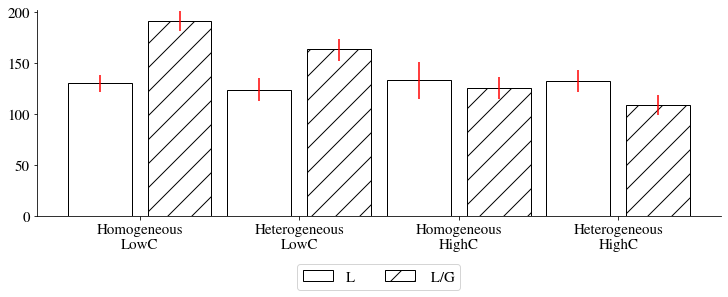

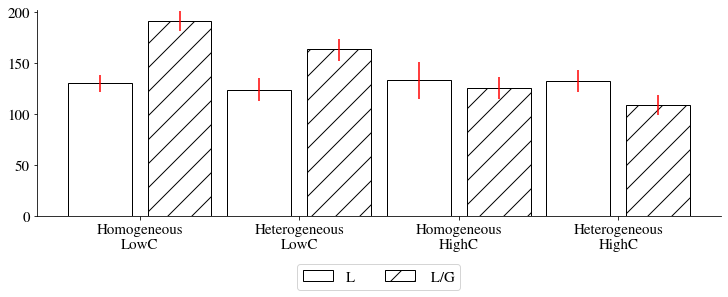

In [66]:
# % This is created to produce a bar graph for local public good contribution only, comparing L and L/G environments

treatment_list = ['HOMO','HETERO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'

var_of_interest =  ['player.payoff']
R_max = 1
sample_round = "-first1-" # "first1"; "allRounds";"-first10-"


LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


output = np.empty((4,2, 3))
output[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), v]
        print('index', i,j, t, v)
        output[i, j, 0]=pop_a.mean()
        output[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), v]
        print('index', i+2, j, t,v)
        output[i+2,j, 0]=pop_a.mean()
        output[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        


LocalOnly = data_noOppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


output_noC = np.empty((4,2, 3))
output_noC[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==20), v]
        print('index', i,j, t, v)
        output_noC[i, j, 0]=pop_a.mean()
        output_noC[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==80), v]
        print('index', i+2, j, t,v)
        output_noC[i+2,j, 0]=pop_a.mean()
        output_noC[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        
var_of_interest = 'endowment'
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()
total_e = np.empty((2,2,3))
total_e[:]=np.nan

for i,t in enumerate(treatment_list): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]
    total_e[i,0,0] =pop_a.mean()
    total_e[i, 0, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
    
    pop_b = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]
    total_e[i,1,0] = np.mean(pop_b)
    total_e[i, 1, 1:3]=bootstrap_ci(np.array(pop_b), 10000, np.mean)  
#     print(i,t)


# ************************************************************************************************************************#

mainV = "-Payoff-"
ValorShare= "-Val-"

labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
labels_both = ["L", " L/G"]
colors = ['grey', 'white']
hatchs = ['', '/']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))



# No club
axes.bar([-.25,.75], output_noC[[0,1],0, 0], 
             yerr=[output_noC[[0,1],0,0]-output_noC[[0,1],0,1], output_noC[[0,1],0,2]-output_noC[[0,1],0,0]],
          label=labels_both[0],
             hatch=hatchs[0],
             color = 'white', width=.4, edgecolor = 'black',ecolor='red')
# With club
axes.bar([0.25,1.25], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color = 'white', width=.4, edgecolor = 'black',ecolor='red')

# axes.bar([0,1], total_e[[0,1],0, 0], 
#          yerr=[total_e[[0,1],0,0]-total_e[[0,1],0,1], total_e[[0,1],0,2]-total_e[[0,1],0,0]],
#           fill=False, label=labels2[2],
#          fill=False, edgecolor = 'black')

# No club
axes.bar([1.75, 2.75], output_noC[[2,3],0, 0], 
             yerr=[output_noC[[2,3],0,0]-output_noC[[2,3],0,1], output_noC[[2,3],0,2]-output_noC[[2,3],0,0]],
          label=labels_both[0], 
             hatch=hatchs[0],
             color ='white' ,width=.4 , edgecolor = 'black',ecolor='red')
# With club
axes.bar([2.25,3.25], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color ='white' ,width=.4 , edgecolor = 'black',ecolor='red')

axes.set_xticks(x)
axes.set_xticklabels(labels,fontsize=15)
axes.set_ylim(0,201)
axes.tick_params(axis='y', labelsize=15)
axes.legend( labels_both, bbox_to_anchor=(.5,-.3), loc="center" , ncol=3,fontsize=15)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

print(doFile_name+sample_name+sample_round+mainV+ValorShare)
fig.savefig("..\\Output\\"+doFile_name+sample_name+sample_round+mainV+ValorShare+".pdf", bbox_inches="tight" )  
            
            


In [70]:
np.random.choice(100)

18

# Define functions and important variables 

-[Return](#Content)


In [6]:
def bootstrap_ci(data, n_samples, stat):
    
    n = len(data)                                #get length of the data
    ix = np.random.randint(0, n, (n_samples, n)) #get an array of bootsrapped indices
    samples = data[ix]                           #create bootrapped samples
    
    distribution = stat(samples, axis=1)

    return (np.percentile(distribution,2.5),np.percentile(distribution,97.5))

In [7]:
def permutation_test_r(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    original_stat=np.mean(sample1)-np.mean(sample2)
    print("Original Statistic:",original_stat)
    combined=np.append(sample1,sample2)
    #print combined
    permutations=np.matrix(list(itertools.permutations(combined)))
    print(permutations)
    n_permut=len(permutations)
    print("Number of permutations:",len(permutations))
    distr=permutations[:,0:n1].mean(axis=1)-permutations[:,n1:n1+n2].mean(axis=1)
    count=(distr<=original_stat).sum()
    print("Count: ",count," out of ",n_permut)
    p_val=np.round(float(count)/float(n_permut),3)
    print("Probability: ",p_val)

In [8]:
def permutation_test(pop_a, pop_b):

    original_statistics = pop_a.mean() - pop_b.mean()
    print(original_statistics)

    print('# 2. use permutation test (non-parametric test)' )
    n1 = len(pop_a)
    n2 = len(pop_b)
    
    sim_num = 10000
    
    combined = np.append(pop_a, pop_b)
#     permutationss=np.matrix(list(permutations(combined)))
#     n_permut=len(permutationss)
    n = len(combined)
    idx = np.arange(n)
    sim_d = []
    for i in range(sim_num):
        np.random.shuffle(idx)
        d = np.mean(combined[idx][0:n1]) - np.mean(combined[idx][n1::])
    #     print(d)
        sim_d.append(d)
    # calculate the p-value for two-sided test:
    count = (np.abs(sim_d)>=np.abs(original_statistics)).sum()
    # calculate the one-sided test, first-second
#     count = (np.array(sim_d)>=original_statistics).sum()
#     print(count)
    p_val = np.round((count+1)/(sim_num+1), 3)
    print("p-value for two-sided test", p_val)
    
#     distr=np.array(np.ma.mean(permutationss[:,0:n1],1)-np.ma.mean(permutationss[:,n1:n1+n2],1))
# #     count=(distr<=original_statistics).sum()
#     count=(np.abs(distr)>=np.abs(original_statistics)).sum()
#     print("Permutation Count: ",count," out of ",n_permut)
#     p_val=np.round(float(count)/float(n_permut),3)
#     print("two-sided Probability: ",p_val)


# Start Data Analysis

Sequence : [7, 6, 18, 17, 13, 8, 12, 7]

A1 = [7] (10 rounds)

B1 = [6,18,17]

A2 = [13]

B2 = [8]

-[Order Effect](#Order-effect)

-[Compare Local and Global](#Compare-Local-and-Global)

-[Local Only Environment ](#Local-Only-Environment )

-[Local + Global Environment](#Local-+-Global-Environment)

-[Analyze Global + Local ](#Analyze-Global-+-Local)

-[Both Environments](#Both-Environments)

-[ All apps](#All-apps)

-[Return](#Content)


## Order effect

Compare the average between B1 in ABA and B1 in BAB sequence


In [12]:
data_Oppor = data_Oppor_B1
# data_Oppor=data_Oppor_allB

GroupRound = data_Oppor.groupby(['group.id_in_subsession', #'player.local_community',
                                  'session.code','subsession.sg',
                                  'Treatment','FC','Sequence',
                                  'subsession.round_number'])['tot_contr',  'privateAcc', 'player.payoff','player.contribution_local','player.contribution_global' ].sum().reset_index()

MatchAverage = GroupRound.groupby(['group.id_in_subsession', 'subsession.sg', #'player.local_community',
                                  'session.code',
                                  'Treatment','FC','Sequence'])['tot_contr',  'privateAcc', 'player.payoff','player.contribution_local','player.contribution_global' ].mean().reset_index()
CompareBoth = MatchAverage
# pd.pivot_table(data_Oppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC','Sequence'],
#                     columns=['subsession.round_number'], aggfunc=np.sum, fill_value=np.nan)

CompareBoth.groupby(['Treatment','FC','Sequence'])['tot_contr'].agg(['mean','std'])
# LocalOnly.groupby(['Treatment','FC']).mean() # Note: if only A2 and A2_bab, contribution: downward trending is apparent; added A1, not very apparent (Hetero 20 upward trending?)

C:\Users\xinxi\AppData\Local\Temp/ipykernel_22052/4213805677.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  GroupRound = data_Oppor.groupby(['group.id_in_subsession', #'player.local_community',
C:\Users\xinxi\AppData\Local\Temp/ipykernel_22052/4213805677.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  MatchAverage = GroupRound.groupby(['group.id_in_subsession', 'subsession.sg', #'player.local_community',


mean        std
Treatment FC Sequence                      
HETERO    20 B1        70.250000  32.850266
             B1_bab    56.025000  12.087132
          80 B1        46.683333  13.416358
             B1_bab    58.191667  18.994563
HOMO      20 B1        56.466667  14.961874
             B1_bab    69.850000  14.884220
          80 B1        32.158333  21.343276
             B1_bab    65.941667  14.874522

In [13]:
# MatchAverage

In [14]:
CompareBoth.groupby(['Treatment','FC','Sequence'])['player.contribution_global'].agg(['mean','std', 'count']).round(2)

mean    std  count
Treatment FC Sequence                     
HETERO    20 B1        60.53  37.14      6
             B1_bab    35.20  10.27      6
          80 B1        11.01  12.43      6
             B1_bab    10.49  13.53      6
HOMO      20 B1        47.75  14.93      6
             B1_bab    51.90   9.39      6
          80 B1        25.12  22.33      6
             B1_bab    40.46  25.40      6

In [15]:
# var_of_interest = 'player.contribution_local'
# var_of_interest = 'player.payoff'
# var_of_interest = 'privateAcc'
var_of_interest =  'player.contribution_global'
condition = (CompareBoth['Treatment']=='HOMO') & (CompareBoth['FC']==80)
groupA = CompareBoth.loc[condition &(CompareBoth['Sequence']=='B1'),var_of_interest]
groupB = CompareBoth.loc[condition&(CompareBoth['Sequence']=='B1_bab'),var_of_interest]

# Note: the tot_contr is only sig diff for HOMO, 80

In [16]:
# ttest(groupA, groupB, correction = False)
stats.ttest_ind(groupA, groupB)

Ttest_indResult(statistic=-1.110472709315187, pvalue=0.2927829749919324)

In [17]:
stats.ranksums(groupA, groupB)

RanksumsResult(statistic=-1.12089707663561, pvalue=0.2623316754083572)

In [18]:
permutation_test(groupA, groupB)

-15.333333333333329
# 2. use permutation test (non-parametric test)
p-value for two-sided test 0.29


In [19]:
# data_Oppor_B1

## Compare Local and Global

-[Start Data Analysis](#Start-Data-Analysis)

In [20]:
data_noOppor_AllA[data_noOppor_AllA['Sequence']=='A1']

subsession.round_number  subsession.period  subsession.sg  \
0                          1                  1              1   
1                          1                  1              1   
2                          1                  1              1   
3                          1                  1              1   
4                          1                  1              1   
..                       ...                ...            ...   
635                       10                 10              1   
636                       10                 10              1   
637                       10                 10              1   
638                       10                 10              1   
639                       10                 10              1   

     player.id_in_group  player.endowment  player.join_club  \
0                     1             300.0                 0   
1                     5             300.0                 0   
2                     2             300.0                 0   
3                     6             300.0                 0   
4                     3             100.0                 0   
..                  ...               ...               ...   
635                   6             200.0                 0   
636                   3             200.0                 0   
637                   7             200.0                 0   
638                   4             200.0                 0   
639                   8             200.0                 0   

     player.local_community  player.id_in_local  player.contribution_local  \
0                         1                   0                       10.0   
1                         2                   0                       10.0   
2                         1                   1                       10.0   
3                         2                   1                        0.0   
4                         1                   2                        4.0   
..                      ...                 ...                        ...   
635                       0                   1                        0.0   
636                       3                   2                        5.0   
637                       0                   2                        0.0   
638                       3                   3                        5.0   
639                       0                   3                        0.0   

     player.contribution_global  ...  participant.code  endowment  \
0                           0.0  ...          zcomruh3       30.0   
1                           0.0  ...          2hmxb93l       30.0   
2                           0.0  ...          8qc6v1us       30.0   
3                           0.0  ...          tr43dm7p       30.0   
4                           0.0  ...          54ewdkpx       10.0   
..                          ...  ...               ...        ...   
635                         0.0  ...          f5y3x8jm       20.0   
636                         0.0  ...          vmvgas4d       20.0   
637                         0.0  ...          t808unro       20.0   
638                         0.0  ...          d975og4q       20.0   
639                         0.0  ...          ry8ivk93       20.0   

     endowment_j  endowment_nj  tot_contr  privateAcc  \
0            0.0         300.0       10.0        20.0   
1            0.0         300.0       10.0        20.0   
2            0.0         300.0       10.0        20.0   
3            0.0         300.0        0.0        30.0   
4            0.0         100.0        4.0         6.0   
..           ...           ...        ...         ...   
635          0.0         200.0        0.0        20.0   
636          0.0         200.0        5.0        15.0   
637          0.0         200.0        0.0        20.0   
638          0.0         200.0        5.0        15.0   
639          0.0         200.0        0.0        20.0   

    

# Local Only Environment 

- [Contribution average time trend ](#Contribution-average-time-trend )

- [Local only (others)](#Local-only-(others))


-[Start Data Analysis](#Start-Data-Analysis)

### Contribution average time trend 

-[Local Only Environment](#Local-Only-Environment)


In [21]:
# Data local only 
data_noOppor = data_noOppor_AllA
data_noOppor['End_level'] = "High (30)"
data_noOppor.loc[data_noOppor['endowment']==10,'End_level'] = "Low (10)"
data_noOppor.loc[data_noOppor['endowment']==20,'End_level'] = "Homo (20)"
data_noOppor['tot_cont_share'] = data_noOppor['tot_contr'] / data_noOppor['endowment'] * 100
data_noOppor['T_endw_comp']= data_noOppor['Treatment'] + ', ' + data_noOppor['End_level']
data_noOppor

subsession.round_number  subsession.period  subsession.sg  \
0                           1                  1              1   
1                           1                  1              1   
2                           1                  1              1   
3                           1                  1              1   
4                           1                  1              1   
...                       ...                ...            ...   
3195                       20                 20              1   
3196                       20                 20              1   
3197                       20                 20              1   
3198                       20                 20              1   
3199                       20                 20              1   

      player.id_in_group  player.endowment  player.join_club  \
0                      1             300.0                 0   
1                      5             300.0                 0   
2                      2             300.0                 0   
3                      6             300.0                 0   
4                      3             100.0                 0   
...                  ...               ...               ...   
3195                   6             200.0                 0   
3196                   3             200.0                 0   
3197                   7             200.0                 0   
3198                   4             200.0                 0   
3199                   8             200.0                 0   

      player.local_community  player.id_in_local  player.contribution_local  \
0                          1                   0                       10.0   
1                          2                   0                       10.0   
2                          1                   1                       10.0   
3                          2                   1                        0.0   
4                          1                   2                        4.0   
...                      ...                 ...                        ...   
3195                       0                   1                       20.0   
3196                       3                   2                        0.0   
3197                       0                   2                        1.0   
3198                       3                   3                        7.0   
3199                       0                   3                        0.0   

      player.contribution_global  ...  endowment_nj  tot_contr  privateAcc  \
0                            0.0  ...         300.0       10.0        20.0   
1                            0.0  ...         300.0       10.0        20.0   
2                            0.0  ...         300.0       10.0        20.0   
3                            0.0  ...         300.0        0.0        30.0   
4                            0.0  ...         100.0        4.0         6.0   
...                          ...  ...           ...        ...         ...   
3195                         0.0  ...         200.0       20.0         0.0   
3196                         0.0  ...         200.0        0.0        20.0   
3197                         0.0  ...         200.0        1.0        19.0   
3198                         0.0  ...         200.0        7.0        13.0   
3199                         0.0  ...         200.0        0.0        20.0   

      player.payoff_globalagg  player.endowment_globalagg  Efficiency  \
0                       230.0                      1600.0    0.598958   
1                       230.0                      1600.0    0.598958   
2                       230.0                      1600.0    0.598958   
3                       230.0                      1600.0    0.598958   
4                       230.0                      1600.0    0.598958   
...                       ...                         ...         ...   
3195                    207.6      

In [22]:
data_noOppor.groupby(['Treatment'])['tot_cont_share'].mean()

Treatment
HETERO    46.264583
HOMO      42.909375
Name: tot_cont_share, dtype: float64

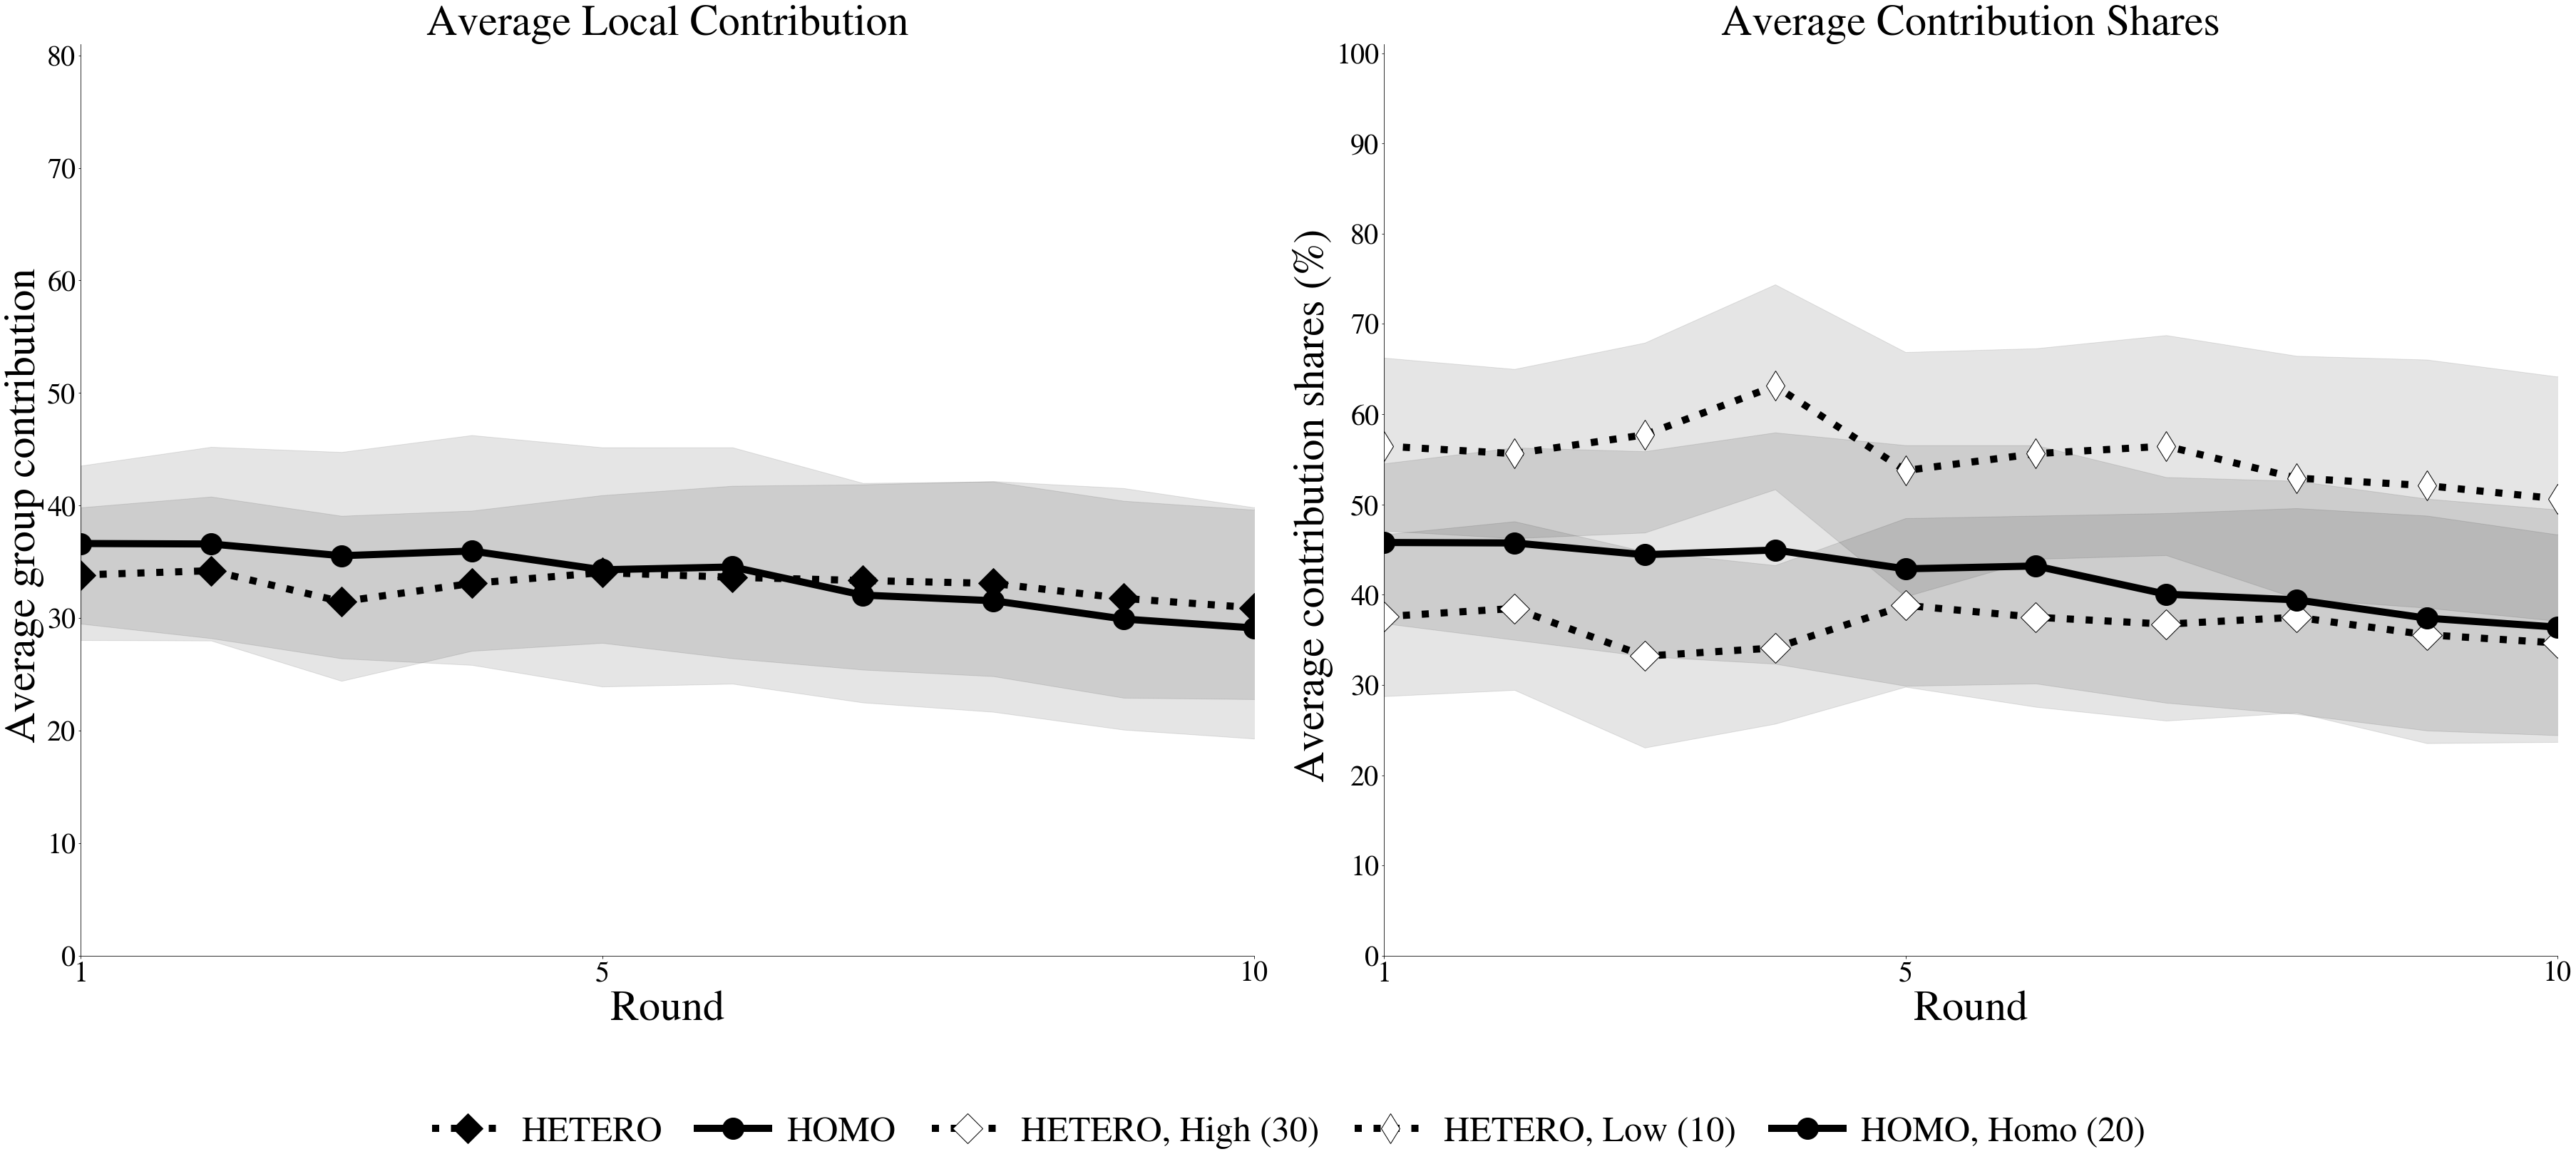

In [23]:
### This is to create the graph for all rounds

# Left graph for absolute value 
treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'tot_contr'

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)



# right graph for absolute value 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_xtick = np.array([0,4,9,14,19])
custom_ytick = np.arange(0,81,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o',
                     }
    
custom_markercolor = ['black', 'black', ]
custom_markerfacecolor = ['black', 'black']
custom_linestyle = [':','-']

for j, yy in enumerate(treatment_list):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average group contribution ', fontsize=60)
axes[0].set_title('Average Local Contribution', fontsize=60)

# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)  
# axes[0].tick_params(axis='x', labelsize=40)
# axes[0].tick_params(axis='y', labelsize=40)



# Right figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']



for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[1].set_xlabel('Round', fontsize=60)
axes[1].set_ylabel('Average contribution shares (%) ', fontsize=60)
axes[1].set_title('Average Contribution Shares', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

# handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Only-Contribution.pdf', bbox_inches="tight" )  


In [15]:
# Prepare to add the simulated data on top of the experimental data
# data_noOppor_sim = CounterfactualData_cut[CounterfactualData_cut['Sequence']=='A2_bab']
data_noOppor_sim = CounterfactualData[CounterfactualData['Sequence']=='A2_bab']

data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
data_noOppor_sim['End_level'] = "High (30)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==10,'End_level'] = "Low (10)"
data_noOppor_sim.loc[data_noOppor_sim['endow_org']==20,'End_level'] = "Homo (20)"
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['tot_contr'] / data_noOppor_sim['endow_org'] * 100
data_noOppor_sim['T_endw_comp']= data_noOppor_sim['Treatment'] + ', ' + data_noOppor_sim['End_level']


# Left graph for absolute value 
treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'tot_contr'

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)


LocalOnly = data_noOppor_sim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

dfSim = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_lSim = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_uSim = pd.DataFrame(output[2,:,:], columns = treatment_list)


# right graph for absolute value 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor_sim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_rSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lrSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_urSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)


C:\Users\xinxi\AppData\Local\Temp/ipykernel_9712/2589311535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_9712/2589311535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['player.contribution_local'] / data_noOppor_sim['endow_org']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_9712/2589311535.py:7: SettingWithCopyWarning: 
A va

In [16]:
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor_sim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
LocalOnly

T_endw_comp  player.local_community  session_num  FC Sequence  \
0      HETERO, High (30)                       0            0  20   A2_bab   
1      HETERO, High (30)                       0            0  20   A2_bab   
2      HETERO, High (30)                       0            0  20   A2_bab   
3      HETERO, High (30)                       0            0  20   A2_bab   
4      HETERO, High (30)                       0            0  20   A2_bab   
...                  ...                     ...          ...  ..      ...   
19195    HOMO, Homo (20)                       3           39  80   A2_bab   
19196    HOMO, Homo (20)                       3           39  80   A2_bab   
19197    HOMO, Homo (20)                       3           39  80   A2_bab   
19198    HOMO, Homo (20)                       3           39  80   A2_bab   
19199    HOMO, Homo (20)                       3           39  80   A2_bab   

       subsession.round_number  subsession.period  tot_cont_share  
0                           51                  1       60.000000  
1                           52                  2       58.333333  
2                           53                  3       24.666667  
3                           54                  4       30.000000  
4                           55                  5       33.333333  
...                        ...                ...             ...  
19195                       66                 16        0.000000  
19196                       67                 17        0.000000  
19197                       68                 18        0.000000  
19198                       69                 19        0.000000  
19199                       70                 20        0.000000  

[19200 rows x 8 columns]

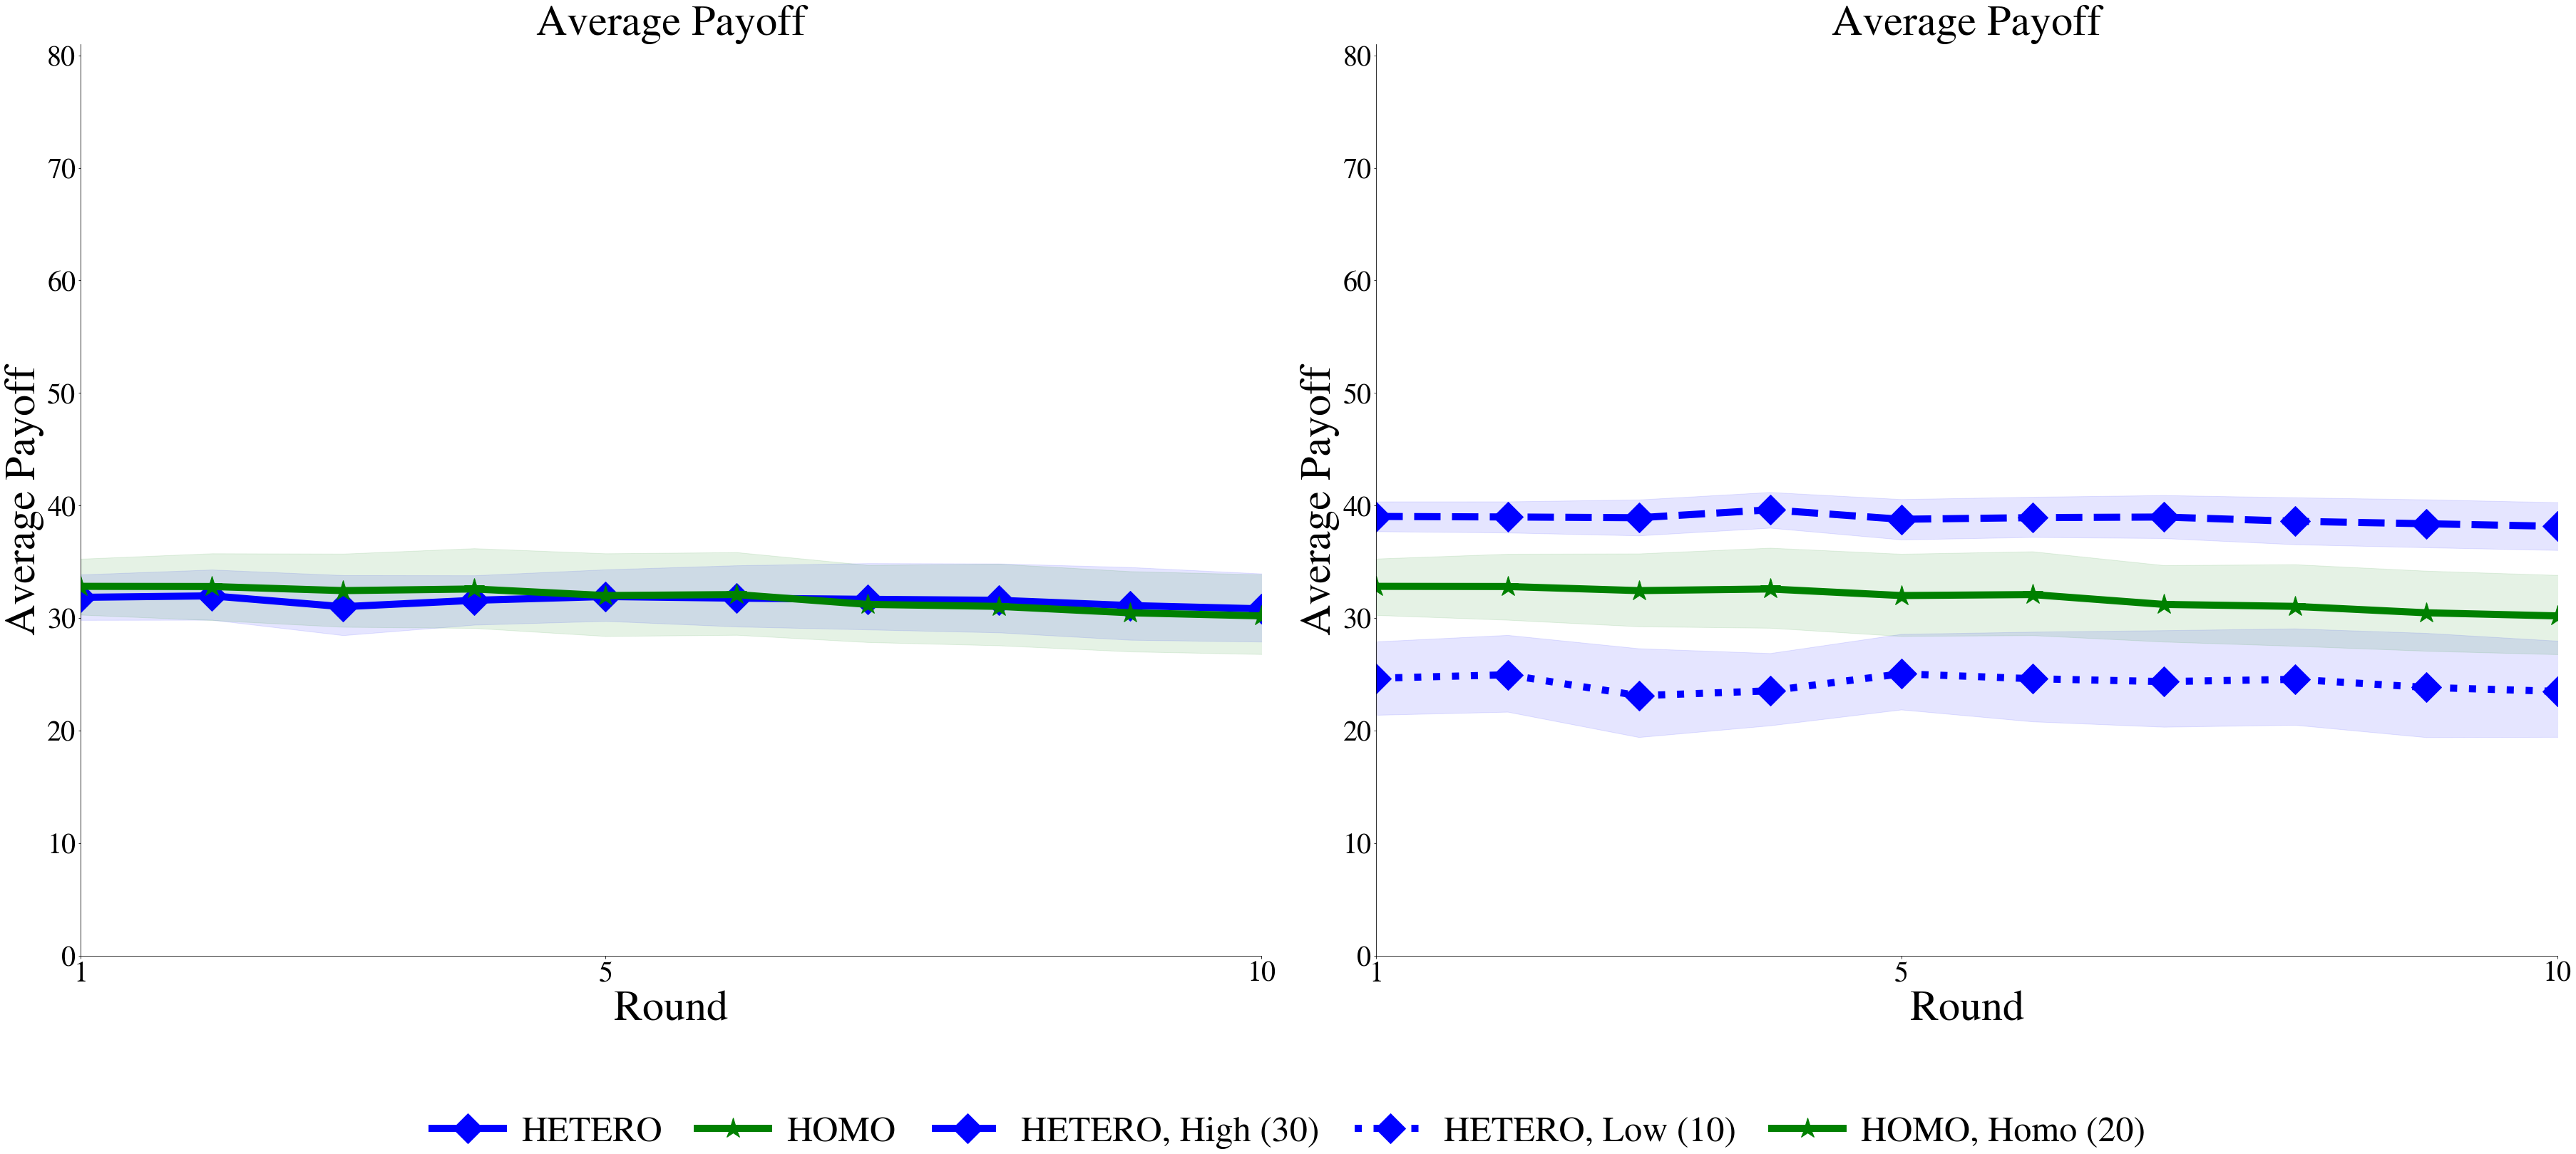

In [141]:
### This is to create the graph for all rounds

# Left graph for absolute value 
treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'player.payoff'

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)



# right graph for absolute value 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.payoff'
LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_xtick = np.array([0,4,9,14,19])
custom_ytick = np.arange(0,81,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO': 'D',
                    'HOMO': '*',
                     }
    
custom_markercolor = ['b', 'g', ]
custom_markerfacecolor = ['b', 'g']
custom_linestyle = ['-','-']

for j, yy in enumerate(treatment_list):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average Payoff', fontsize=60)
axes[0].set_title('Average Payoff', fontsize=60)

# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)  
# axes[0].tick_params(axis='x', labelsize=40)
# axes[0].tick_params(axis='y', labelsize=40)



# Right figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 81)
custom_ytick = np.arange(0,81,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'D',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['b','b', 'g', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']



for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[1].set_xlabel('Round', fontsize=60)
axes[1].set_ylabel('Average Payoff', fontsize=60)
axes[1].set_title('Average Payoff', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

# handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Only-Welfare.pdf', bbox_inches="tight" )  


### Local only (others)

If pulling all apps together, the difference is not very significant 

Just note: when only considering A2, HOMO > Hetero in the first 15 rounds (roughly), but maybe not significant (don't know yet)

### Only look at A1, homo is much smaller than hetero; All A, homo is slightly higher than hetero

### Temp Conclusion: Local only: HOMO may be slightly higher than HETERO (even so, maybe not significant) I don't observe a different in contribution between HOMO and HETERO communities. 


-[Local Only Environment](#Local-Only-Environment)

# Local + Global Environment

-[Contribution average time trend (both)](#Contribution-average-time-trend-(both))

-[Tradeoff between local and global](#Tradeoff-between-local-and-global)

-[% Join the club (both)](#%-Join-the-club-(both))

-[% Welfare (both)](#%-Welfare-(both))


-[Analyze Global + Local (Others)](#Analyze-Global-+-Local-(Others))



-Return : [Start Data Analysis](#Start-Data-Analysis)

subsession.round_number  subsession.period  subsession.sg  \
0                           1                  1              1   
1                           1                  1              1   
2                           1                  1              1   
3                           1                  1              1   
4                           1                  1              1   
...                       ...                ...            ...   
7035                       10                 10              1   
7036                       10                 10              1   
7037                       10                 10              1   
7038                       10                 10              1   
7039                       10                 10              1   

      player.id_in_group  player.endowment  player.join_club  \
0                      1             280.0                 1   
1                      5             280.0                 1   
2                      2             300.0                 0   
3                      6             280.0                 1   
4                      3              80.0                 1   
...                  ...               ...               ...   
7035                   6             180.0                 1   
7036                   3             180.0                 1   
7037                   7             180.0                 1   
7038                   4             180.0                 1   
7039                   8             180.0                 1   

      player.local_community  player.id_in_local  player.contribution_local  \
0                          1                   0                        8.0   
1                          2                   0                        5.0   
2                          1                   1                       10.0   
3                          2                   1                        6.0   
4                          1                   2                        3.0   
...                      ...                 ...                        ...   
7035                       0                   1                        0.0   
7036                       3                   2                        0.0   
7037                       0                   2                        0.0   
7038                       3                   3                        2.0   
7039                       0                   3                        0.0   

      player.contribution_global  ...  LocalTotal  ClubSize  SocialBenefitMax  \
0                            8.0  ...       300.0         7            5592.0   
1                            5.0  ...       300.0         7            5592.0   
2                            0.0  ...       300.0         7            5592.0   
3                            6.0  ...       300.0         7            5592.0   
4                            5.0  ...       300.0         7            5592.0   
...                          ...  ...         ...       ...               ...   
7035                         0.0  ...         0.0         8            6912.0   
7036                         0.0  ...         0.0         8            6912.0   
7037                         3.0  ...         0.0         8            6912.0   
7038                         9.0  ...         0.0         8            6912.0   
7039                        18.0  ...         0.0         8            6912.0   

      Efficiency2  Sequence  End_level  tot_cont_share        T_endw_comp  \
0        0.568670        B1  High (30)       57.142857  HETERO, High (30)   
1        0.568670        B1  High (30)       35.714286  HETERO, High (30)   
2        0.568670        B1  High (30)       33.333333  HETERO, High (30)   
3        0.568670        B1  High (30)       42.857143  HETERO, High (30)   
4        0.568670        B1   Low (10)      100.000000   HETERO, Low (10)   
...           ...       ...        ...          

In [25]:
x = data_Oppor[(data_Oppor['subsession.period']>=11) & 
           (data_Oppor['subsession.period']<=20)].groupby(['Treatment',
                                                           'FC'])['player.join_club','player.contribution_local','player.contribution_global'].mean()
print(x)
x.to_numpy()

              player.join_club  player.contribution_local  \
Treatment FC                                                
HETERO    20          0.887500                   1.826563   
          80          0.101562                   7.118750   
HOMO      20          0.990625                   1.039062   
          80          0.537500                   1.670313   

              player.contribution_global  
Treatment FC                              
HETERO    20                    5.759375  
          80                    0.240625  
HOMO      20                    6.645313  
          80                    4.256250  


C:\Users\xinxi\AppData\Local\Temp/ipykernel_22052/4003456648.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  x = data_Oppor[(data_Oppor['subsession.period']>=11) &


array([[0.8875   , 1.8265625, 5.759375 ],
       [0.1015625, 7.11875  , 0.240625 ],
       [0.990625 , 1.0390625, 6.6453125],
       [0.5375   , 1.6703125, 4.25625  ]])

### Contribution average time trend (both)

Return: 
 [Local + Global Environment](#Local-+-Global-Environment)


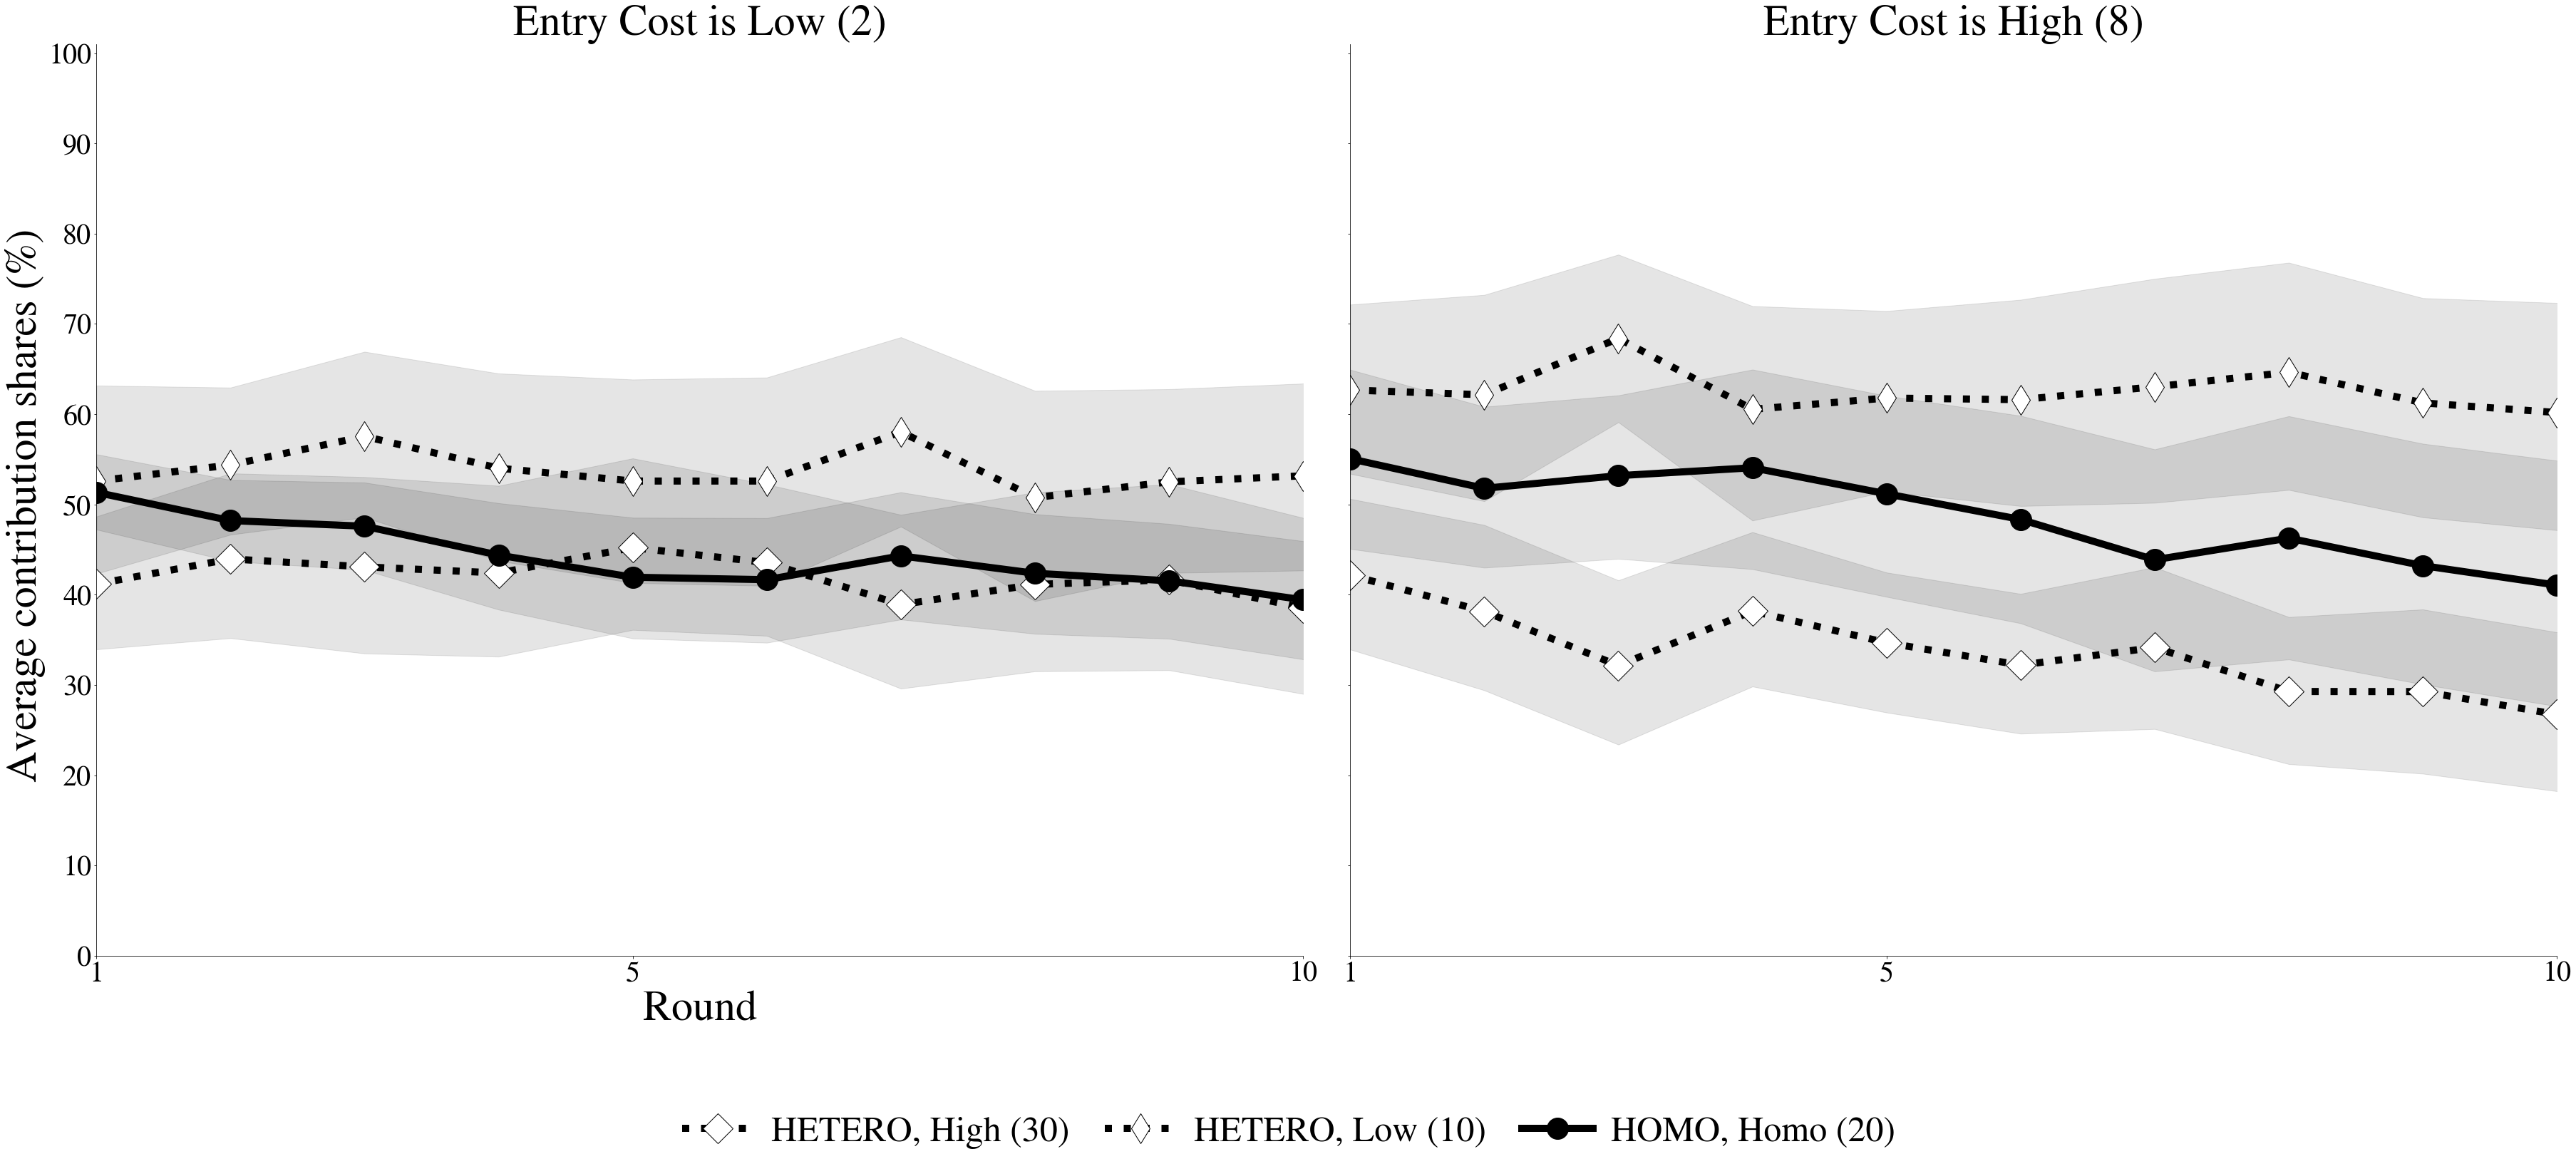

In [27]:
### This is to create the graph for all rounds
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution shares (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution.pdf', bbox_inches="tight" )  


In [28]:
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']

# For the simulated data

treatment_var = 'T_endw_comp'
var_of_interest =  'tot_cont_share'
LocalOnly = data_OpporSim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

dfSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_uSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)


# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_rSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lrSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_urSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)



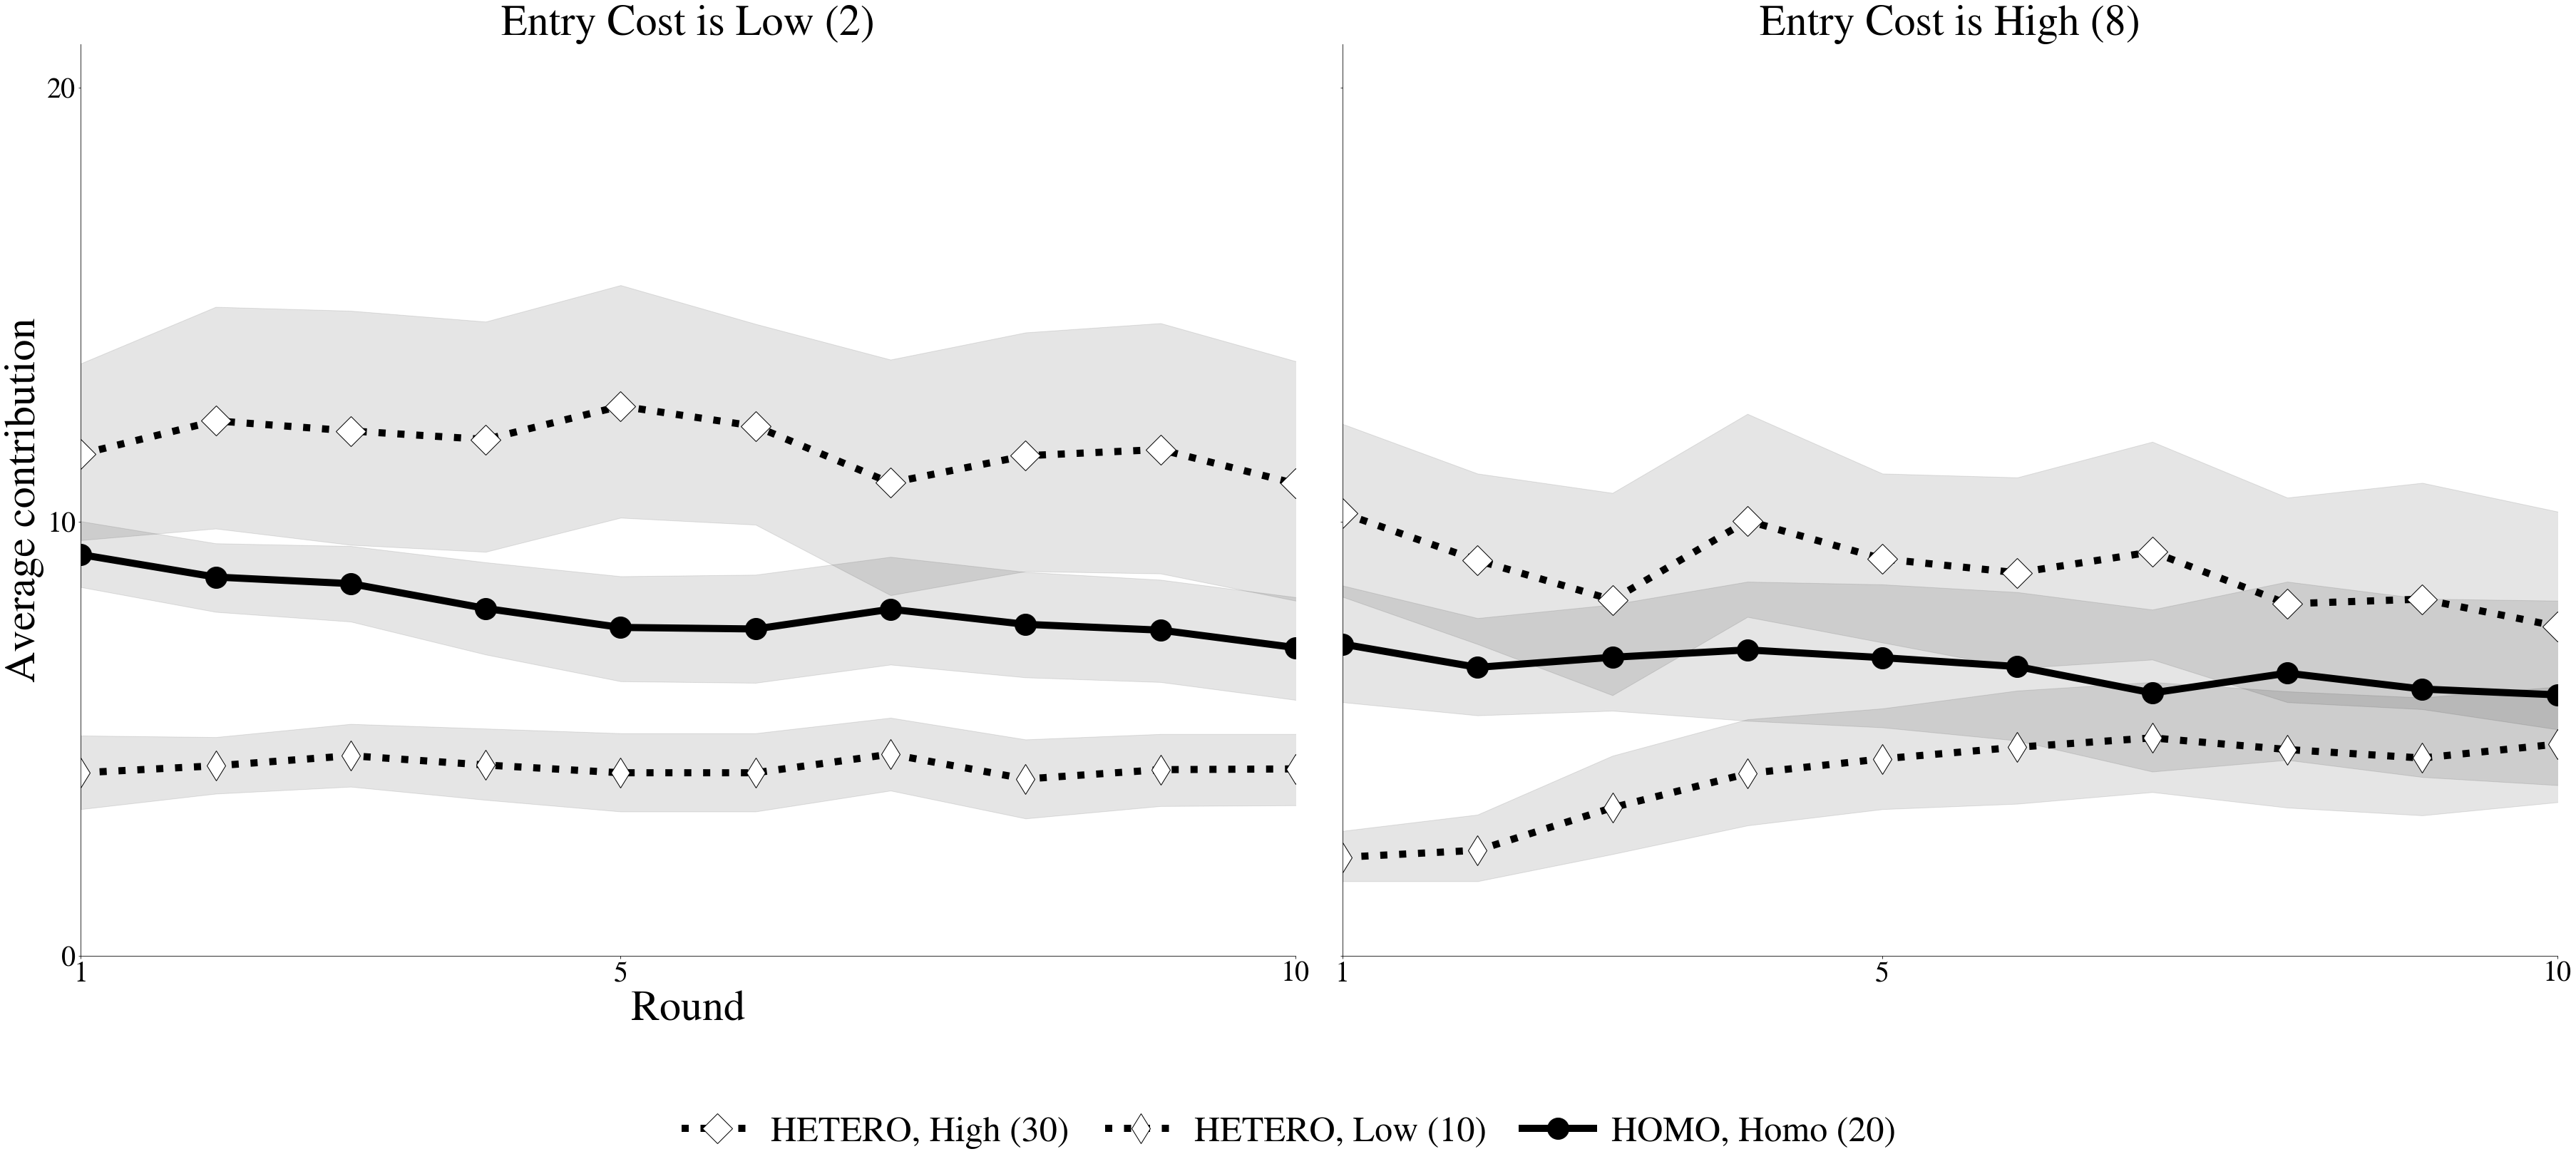

In [30]:
### Contribution Level
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'tot_contr'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0,9)
custom_ylim = (0, 21)
custom_ytick = np.arange(0,21,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution2.pdf', bbox_inches="tight" )  


### Tradeoff between local and global

Return: 

-[Local + Global Environment](#Local-+-Global-Environment)

In [31]:
treatment_list = ['HETERO','HOMO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
R_max = 10


LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


output = np.empty((4,2, 3))
output[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), v]
        print('index', i,j, t, v)
        output[i, j, 0]=pop_a.mean()
        output[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), v]
        print('index', i+2, j, t,v)
        output[i+2,j, 0]=pop_a.mean()
        output[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        
var_of_interest = 'endowment'
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()
total_e = np.empty((2,2,3))
total_e[:]=np.nan

for i,t in enumerate(treatment_list): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]
    total_e[i,0,0] =pop_a.mean()
    total_e[i, 0, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
    
    pop_b = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]
    total_e[i,1,0] = np.mean(pop_b)
    total_e[i, 1, 1:3]=bootstrap_ci(np.array(pop_b), 10000, np.mean)  
#     print(i,t)

index 0 0 HETERO player.contribution_local
index 0 1 HETERO player.contribution_global
index 1 0 HOMO player.contribution_local
index 1 1 HOMO player.contribution_global
index 2 0 HETERO player.contribution_local
index 2 1 HETERO player.contribution_global
index 3 0 HOMO player.contribution_local
index 3 1 HOMO player.contribution_global


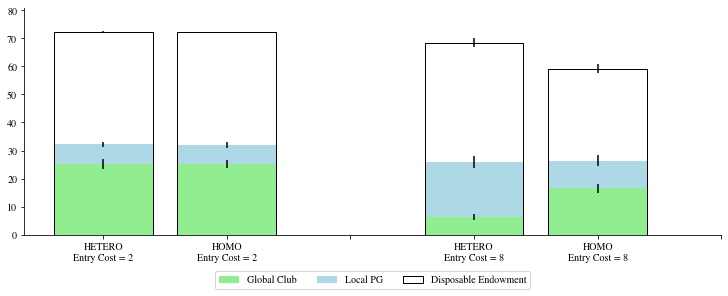

In [32]:
labels=  ['HETERO\nEntry Cost = 2', 'HOMO\nEntry Cost = 2', '','HETERO\nEntry Cost = 8', 'HOMO\nEntry Cost = 8', '']
labels2 = ["Global Club", "Local PG", "Disposable Endowment"]
colors = ['grey', 'white']
hatchs = ['', '']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))


axes.bar([0,1], output[[0,1],1, 0], 
             yerr=[output[[0,1],1,0]-output[[0,1],1,1], output[[0,1],1,2]-output[[0,1],1,0]],
             label=labels2[0],
             hatch=hatchs[0],
             color = 'lightgreen')

axes.bar([0,1], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
          label=labels2[1],
         bottom = output[[0,1],1, 0], 
             hatch=hatchs[1],
             color = 'lightblue')

axes.bar([0,1], total_e[[0,1],0, 0], 
         yerr=[total_e[[0,1],0,0]-total_e[[0,1],0,1], total_e[[0,1],0,2]-total_e[[0,1],0,0]],
          fill=False, label=labels2[2],
        edgecolor = 'black')

axes.bar([3,4], output[[2,3],1, 0], 
             yerr=[output[[2,3],1,0]-output[[2,3],1,1], output[[2,3],1,2]-output[[2,3],1,0]],
             label=labels2[0],
             hatch=hatchs[0],
             color = 'lightgreen')

axes.bar([3,4], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
          label=labels2[1],
         bottom = output[[2,3],1, 0], 
             hatch=hatchs[1],
             color ='lightblue' )

axes.bar([3,4], total_e[[0,1],1, 0], 
         yerr=[total_e[[0,1],1,0]-total_e[[0,1],1,1], total_e[[0,1],1,2]-total_e[[0,1],1,0]],
          fill=False, label=labels2[2],
        edgecolor = 'black')

axes.set_xticks(x)
axes.set_xticklabels(labels)
axes.set_ylim(0,81)
axes.legend( labels2, bbox_to_anchor=(.5,-.2), loc="center" , ncol=3)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff-barOnly.pdf', bbox_inches="tight" )  


In [85]:
 output[[2,3],1, 0]/total_e[[0,1],1, 0]
    

array([0.27898987, 0.09123593])

In [81]:
data_Oppor.columns

Index(['subsession.round_number', 'subsession.period', 'subsession.sg',
       'player.id_in_group', 'player.endowment', 'player.join_club',
       'player.local_community', 'player.id_in_local',
       'player.contribution_local', 'player.contribution_global',
       'player.total_contribution_local', 'player.individual_share_local',
       'player.payoff', 'group.id_in_subsession', 'group.FC',
       'group.total_contribution_global', 'group.individual_share_global',
       'session.code', 'Treatment', 'FC', 'participant.code', 'endowment',
       'endowment_j', 'endowment_nj', 'tot_contr', 'privateAcc',
       'FC_globalagg', 'player.payoff_globalagg', 'player.endowment_globalagg',
       'Efficiency', 'player.payoff_globalMax', 'ClubTotal', 'LocalTotal',
       'ClubSize', 'SocialBenefitMax', 'Efficiency2', 'Sequence', 'End_level',
       'tot_cont_share', 'T_endw_comp', 'local_share', 'global_share'],
      dtype='object')

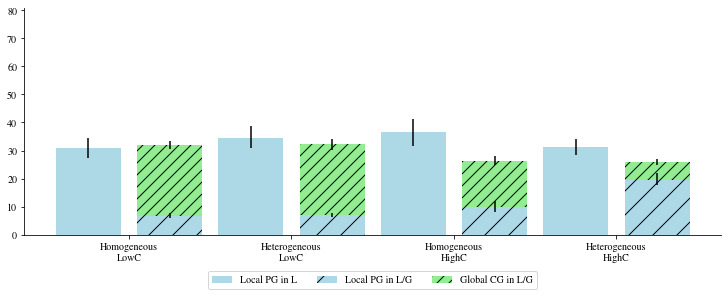

In [97]:
data_Oppor['endowment']


0       28.0
1       28.0
2       30.0
3       28.0
4        8.0
        ... 
7035    18.0
7036    18.0
7037    18.0
7038    18.0
7039    18.0
Name: endowment, Length: 7040, dtype: float64

In [116]:
#This is to produce percentage
# % This is created to produce a bar graph for local public good contribution only, comparing L and L/G environments

treatment_list = ['HOMO','HETERO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
v3= 'endowment'
var_of_interest =  [var_l, var_g,v3]
R_max = 10

var_of_interest2 =  [var_l, var_g]
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest ].sum().reset_index()


output = np.empty((4,2, 3))
output[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest2):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), v] / LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), 'endowment']
       
        print('index', i,j, t, v)
        output[i, j, 0]=pop_a.mean()
        output[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest2):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), v]/ LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), 'endowment']
        print('index', i+2, j, t,v)
        output[i+2,j, 0]=pop_a.mean()
        output[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        

        
treatment_list =  ['HOMO','HETERO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
v3= 'endowment'
var_of_interest =  [var_l, var_g,v3]
R_max = 10


LocalOnly = data_noOppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


        

output_noC = np.empty((4,2, 3))
output_noC[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest2):
        pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==20), v]/ LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==20), v3]
        print('index', i,j, t, v)
        output_noC[i, j, 0]=pop_a.mean()
        output_noC[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest2):
        pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==80), v]/ LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==80), v3]
        print('index', i+2, j, t,v)
        output_noC[i+2,j, 0]=pop_a.mean()
        output_noC[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   



index 0 0 HOMO player.contribution_local
index 0 1 HOMO player.contribution_global
index 1 0 HETERO player.contribution_local
index 1 1 HETERO player.contribution_global
index 2 0 HOMO player.contribution_local
index 2 1 HOMO player.contribution_global
index 3 0 HETERO player.contribution_local
index 3 1 HETERO player.contribution_global
index 0 0 HOMO player.contribution_local
index 0 1 HOMO player.contribution_global
index 1 0 HETERO player.contribution_local
index 1 1 HETERO player.contribution_global
index 2 0 HOMO player.contribution_local
index 2 1 HOMO player.contribution_global
index 3 0 HETERO player.contribution_local
index 3 1 HETERO player.contribution_global


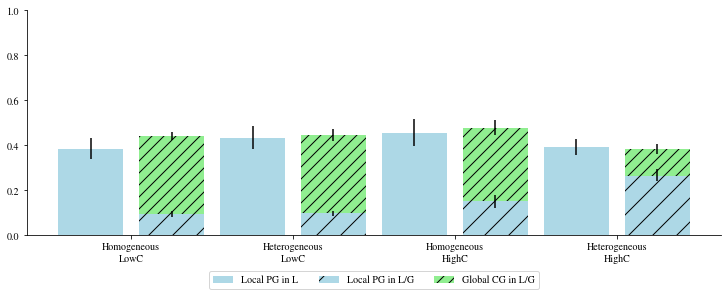

In [118]:

labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
labels_both = ["Local PG in L", "Local PG in L/G", "Global CG in L/G"]
colors = ['grey', 'white']
hatchs = ['', '/','//']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))



# No club
axes.bar([-.25,.75], output_noC[[0,1],0, 0], 
             yerr=[output_noC[[0,1],0,0]-output_noC[[0,1],0,1], output_noC[[0,1],0,2]-output_noC[[0,1],0,0]],
          label=labels_both[0],
         bottom = output_noC[[0,1],1, 0], 
             hatch=hatchs[0],
             color = 'lightblue', width=.4)
# With club
axes.bar([0.25,1.25], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color = 'lightblue', width=.4)


axes.bar([0.25,1.25], output[[0,1],1, 0], 
             yerr=[output[[0,1],1,0]-output[[0,1],1,1], output[[0,1],1,2]-output[[0,1],1,0]],
         bottom= output[[0,1],0, 0],
             label=labels2[2],
             hatch=hatchs[2],
             color = 'lightgreen', width=.4)

# axes.bar([0,1], total_e[[0,1],0, 0], 
#          yerr=[total_e[[0,1],0,0]-total_e[[0,1],0,1], total_e[[0,1],0,2]-total_e[[0,1],0,0]],
#           fill=False, label=labels2[2],
#         edgecolor = 'black')

# No club
axes.bar([1.75, 2.75], output_noC[[2,3],0, 0], 
             yerr=[output_noC[[2,3],0,0]-output_noC[[2,3],0,1], output_noC[[2,3],0,2]-output_noC[[2,3],0,0]],
          label=labels_both[0],
         bottom = output_noC[[2,3],1, 0], 
             hatch=hatchs[0],
             color ='lightblue' ,width=.4 )
# With club
axes.bar([2.25,3.25], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color ='lightblue' ,width=.4 )

axes.bar([2.25,3.25], output[[2,3],1, 0], 
             yerr=[output[[2,3],1,0]-output[[2,3],1,1], output[[2,3],1,2]-output[[2,3],1,0]],
             label=labels2[0],
             hatch=hatchs[2],
             bottom=output[[2,3],0, 0],
             color = 'lightgreen' ,width=.4 )


# axes.bar([3,4], total_e[[0,1],1, 0], 
#          yerr=[total_e[[0,1],1,0]-total_e[[0,1],1,1], total_e[[0,1],1,2]-total_e[[0,1],1,0]],
#           fill=False, label=labels2[2],
#         edgecolor = 'black')

axes.set_xticks(x)
axes.set_xticklabels(labels)
axes.set_ylim(0,1)
axes.legend( labels_both, bbox_to_anchor=(.5,-.2), loc="center" , ncol=3)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

fig.savefig('..\\Output\\01-group-data-Dec-2022-Contribution-Both-Compare-relative.pdf', bbox_inches="tight" )  


In [120]:
data_Oppor.columns

Index(['subsession.round_number', 'subsession.period', 'subsession.sg',
       'player.id_in_group', 'player.endowment', 'player.join_club',
       'player.local_community', 'player.id_in_local',
       'player.contribution_local', 'player.contribution_global',
       'player.total_contribution_local', 'player.individual_share_local',
       'player.payoff', 'group.id_in_subsession', 'group.FC',
       'group.total_contribution_global', 'group.individual_share_global',
       'session.code', 'Treatment', 'FC', 'participant.code', 'endowment',
       'endowment_j', 'endowment_nj', 'tot_contr', 'privateAcc',
       'FC_globalagg', 'player.payoff_globalagg', 'player.endowment_globalagg',
       'Efficiency', 'player.payoff_globalMax', 'ClubTotal', 'LocalTotal',
       'ClubSize', 'SocialBenefitMax', 'Efficiency2', 'Sequence', 'End_level',
       'tot_cont_share', 'T_endw_comp', 'local_share', 'global_share'],
      dtype='object')

In [137]:
#This is to produce group average payoffs 
# % This is created to produce a bar graph for local public good contribution only, comparing L and L/G environments

treatment_list = ['HOMO','HETERO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.payoff'

var_of_interest =  [var_l]
R_max = 10


LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest ].mean().reset_index()


output = np.empty((4,2, 3))
output[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), v] 
       
        print('index', i,j, t, v)
        output[i, j, 0]=pop_a.mean()
        output[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), v]
        print('index', i+2, j, t,v)
        output[i+2,j, 0]=pop_a.mean()
        output[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        

        
treatment_list =  ['HOMO','HETERO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.payoff'

var_of_interest =  [var_l]
R_max = 10


LocalOnly = data_noOppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()


        

output_noC = np.empty((4,2, 3))
output_noC[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==20), v]
        print('index', i,j, t, v)
        output_noC[i, j, 0]=pop_a.mean()
        output_noC[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&
                                (LocalOnly['subsession.period']<=R_max)&
                                (LocalOnly['FC']==80), v]
        print('index', i+2, j, t,v)
        output_noC[i+2,j, 0]=pop_a.mean()
        output_noC[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   



index 0 0 HOMO player.payoff
index 1 0 HETERO player.payoff
index 2 0 HOMO player.payoff
index 3 0 HETERO player.payoff
index 0 0 HOMO player.payoff
index 1 0 HETERO player.payoff
index 2 0 HOMO player.payoff
index 3 0 HETERO player.payoff


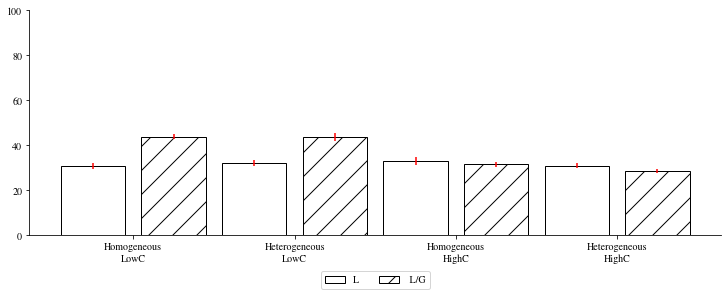

In [150]:

labels=  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
labels_both = ["L", " L/G"]
colors = ['grey', 'white']
hatchs = ['', '/']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))



# No club
axes.bar([-.25,.75], output_noC[[0,1],0, 0], 
             yerr=[output_noC[[0,1],0,0]-output_noC[[0,1],0,1], output_noC[[0,1],0,2]-output_noC[[0,1],0,0]],
          label=labels_both[0],
             hatch=hatchs[0],
             color = 'white', width=.4, edgecolor = 'black',ecolor='red')
# With club
axes.bar([0.25,1.25], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color = 'white', width=.4, edgecolor = 'black',ecolor='red')

# axes.bar([0,1], total_e[[0,1],0, 0], 
#          yerr=[total_e[[0,1],0,0]-total_e[[0,1],0,1], total_e[[0,1],0,2]-total_e[[0,1],0,0]],
#           fill=False, label=labels2[2],
#          fill=False, edgecolor = 'black')

# No club
axes.bar([1.75, 2.75], output_noC[[2,3],0, 0], 
             yerr=[output_noC[[2,3],0,0]-output_noC[[2,3],0,1], output_noC[[2,3],0,2]-output_noC[[2,3],0,0]],
          label=labels_both[0], 
             hatch=hatchs[0],
             color ='white' ,width=.4 , edgecolor = 'black',ecolor='red')
# With club
axes.bar([2.25,3.25], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
          label=labels_both[1], 
             hatch=hatchs[1],
             color ='white' ,width=.4 , edgecolor = 'black',ecolor='red')

# axes.bar([3,4], total_e[[0,1],1, 0], 
#          yerr=[total_e[[0,1],1,0]-total_e[[0,1],1,1], total_e[[0,1],1,2]-total_e[[0,1],1,0]],
#           fill=False, label=labels2[2],
#         edgecolor = 'black')

axes.set_xticks(x)
axes.set_xticklabels(labels)
axes.set_ylim(0,100)
axes.legend( labels_both, bbox_to_anchor=(.5,-.2), loc="center" , ncol=3)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

fig.savefig('..\\Output\\01-group-data-Dec-2022-group-avg-payoffs-absolute.pdf', bbox_inches="tight" )  


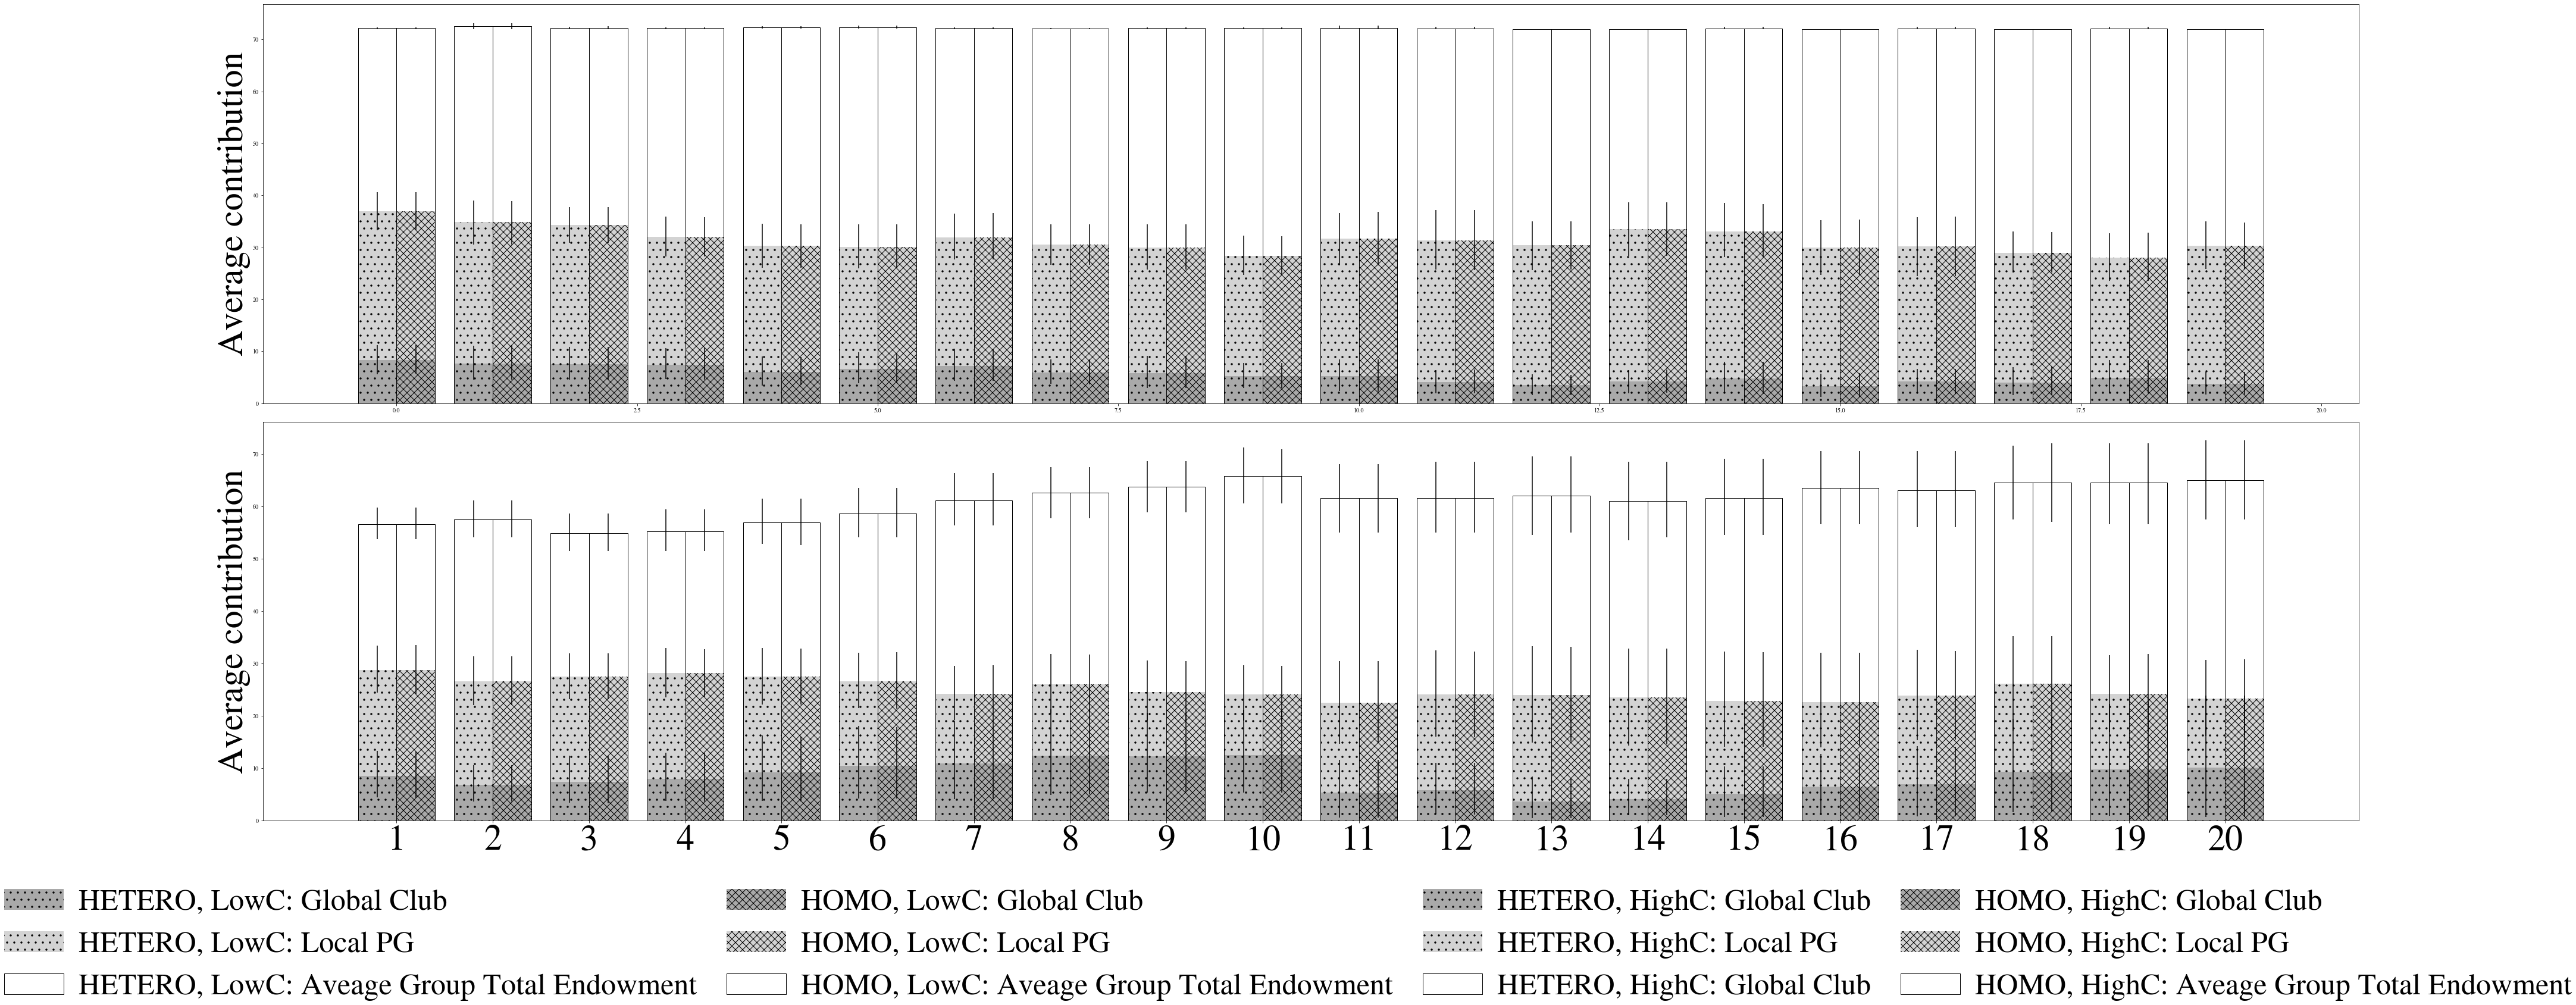

In [22]:
### Separate data and the figure drawing
pd.set_option('plotting.backend', 'matplotlib')

fig, axes = plt.subplots(nrows=2, ncols=1,  sharex=False,  sharey=False,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# First figure
# labels=  ['HETERO\n $\hspace{5}$ Entry Cost = 2', 'HOMO', '','HETERO\n $\hspace{5}$ Entry Cost = 8', 'HOMO', '']
# labels2 = ["Global Club", "Local PG", "Aveage Group Total Endowment"]
# colors = ['grey', 'white']
# hatchs = ['\\', '//']


labels = [str(i+1) for i in range(R_max)]
labels2 = ["Global Club", "Local PG", "Aveage Group Total Endowment"]
colors = ['grey', 'white']
hatchs = ['.', 'xx']

x = np.arange(len(labels))
width = 0.4
x1 = [i-width/2 for i in range(R_max)]
x2 = [i+width/2 for i in range(R_max)]

# Left panel: fc =2 
# HETERO
axes[0].bar(x1,output[0,0,0,:,0], width, 
             yerr=[output[0,0,0,:,0]-output[0,0,0,:,1],output[0,0,0,:,2]-output[0,0,0,:,0]],
             label='HETERO, ' + 'LowC: ' + labels2[0],
             hatch=hatchs[0],
             color = 'darkgrey')

axes[0].bar(x1, output[0,0,1,:,0], width, 
             yerr=[output[0,0,1,:,0]-output[0,0,1,:,1], output[0,0,1,:,2]-output[0,0,1,:,0]],
          label='HETERO, ' + 'LowC: ' + labels2[1],
         bottom = output[0,0,0,:,0], 
             hatch=hatchs[0],
             color = 'lightgrey')

axes[0].bar(x1, output[0,0,2,:,0], width, 
         yerr=[ output[0,0,2,:,0]- output[0,0,2,:,1],  output[0,0,2,:,2]- output[0,0,2,:,0]],
          fill=False, label='HETERO, ' + 'LowC: ' + labels2[2],
        edgecolor = 'black')

# HOMO
axes[0].bar(x2,output[0,1,0,:,0], width, 
             yerr=[output[0,1,0,:,0]-output[0,1,0,:,1],output[0,1,0,:,2]-output[0,1,0,:,0]],
             label='HOMO, ' + 'LowC: ' + labels2[0],
             hatch=hatchs[1],
             color = 'darkgrey')

axes[0].bar(x2, output[0,1,1,:,0], width, 
             yerr=[output[0,1,1,:,0]-output[0,1,1,:,1], output[0,1,1,:,2]-output[0,1,1,:,0]],
          label='HOMO, ' + 'LowC: ' + labels2[1],
         bottom = output[0,1,0,:,0], 
             hatch=hatchs[1],
             color = 'lightgrey')

axes[0].bar(x2, output[0,1,2,:,0], width, 
         yerr=[ output[0,1,2,:,0]- output[0,1,2,:,1],  output[0,1,2,:,2]- output[0,1,2,:,0]],
          fill=False, label='HOMO, ' + 'LowC: ' + labels2[2],
        edgecolor = 'black')


# Right panel
# HETERO
axes[1].bar(x1,output[1,0,0,:,0], width, 
             yerr=[output[1,0,0,:,0]-output[1,0,0,:,1],output[1,0,0,:,2]-output[1,0,0,:,0]],
             label='HETERO, ' + 'HighC: ' + labels2[0],
             hatch=hatchs[0],
             color = 'darkgrey')

axes[1].bar(x1, output[1,0,1,:,0], width, 
             yerr=[output[1,0,1,:,0]-output[1,0,1,:,1], output[1,0,1,:,2]-output[1,0,1,:,0]],
          label='HETERO, ' + 'HighC: ' + labels2[1],
         bottom = output[1,0,0,:,0], 
             hatch=hatchs[0],
             color = 'lightgrey')

axes[1].bar(x1, output[1,0,2,:,0], width, 
         yerr=[ output[1,0,2,:,0]- output[1,0,2,:,1],  output[1,0,2,:,2]- output[1,0,2,:,0]],
          fill=False, label='HETERO, ' + 'HighC: ' + labels2[0],
        edgecolor = 'black')

# HOMO
axes[1].bar(x2,output[1,1,0,:,0], width, 
             yerr=[output[1,1,0,:,0]-output[1,1,0,:,1],output[1,1,0,:,2]-output[1,1,0,:,0]],
             label='HOMO, ' + 'HighC: ' + labels2[0],
             hatch=hatchs[1],
             color = 'darkgrey')

axes[1].bar(x2, output[1,1,1,:,0], width, 
             yerr=[output[1,1,1,:,0]-output[1,1,1,:,1], output[1,1,1,:,2]-output[1,1,1,:,0]],
          label='HOMO, ' + 'HighC: ' + labels2[1],
         bottom = output[1,1,0,:,0], 
             hatch=hatchs[1],
             color = 'lightgrey')

axes[1].bar(x2, output[1,1,2,:,0], width, 
         yerr=[ output[1,1,2,:,0]- output[1,1,2,:,1],  output[1,1,2,:,2]- output[1,1,2,:,0]],
          fill=False, label='HOMO, ' + 'HighC: ' + labels2[2],
        edgecolor = 'black')


axes[1].set_xticks(x)
axes[1].set_xticklabels(labels,multialignment='center',fontsize=60)

axes[0].set_ylabel('Average contribution', fontsize=60)
axes[1].set_ylabel('Average contribution', fontsize=60)

# for i in range(3):
#     axes[i].spines['top'].set_visible(False)
#     axes[i].spines['right'].set_visible(False)  
#     axes[i].tick_params(axis='x', labelsize=40)
#     axes[i].tick_params(axis='y', labelsize=40)


# handles, labels = axes[0].get_legend_handles_labels() 
# handles2, labels2 = axes[1].get_legend_handles_labels() 
# fig.legend(handles[:3]+handles2, labels[0:3]+labels2, bbox_to_anchor=(.5,-.1), loc="center" , ncol=4 , fontsize=50,
#                borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.legend( bbox_to_anchor=(.5,-.1), loc="center" , ncol=4 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff.pdf', bbox_inches="tight" )  


In [152]:


treatment_list = ['HETERO','HOMO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
R_max = 10

# Prepare for the first subfigure (sum)
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


output = np.empty((4,2, 3))
output[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), v]
        print('index', i,j, t, v)
        output[i, j, 0]=pop_a.mean()
        output[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), v]
        print('index', i+2, j, t,v)
        output[i+2,j, 0]=pop_a.mean()
        output[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        
var_of_interest = 'endowment'
LocalGlobal = data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()
total_e = np.empty((2,2,3))
total_e[:]=np.nan

for i,t in enumerate(treatment_list): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]
    total_e[i,0,0] =pop_a.mean()
    total_e[i, 0, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
    
    pop_b = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]
    total_e[i,1,0] = np.mean(pop_b)
    total_e[i, 1, 1:3]=bootstrap_ci(np.array(pop_b), 10000, np.mean)  
#     print(i,t)

# Treatment by endowment (mean)
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


# Left graph for FC=2
output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_l,treatment_var,treatment_list , 20)

df1 = pd.DataFrame(output1[0,:,:], columns = treatment_list)
df_ci_l1 = pd.DataFrame(output1[1,:,:], columns = treatment_list)
df_ci_u1 = pd.DataFrame(output1[2,:,:], columns = treatment_list)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_g,treatment_var,treatment_list , 20)

df2 = pd.DataFrame(output2[0,:,:], columns = treatment_list)
df_ci_l2 = pd.DataFrame(output2[1,:,:], columns = treatment_list)
df_ci_u2 = pd.DataFrame(output2[2,:,:], columns = treatment_list)


# right graph for absolute value 

output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_l,treatment_var,treatment_list , 20)

dfr1 = pd.DataFrame(output1[0,:,:], columns = treatment_list)
df_ci_lr1 = pd.DataFrame(output1[1,:,:], columns = treatment_list)
df_ci_ur1 = pd.DataFrame(output1[2,:,:], columns = treatment_list)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_g,treatment_var,treatment_list , 20)

dfr2 = pd.DataFrame(output2[0,:,:], columns = treatment_list)
df_ci_lr2 = pd.DataFrame(output2[1,:,:], columns = treatment_list)
df_ci_ur2 = pd.DataFrame(output2[2,:,:], columns = treatment_list)

index 0 0 HETERO player.contribution_local
index 0 1 HETERO player.contribution_global
index 1 0 HOMO player.contribution_local
index 1 1 HOMO player.contribution_global
index 2 0 HETERO player.contribution_local
index 2 1 HETERO player.contribution_global
index 3 0 HOMO player.contribution_local
index 3 1 HOMO player.contribution_global


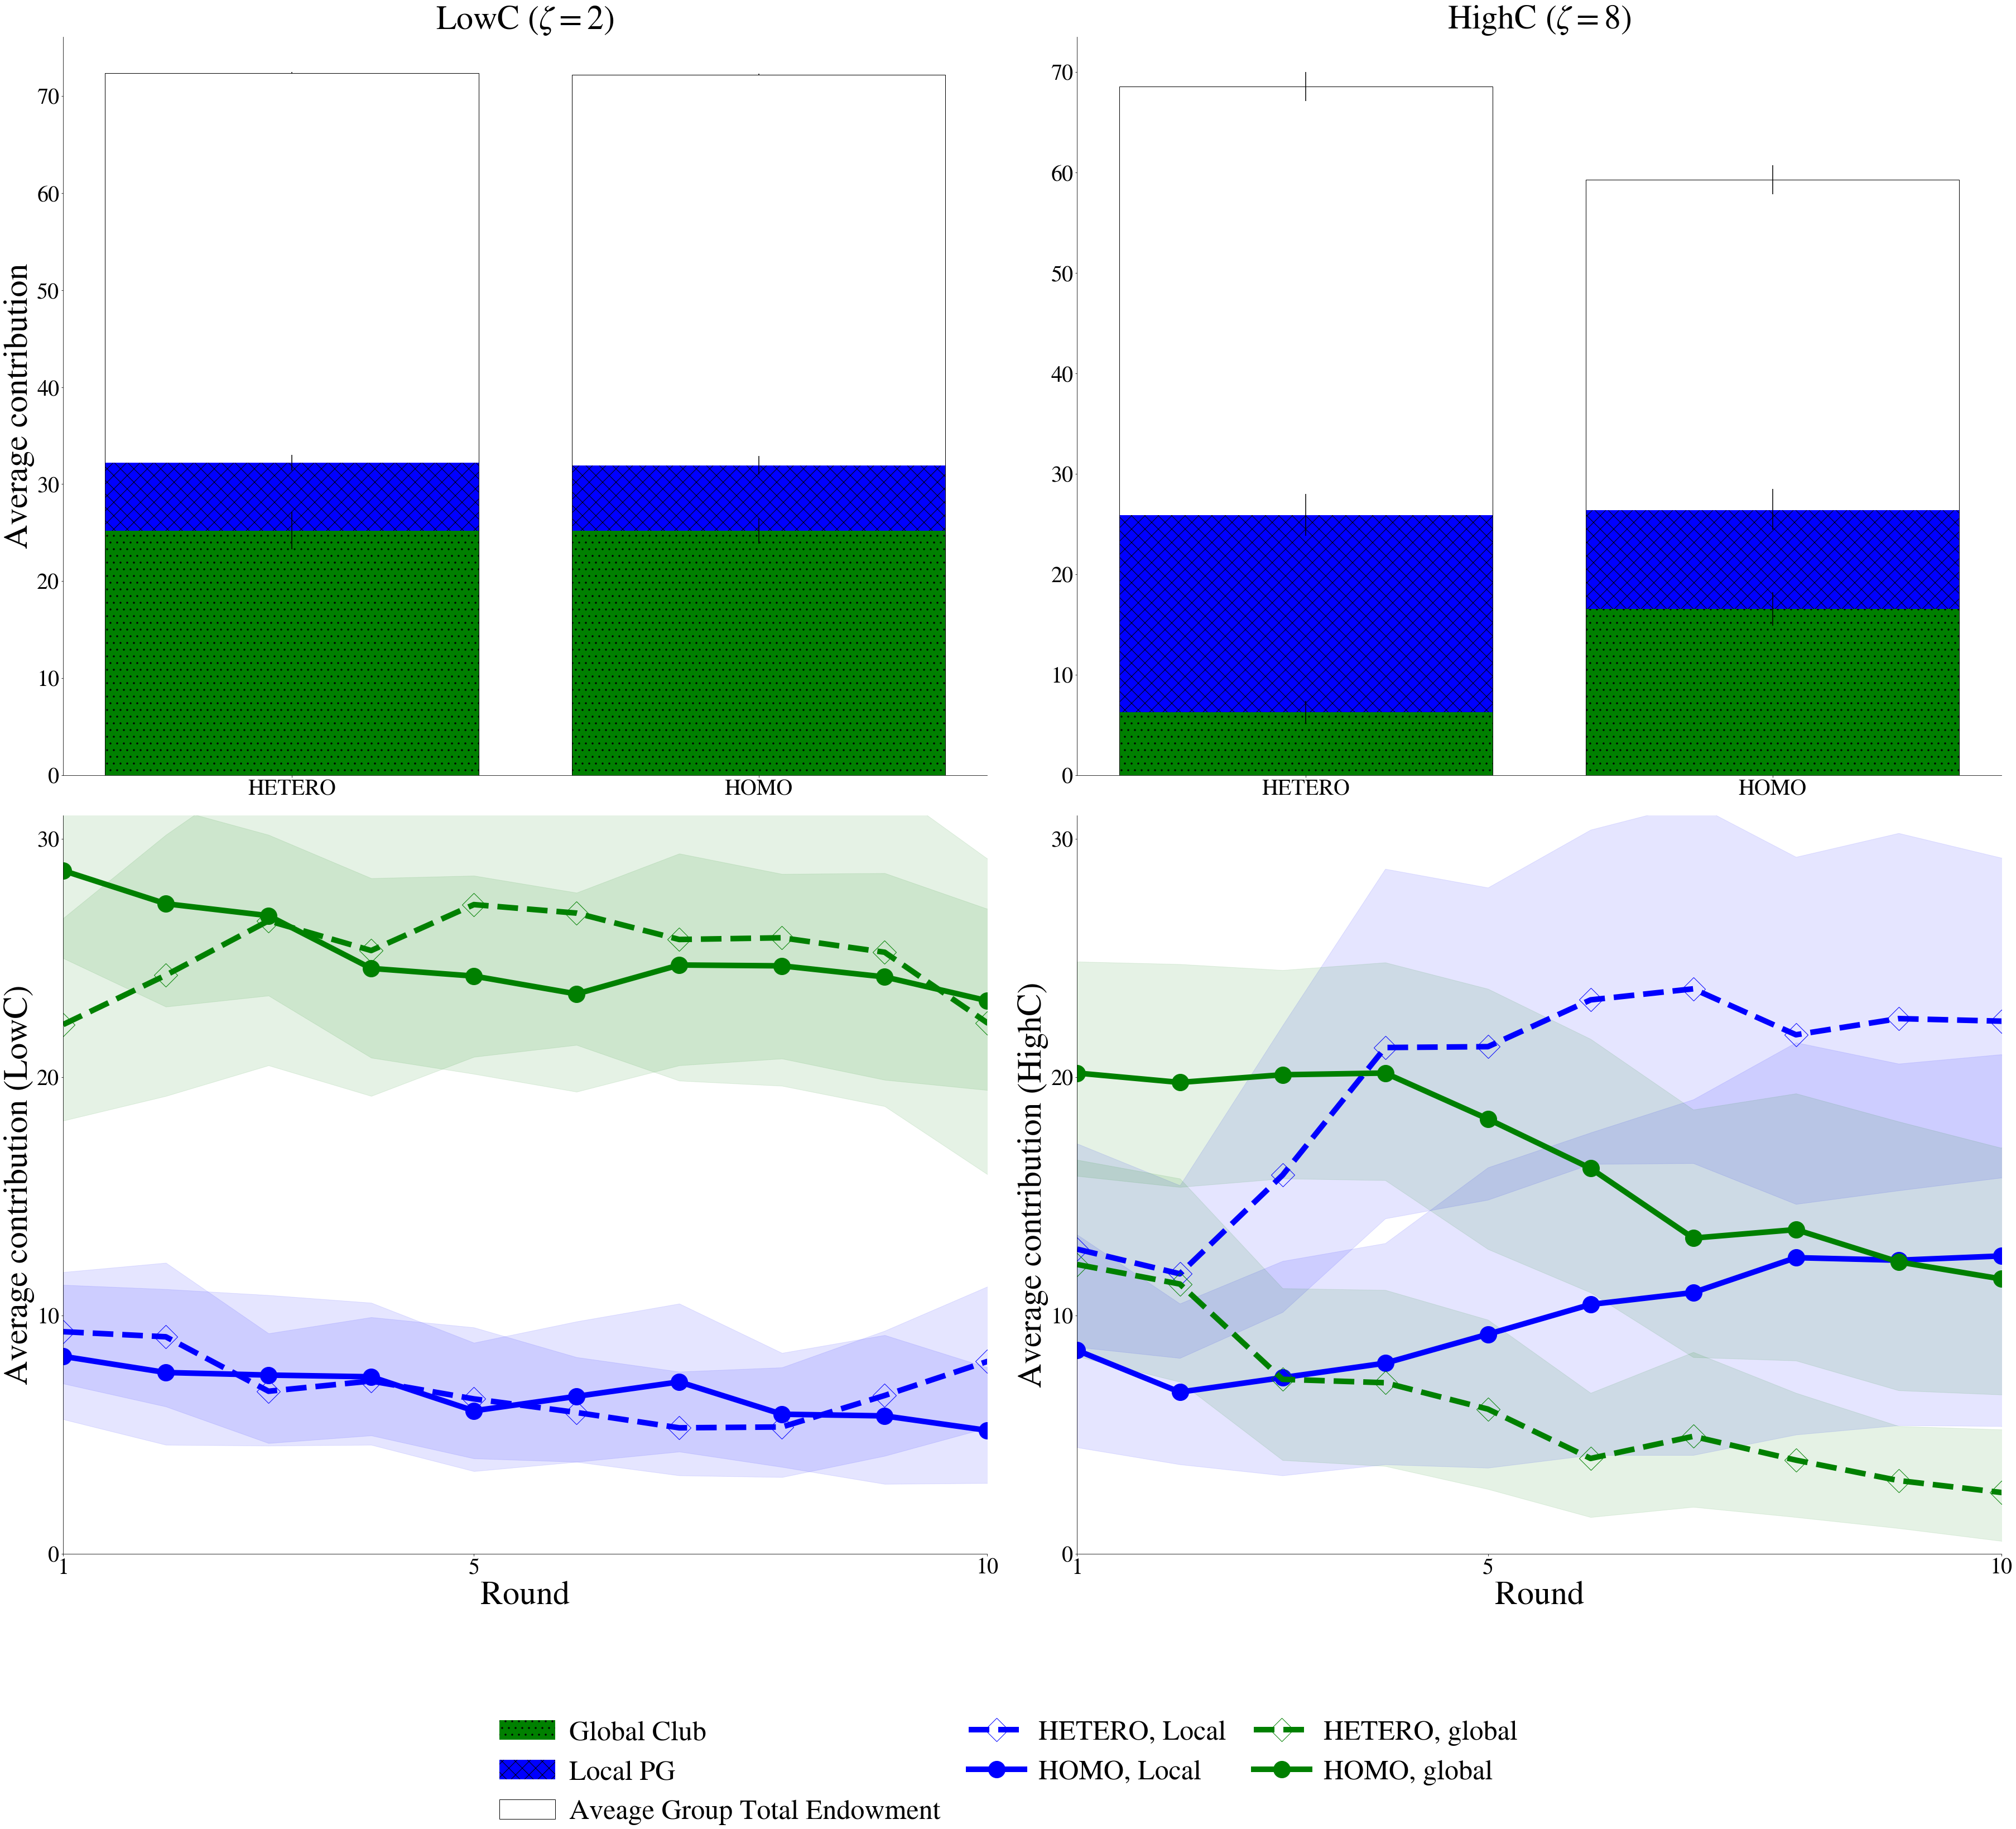

In [153]:
### Separate data and the figure drawing
pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=2, ncols=2,  sharex=False,  
#                          sharey=False,  
                         constrained_layout=True, figsize=(50, 40))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Top 2 figures
# labels=  ['HETERO\n $\hspace{25}$ LowC ($\zeta = 2$)', 'HOMO', '',
#           'HETERO\n $\hspace{25}$ HighC ($\zeta = 8$)', 'HOMO', '']
labels=  ['HETERO', 'HOMO', '',
          'HETERO', 'HOMO', '']
labels2 = ["Global Club", "Local PG", "Aveage Group Total Endowment"]
colors = ['grey', 'white']
hatchs = ['.', 'x']
x = np.arange(2)

axes[0,0].bar([0,1], output[[0,1],1, 0], 
             yerr=[output[[0,1],1,0]-output[[0,1],1,1], output[[0,1],1,2]-output[[0,1],1,0]],
             label=labels2[0],
             hatch=hatchs[0],
             color = 'green')

axes[0,0].bar([0,1], output[[0,1],0, 0], 
             yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
          label=labels2[1],
         bottom = output[[0,1],1, 0], 
             hatch=hatchs[1],
             color = 'blue')

axes[0,0].bar([0,1], total_e[[0,1],0, 0], 
         yerr=[total_e[[0,1],0,0]-total_e[[0,1],0,1], total_e[[0,1],0,2]-total_e[[0,1],0,0]],
          fill=False, label=labels2[2],
        edgecolor = 'black')

axes[0,1].bar([0,1], output[[2,3],1, 0], 
             yerr=[output[[2,3],1,0]-output[[2,3],1,1], output[[2,3],1,2]-output[[2,3],1,0]],
             label=labels2[0],
             hatch=hatchs[0],
             color = 'green')

axes[0,1].bar([0,1], output[[2,3],0, 0], 
             yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
          label=labels2[1],
         bottom = output[[2,3],1, 0], 
             hatch=hatchs[1],
             color = 'blue')

axes[0,1].bar([0,1], total_e[[0,1],1, 0], 
         yerr=[total_e[[0,1],1,0]-total_e[[0,1],1,1], total_e[[0,1],1,2]-total_e[[0,1],1,0]],
          fill=False, label=labels2[2],
        edgecolor = 'black')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(labels[0:2],multialignment='center',fontsize=60)
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(labels[3:5],multialignment='center',fontsize=60)
axes[0,0].set_ylabel('Average contribution', fontsize=60)

axes[0,0].set_title('LowC ($\zeta = 2$)', fontsize=60)
axes[0,1].set_title('HighC ($\zeta = 8$)', fontsize=60)

# Bottom 2 figures
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 31)
custom_ytick = np.arange(0,31,step=10)
custom_xtick = np.array([0,4,9,14,19])
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[1,0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    

custom_markercolor = ['blue', 'blue', ]
custom_markerfacecolor = ['none', 'blue']
custom_linestyle = ['--','-']

for j, yy in enumerate(treatment_list):
    axes[1,0].plot(df1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1,0].fill_between(df_ci_u1.index, df_ci_u1[yy],df_ci_l1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    


custom_markercolor = ['green','green', ]
custom_markerfacecolor = ['none', 'green']
custom_linestyle = ['--','-']


for j, yy in enumerate(treatment_list):
    axes[1,0].plot(df2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1,0].fill_between(df_ci_u2.index, df_ci_u2[yy],df_ci_l2[yy], alpha=0.1, color=custom_markercolor[j])

    
# axes[1,0].set_xlabel('LowC ($\zeta = 2$)', fontsize=60)
# axes[1,1].set_xlabel('HighC ($\zeta = 8$)', fontsize=60)

# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1,1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    

custom_markercolor = ['blue', 'blue', ]
custom_markerfacecolor = ['none', 'blue']
custom_linestyle = ['--','-']



for j, yy in enumerate(treatment_list):
    axes[1,1].plot(dfr1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1,1].fill_between(df_ci_ur1.index, df_ci_ur1[yy],df_ci_lr1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    

custom_markercolor = ['green','green', ]
custom_markerfacecolor = ['none', 'green']
custom_linestyle = ['--','-']


for j, yy in enumerate(treatment_list):
    axes[1,1].plot(dfr2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1,1].fill_between(df_ci_ur2.index, df_ci_ur2[yy],df_ci_lr2[yy], alpha=0.1, color=custom_markercolor[j])

    

axes[1,0].set_xlabel('Round', fontsize=60)
axes[1,1].set_xlabel('Round', fontsize=60)
axes[1,0].set_ylabel('Average contribution (LowC)', fontsize=60)
axes[1,1].set_ylabel('Average contribution (HighC)', fontsize=60)

for i in range(2):
    for j in range(2):
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)  
        axes[i,j].tick_params(axis='x', labelsize=40)
        axes[i,j].tick_params(axis='y', labelsize=40)


handles, labels = axes[0,0].get_legend_handles_labels() 
handles2, labels2 = axes[1,0].get_legend_handles_labels() 
fig.legend( handles[:3]+handles2, labels[0:3]+labels2, bbox_to_anchor=(.5,-.1), loc="center" , ncol=3 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff.pdf', bbox_inches="tight" )  


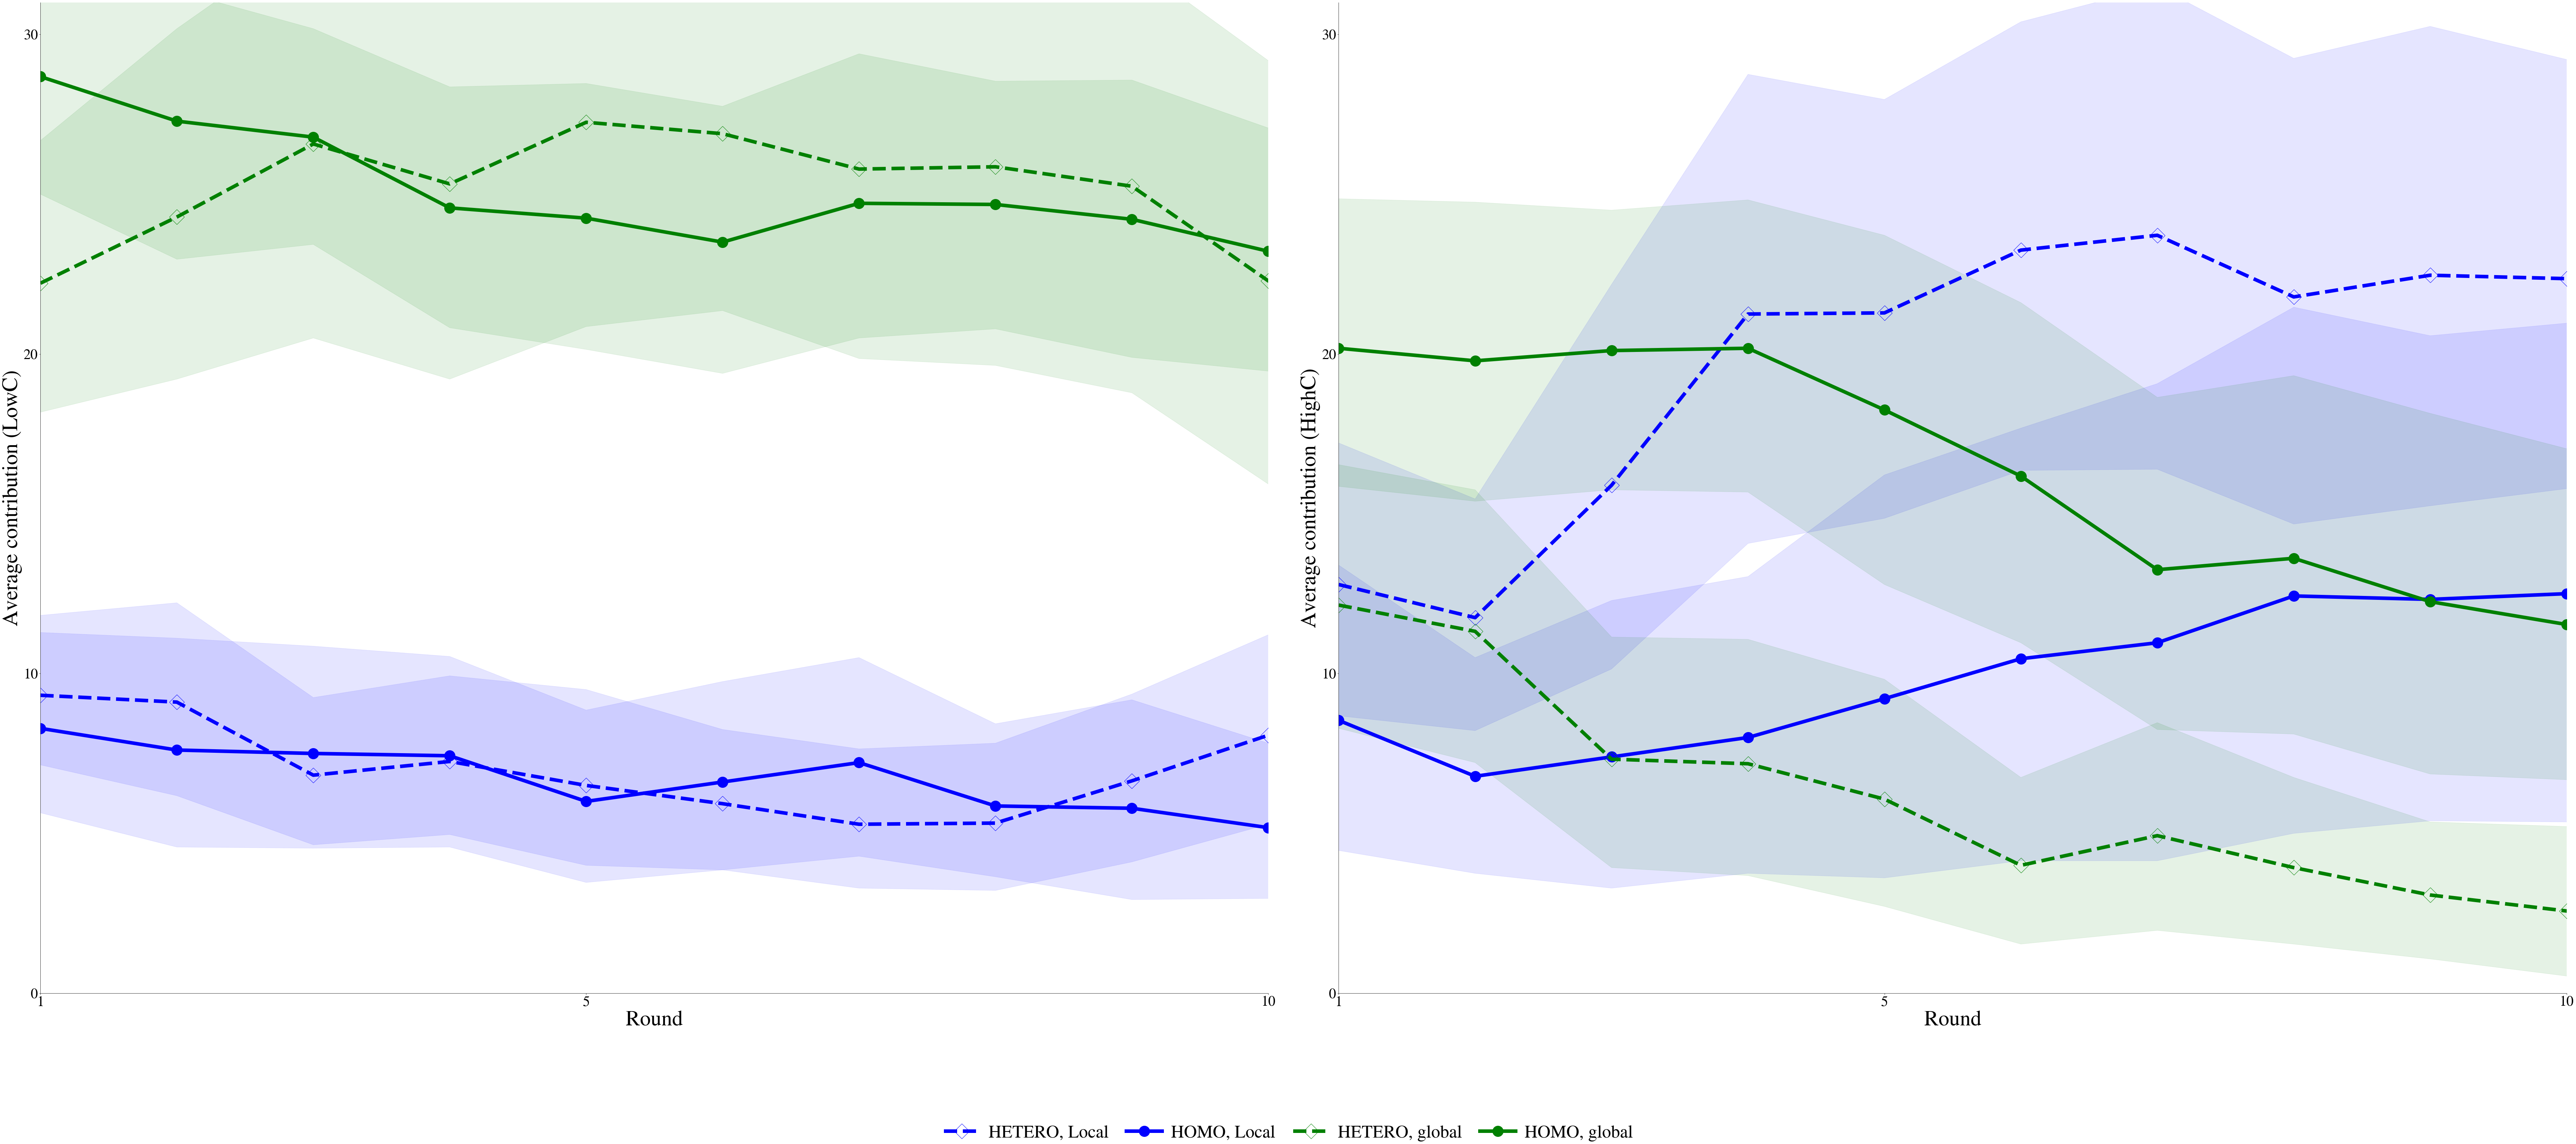

In [165]:
### Separate data and the figure drawing
pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=False,  
#                          sharey=False,  
                         constrained_layout=True, figsize=(100, 40))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Top 2 figures
# labels=  ['HETERO\n $\hspace{25}$ LowC ($\zeta = 2$)', 'HOMO', '',
#           'HETERO\n $\hspace{25}$ HighC ($\zeta = 8$)', 'HOMO', '']
labels=  ['HETERO', 'HOMO', '',
          'HETERO', 'HOMO', '']
labels2 = ["Global Club", "Local PG", "Aveage Group Total Endowment"]
colors = ['grey', 'white']
hatchs = ['.', 'x']
x = np.arange(2)


# axes[0].set_title('LowC ($\zeta = 2$)', fontsize=60)
# axes[1].set_title('HighC ($\zeta = 8$)', fontsize=60)

# Bottom 2 figures
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 31)
custom_ytick = np.arange(0,31,step=10)
custom_xtick = np.array([0,4,9,14,19])
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    

custom_markercolor = ['blue', 'blue', ]
custom_markerfacecolor = ['none', 'blue']
custom_linestyle = ['--','-']

for j, yy in enumerate(treatment_list):
    axes[0].plot(df1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u1.index, df_ci_u1[yy],df_ci_l1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    


custom_markercolor = ['green','green', ]
custom_markerfacecolor = ['none', 'green']
custom_linestyle = ['--','-']


for j, yy in enumerate(treatment_list):
    axes[0].plot(df2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u2.index, df_ci_u2[yy],df_ci_l2[yy], alpha=0.1, color=custom_markercolor[j])

    
# axes[1,0].set_xlabel('LowC ($\zeta = 2$)', fontsize=60)
# axes[1,1].set_xlabel('HighC ($\zeta = 8$)', fontsize=60)

# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    

custom_markercolor = ['blue', 'blue', ]
custom_markerfacecolor = ['none', 'blue']
custom_linestyle = ['--','-']



for j, yy in enumerate(treatment_list):
    axes[1].plot(dfr1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur1.index, df_ci_ur1[yy],df_ci_lr1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    

custom_markercolor = ['green','green', ]
custom_markerfacecolor = ['none', 'green']
custom_linestyle = ['--','-']


for j, yy in enumerate(treatment_list):
    axes[1].plot(dfr2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur2.index, df_ci_ur2[yy],df_ci_lr2[yy], alpha=0.1, color=custom_markercolor[j])

    

axes[0].set_xlabel('Round', fontsize=60)
axes[1].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution (LowC)', fontsize=60)
axes[1].set_ylabel('Average contribution (HighC)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)


handles, labels = axes[0].get_legend_handles_labels() 
# handles2, labels2 = axes[1,0].get_legend_handles_labels() 
fig.legend( handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=4 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff-time.pdf', bbox_inches="tight" )  


In [154]:
# To add the simulation



treatment_list = ['HETERO','HOMO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
R_max = 10

# Prepare for the first subfigure (sum)
LocalGlobal = data_OpporSim.groupby([ 
                     treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


outputSim = np.empty((4,2, 3))
outputSim[:]=np.nan

for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==20), v]
        print('index', i,j, t, v)
        outputSim[i, j, 0]=pop_a.mean()
        outputSim[i, j, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list): 
    for j, v in enumerate(var_of_interest):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                                (LocalGlobal['subsession.period']<=R_max)&
                                (LocalGlobal['FC']==80), v]
        print('index', i+2, j, t,v)
        outputSim[i+2,j, 0]=pop_a.mean()
        outputSim[i+2,j,1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
        
var_of_interest = 'endowment'
LocalGlobal = data_OpporSim.groupby([ 
                     treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()
total_eSim = np.empty((2,2,3))
total_eSim[:]=np.nan

for i,t in enumerate(treatment_list): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]
    total_eSim[i,0,0] =pop_a.mean()
    total_eSim[i, 0, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   
    
    pop_b = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]
    total_eSim[i,1,0] = np.mean(pop_b)
    total_eSim[i, 1, 1:3]=bootstrap_ci(np.array(pop_b), 10000, np.mean)  
#     print(i,t)

# Treatment by endowment (mean)
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
LocalOnly = data_OpporSim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()


# Left graph for FC=2
output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_l,treatment_var,treatment_list , 20)

df1Sim = pd.DataFrame(output1[0,:,:], columns = treatment_list)
df_ci_l1Sim = pd.DataFrame(output1[1,:,:], columns = treatment_list)
df_ci_u1Sim = pd.DataFrame(output1[2,:,:], columns = treatment_list)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_g,treatment_var,treatment_list , 20)

df2Sim = pd.DataFrame(output2[0,:,:], columns = treatment_list)
df_ci_l2Sim = pd.DataFrame(output2[1,:,:], columns = treatment_list)
df_ci_u2Sim = pd.DataFrame(output2[2,:,:], columns = treatment_list)


# right graph for absolute value 

output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_l,treatment_var,treatment_list , 20)

dfr1Sim = pd.DataFrame(output1[0,:,:], columns = treatment_list)
df_ci_lr1Sim = pd.DataFrame(output1[1,:,:], columns = treatment_list)
df_ci_ur1Sim = pd.DataFrame(output1[2,:,:], columns = treatment_list)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_g,treatment_var,treatment_list , 20)

dfr2Sim = pd.DataFrame(output2[0,:,:], columns = treatment_list)
df_ci_lr2Sim = pd.DataFrame(output2[1,:,:], columns = treatment_list)
df_ci_ur2Sim = pd.DataFrame(output2[2,:,:], columns = treatment_list)

index 0 0 HETERO player.contribution_local
index 0 1 HETERO player.contribution_global
index 1 0 HOMO player.contribution_local
index 1 1 HOMO player.contribution_global
index 2 0 HETERO player.contribution_local
index 2 1 HETERO player.contribution_global
index 3 0 HOMO player.contribution_local
index 3 1 HOMO player.contribution_global


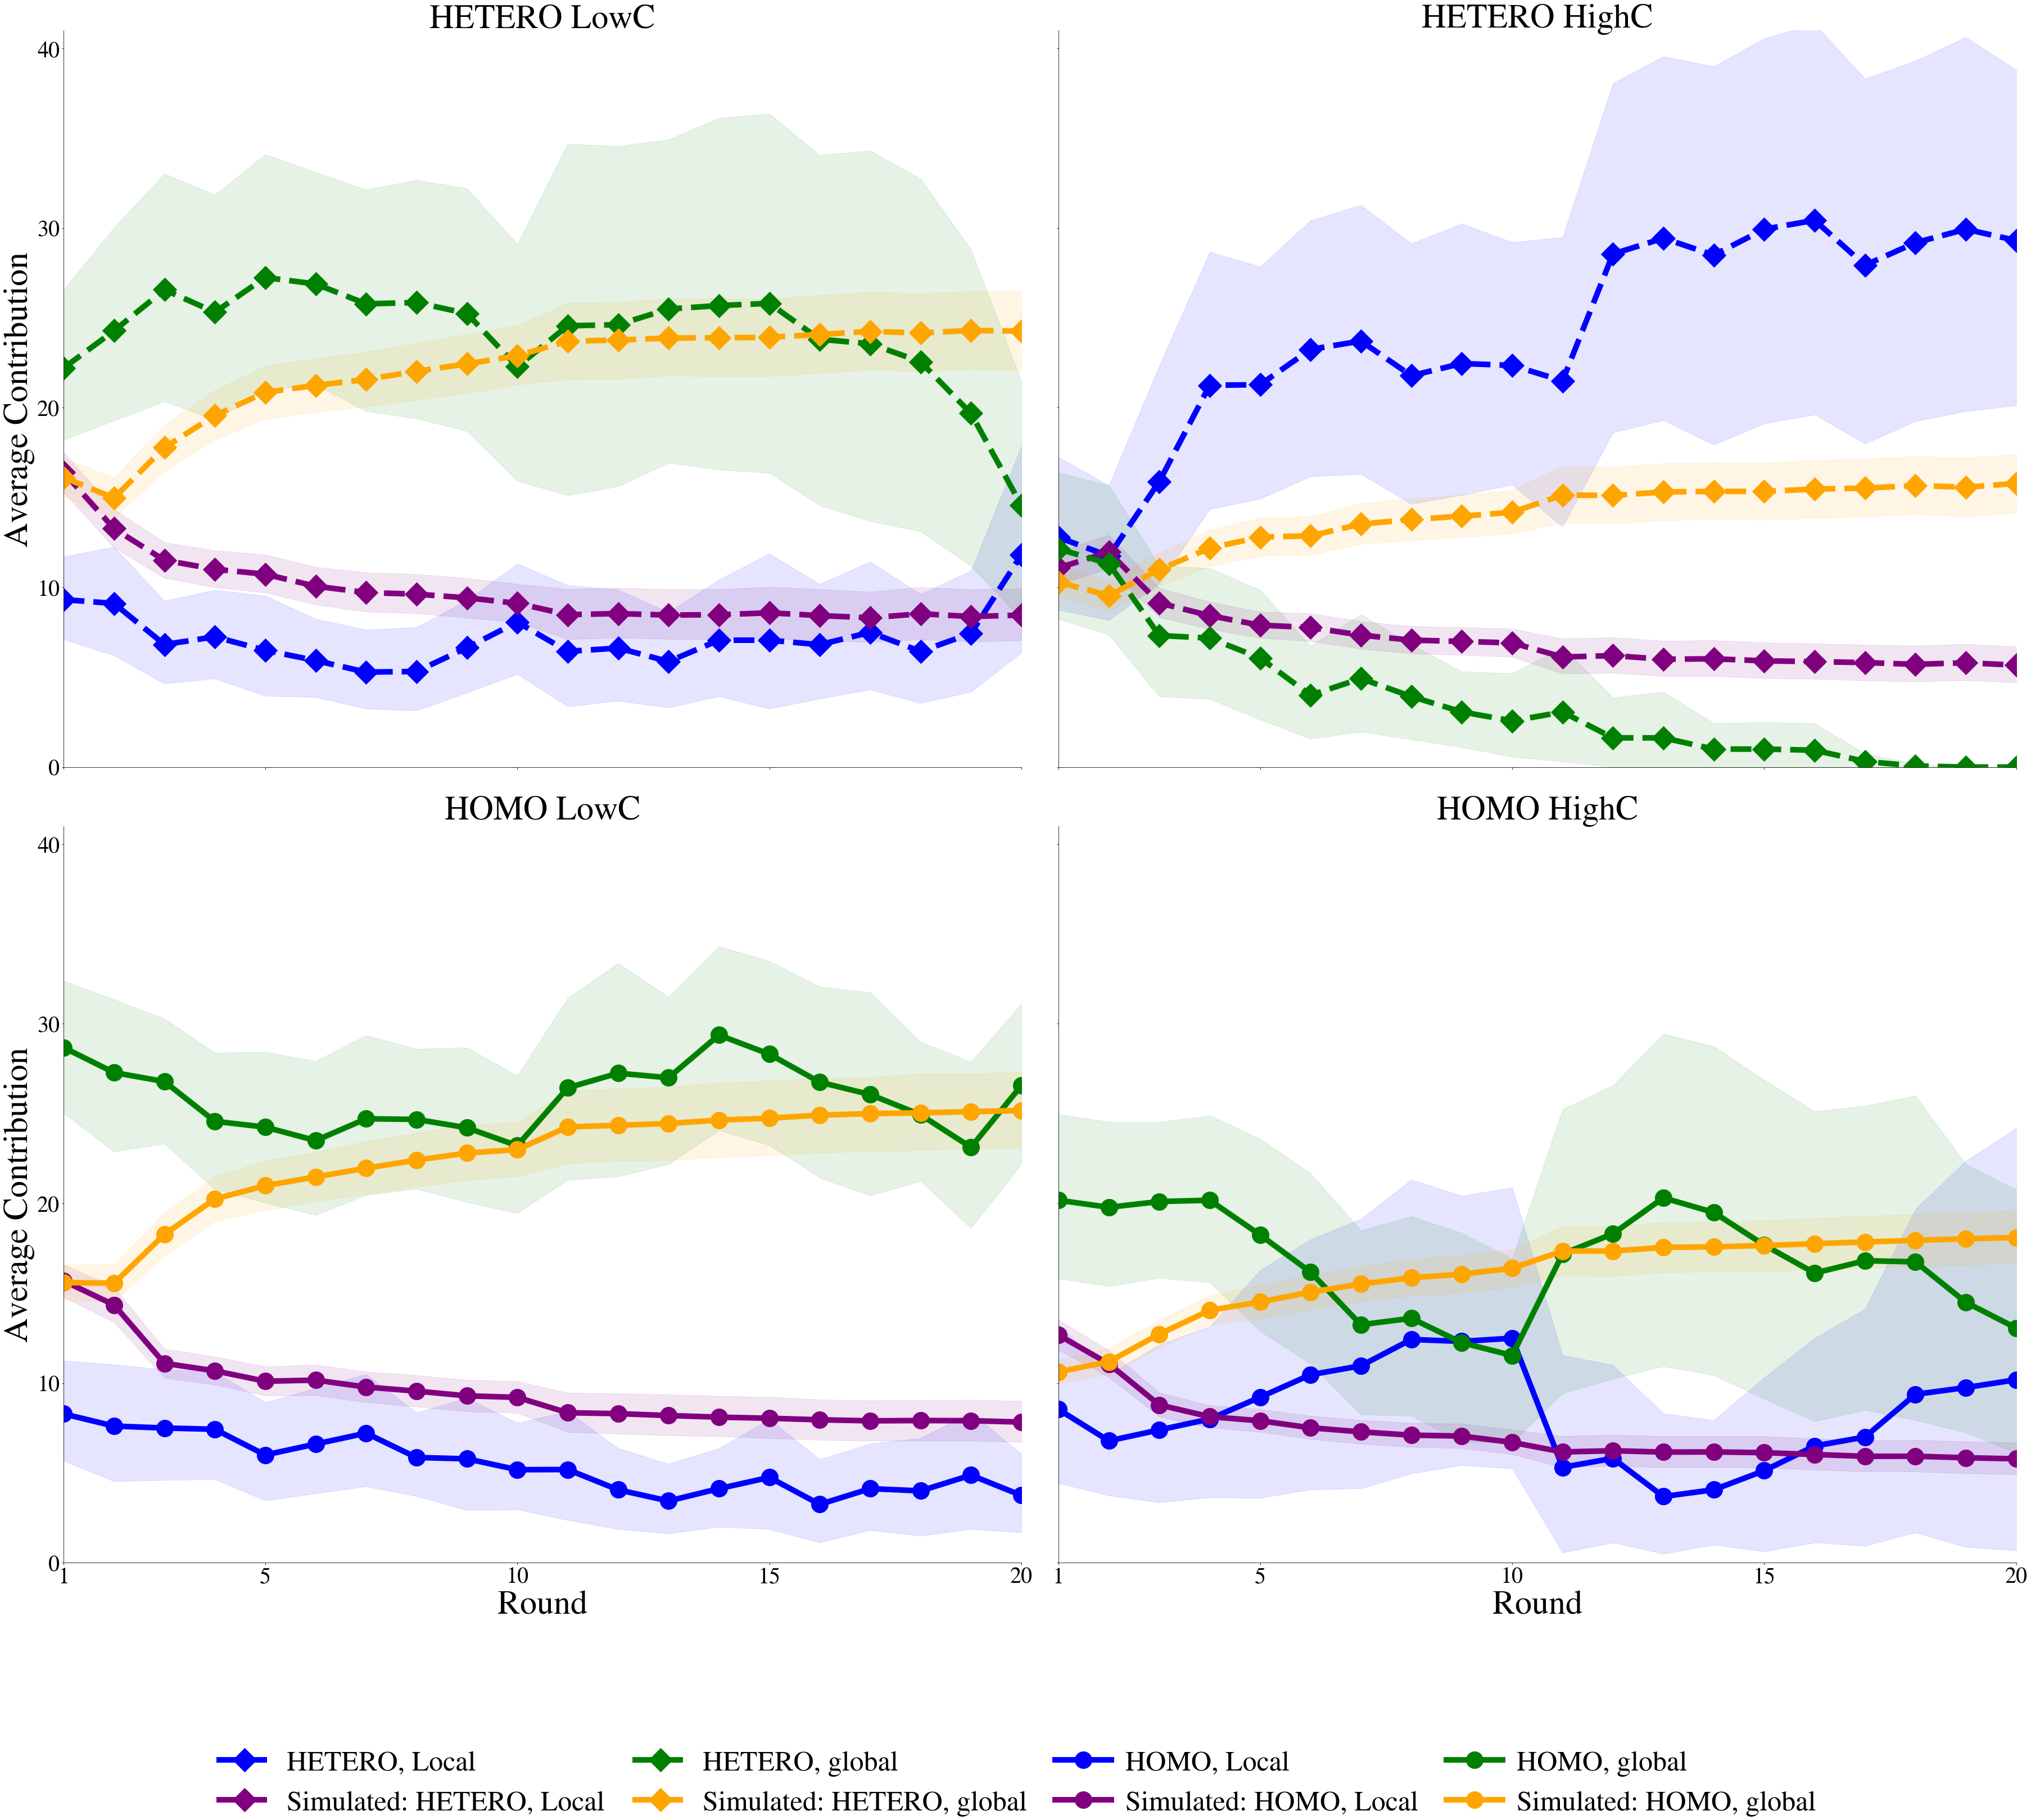

In [28]:
### Separate data and the figure drawing
pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=2, ncols=2,  sharex=True,  
                         sharey=True,  
                         constrained_layout=True, figsize=(50, 40))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# First figure
# labels=  ['HETERO\n $\hspace{25}$ LowC ($\zeta = 2$)', 'HOMO', '','HETERO\n $\hspace{25}$ HighC ($\zeta = 8$)', 'HOMO', '']
# labels2 = ["Global Club", "Local PG", "Aveage Group Total Endowment"]
# colors = ['grey', 'white']
# hatchs = ['.', 'x']
# x = np.arange(len(labels))

# axes[0].bar([0,1], output[[0,1],1, 0], 
#              yerr=[output[[0,1],1,0]-output[[0,1],1,1], output[[0,1],1,2]-output[[0,1],1,0]],
#              label=labels2[0],
#              hatch=hatchs[0],
#              color = 'blue')

# axes[0].bar([0,1], output[[0,1],0, 0], 
#              yerr=[output[[0,1],0,0]-output[[0,1],0,1], output[[0,1],0,2]-output[[0,1],0,0]],
#           label=labels2[1],
#          bottom = output[[0,1],1, 0], 
#              hatch=hatchs[1],
#              color = 'green')

# axes[0].bar([0,1], total_e[[0,1],0, 0], 
#          yerr=[total_e[[0,1],0,0]-total_e[[0,1],0,1], total_e[[0,1],0,2]-total_e[[0,1],0,0]],
#           fill=False, label=labels2[2],
#         edgecolor = 'black')

# axes[0].bar([3,4], output[[2,3],1, 0], 
#              yerr=[output[[2,3],1,0]-output[[2,3],1,1], output[[2,3],1,2]-output[[2,3],1,0]],
#              label=labels2[0],
#              hatch=hatchs[0],
#              color = 'blue')

# axes[0].bar([3,4], output[[2,3],0, 0], 
#              yerr=[output[[2,3],0,0]-output[[2,3],0,1], output[[2,3],0,2]-output[[2,3],0,0]],
#           label=labels2[1],
#          bottom = output[[2,3],1, 0], 
#              hatch=hatchs[1],
#              color = 'green')

# axes[0].bar([3,4], total_e[[0,1],1, 0], 
#          yerr=[total_e[[0,1],1,0]-total_e[[0,1],1,1], total_e[[0,1],1,2]-total_e[[0,1],1,0]],
#           fill=False, label=labels2[2],
#         edgecolor = 'black')
# axes[0].set_xticks(x)
# axes[0].set_xticklabels(labels,multialignment='center',fontsize=60)

# axes[0].set_ylabel('Average contribution', fontsize=60)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 19)
custom_ylim = (0, 41)
custom_ytick = np.arange(0,41,step=10)
custom_xtick = np.array([0,4,9,14,19])
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    
custom_markercolor = ['blue', 'blue', ]
custom_markerfacecolor = ['blue', 'blue']
custom_linestyle = ['--','-']

for j, yy in enumerate(treatment_list):
    axes[j,0].plot(df1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[j,0].fill_between(df_ci_u1.index, df_ci_u1[yy],df_ci_l1[yy], alpha=0.1, color=custom_markercolor[j])
    axes[j,0].plot(df1Sim[yy], label='Simulated: '+yy+', Local', marker=treatment_marker[yy], c='purple',
                         ls=custom_linestyle[j],markerfacecolor='purple',
                         linewidth=10,  markersize=30 )
    axes[j,0].fill_between(df_ci_u1Sim.index, df_ci_u1Sim[yy],df_ci_l1Sim[yy], alpha=0.1, color='purple')

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    

custom_markercolor = ['green', 'green' ]
custom_markerfacecolor = ['green', 'green']
custom_linestyle = ['--','-']


for j, yy in enumerate(treatment_list):
    axes[j,0].plot(df2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[j,0].fill_between(df_ci_u2.index, df_ci_u2[yy],df_ci_l2[yy], alpha=0.1, color=custom_markercolor[j])
    axes[j,0].plot(df2Sim[yy], label='Simulated: '+ yy+', global', marker=treatment_marker[yy], c='orange', 
                         ls=custom_linestyle[j],markerfacecolor='orange',
                         linewidth=10,  markersize=30 )
    axes[j,0].fill_between(df_ci_u2Sim.index, df_ci_u2Sim[yy],df_ci_l2Sim[yy], alpha=0.1, color='orange')
    

    

axes[0,0].set_ylabel('Average Contribution', fontsize=60)
axes[0,0].set_title(treatment_list[0]+' LowC', fontsize=60)
axes[1,0].set_title(treatment_list[1]+' LowC', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    
custom_markercolor = ['blue', 'blue', ]
custom_markerfacecolor = ['blue', 'blue']
custom_linestyle = ['--','-']



for j, yy in enumerate(treatment_list):
    axes[j,1].plot(dfr1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[j,1].fill_between(df_ci_ur1.index, df_ci_ur1[yy],df_ci_lr1[yy], alpha=0.1, color=custom_markercolor[j])
    axes[j,1].plot(dfr1Sim[yy], label='Simulated: '+yy+', Local', marker=treatment_marker[yy], c='purple', 
                         ls=custom_linestyle[j],markerfacecolor='purple',
                         linewidth=10,  markersize=30 )
    axes[j,1].fill_between(df_ci_ur1Sim.index, df_ci_ur1Sim[yy],df_ci_lr1Sim[yy], alpha=0.1, color='purple')

treatment_marker = {'HETERO': 'D',
                    'HOMO': 'o'
                     }
    
custom_markercolor = ['green','green', ]
custom_markerfacecolor = ['green', 'green']
custom_linestyle = ['--','-']


for j, yy in enumerate(treatment_list):
    axes[j,1].plot(dfr2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[j,1].fill_between(df_ci_ur2.index, df_ci_ur2[yy],df_ci_lr2[yy], alpha=0.1, color=custom_markercolor[j])
    axes[j,1].plot(dfr2Sim[yy], label='Simulated: '+yy+', global', marker=treatment_marker[yy], c='orange', 
                         ls=custom_linestyle[j],markerfacecolor='orange',
                         linewidth=10,  markersize=30 )
    axes[j,1].fill_between(df_ci_ur2Sim.index, df_ci_ur2Sim[yy],df_ci_lr2Sim[yy], alpha=0.1, color='orange')

    
axes[1,0].set_ylabel('Average Contribution', fontsize=60)
axes[0,1].set_title(treatment_list[0]+' HighC', fontsize=60)
axes[1,1].set_title(treatment_list[1]+' HighC', fontsize=60)


axes[1,0].set_xlabel('Round', fontsize=60)
axes[1,1].set_xlabel('Round', fontsize=60)

for i in range(2):
    for j in range(2):
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)  
        axes[i,j].tick_params(axis='x', labelsize=40)
        axes[i,j].tick_params(axis='y', labelsize=40)

handles, labels = axes[0,0].get_legend_handles_labels() 
handles2, labels2 = axes[1,0].get_legend_handles_labels() 
fig.legend( handles+handles2, labels+labels2, bbox_to_anchor=(.5,-.1), loc="center" , ncol=4 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff-add-simulation.pdf', bbox_inches="tight" )  


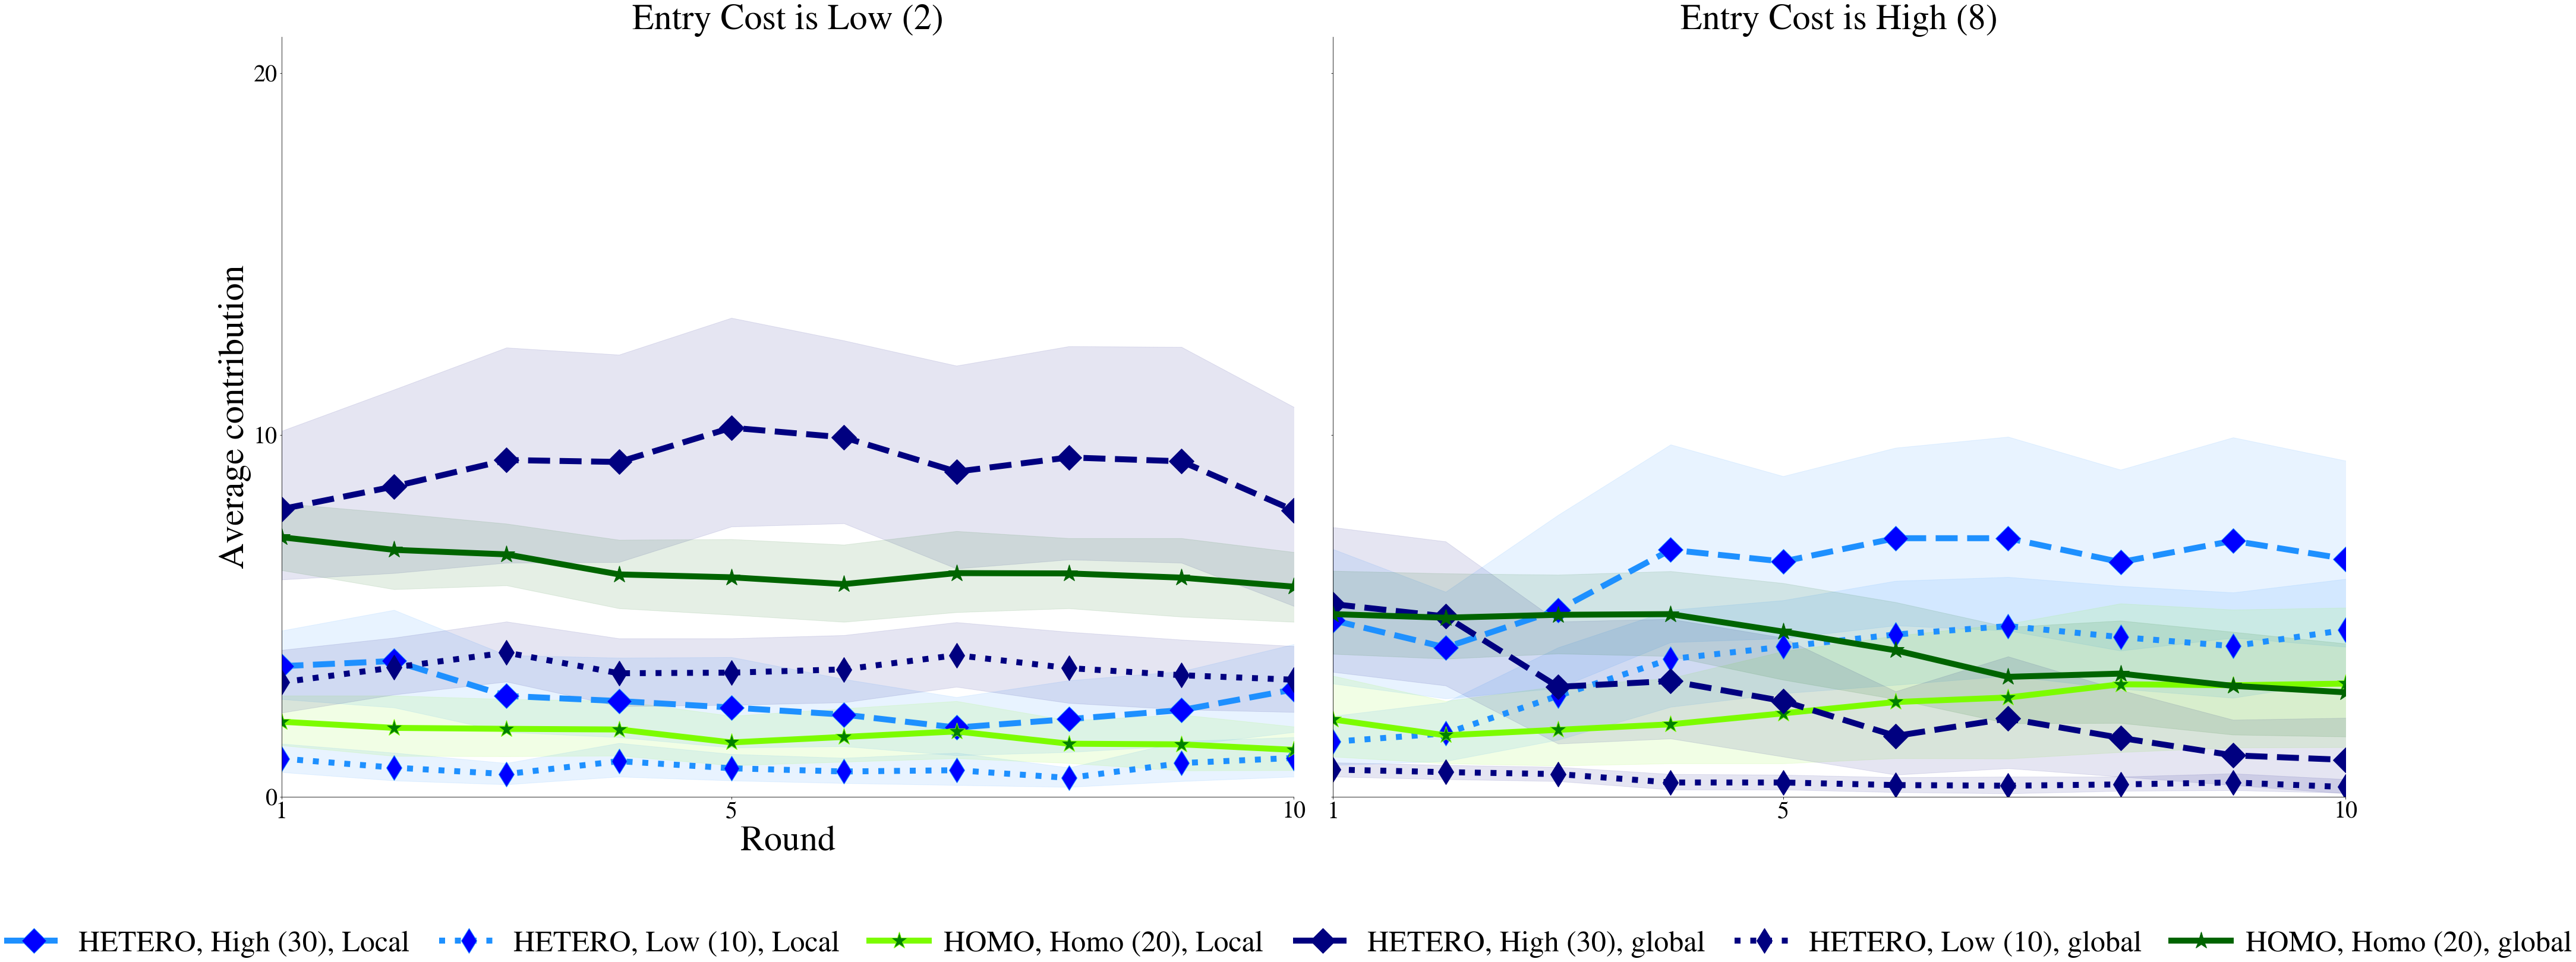

In [75]:
### This is to create the graph for all rounds
# Treatment by endowment 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g]
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()


# Left graph for FC=2
output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_l,treatment_var,treatment_list_r , 20)

df1 = pd.DataFrame(output1[0,:,:], columns = treatment_list_r)
df_ci_l1 = pd.DataFrame(output1[1,:,:], columns = treatment_list_r)
df_ci_u1 = pd.DataFrame(output1[2,:,:], columns = treatment_list_r)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_g,treatment_var,treatment_list_r , 20)

df2 = pd.DataFrame(output2[0,:,:], columns = treatment_list_r)
df_ci_l2 = pd.DataFrame(output2[1,:,:], columns = treatment_list_r)
df_ci_u2 = pd.DataFrame(output2[2,:,:], columns = treatment_list_r)


# right graph for absolute value 

output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_l,treatment_var,treatment_list_r , 20)

dfr1 = pd.DataFrame(output1[0,:,:], columns = treatment_list_r)
df_ci_lr1 = pd.DataFrame(output1[1,:,:], columns = treatment_list_r)
df_ci_ur1 = pd.DataFrame(output1[2,:,:], columns = treatment_list_r)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_g,treatment_var,treatment_list_r , 20)

dfr2 = pd.DataFrame(output2[0,:,:], columns = treatment_list_r)
df_ci_lr2 = pd.DataFrame(output2[1,:,:], columns = treatment_list_r)
df_ci_ur2 = pd.DataFrame(output2[2,:,:], columns = treatment_list_r)



pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 21)
custom_ytick = np.arange(0,21,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['dodgerblue','dodgerblue', 'lawngreen', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u1.index, df_ci_u1[yy],df_ci_l1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['navy','navy', 'darkgreen', ]
custom_markerfacecolor = ['navy', 'navy','darkgreen']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u2.index, df_ci_u2[yy],df_ci_l2[yy], alpha=0.1, color=custom_markercolor[j])

    
    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['dodgerblue','dodgerblue', 'lawngreen', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(dfr1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur1.index, df_ci_ur1[yy],df_ci_lr1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['navy','navy', 'darkgreen', ]
custom_markerfacecolor = ['navy', 'navy','darkgreen']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(dfr2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur2.index, df_ci_ur2[yy],df_ci_lr2[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff.pdf', bbox_inches="tight" )  


In [76]:
LocalOnly[np.isnan(LocalOnly['player.contribution_global'])]

Empty DataFrame
Columns: [T_endw_comp, player.local_community, session.code, FC, Sequence, subsession.round_number, subsession.period, player.contribution_local, player.contribution_global]
Index: []

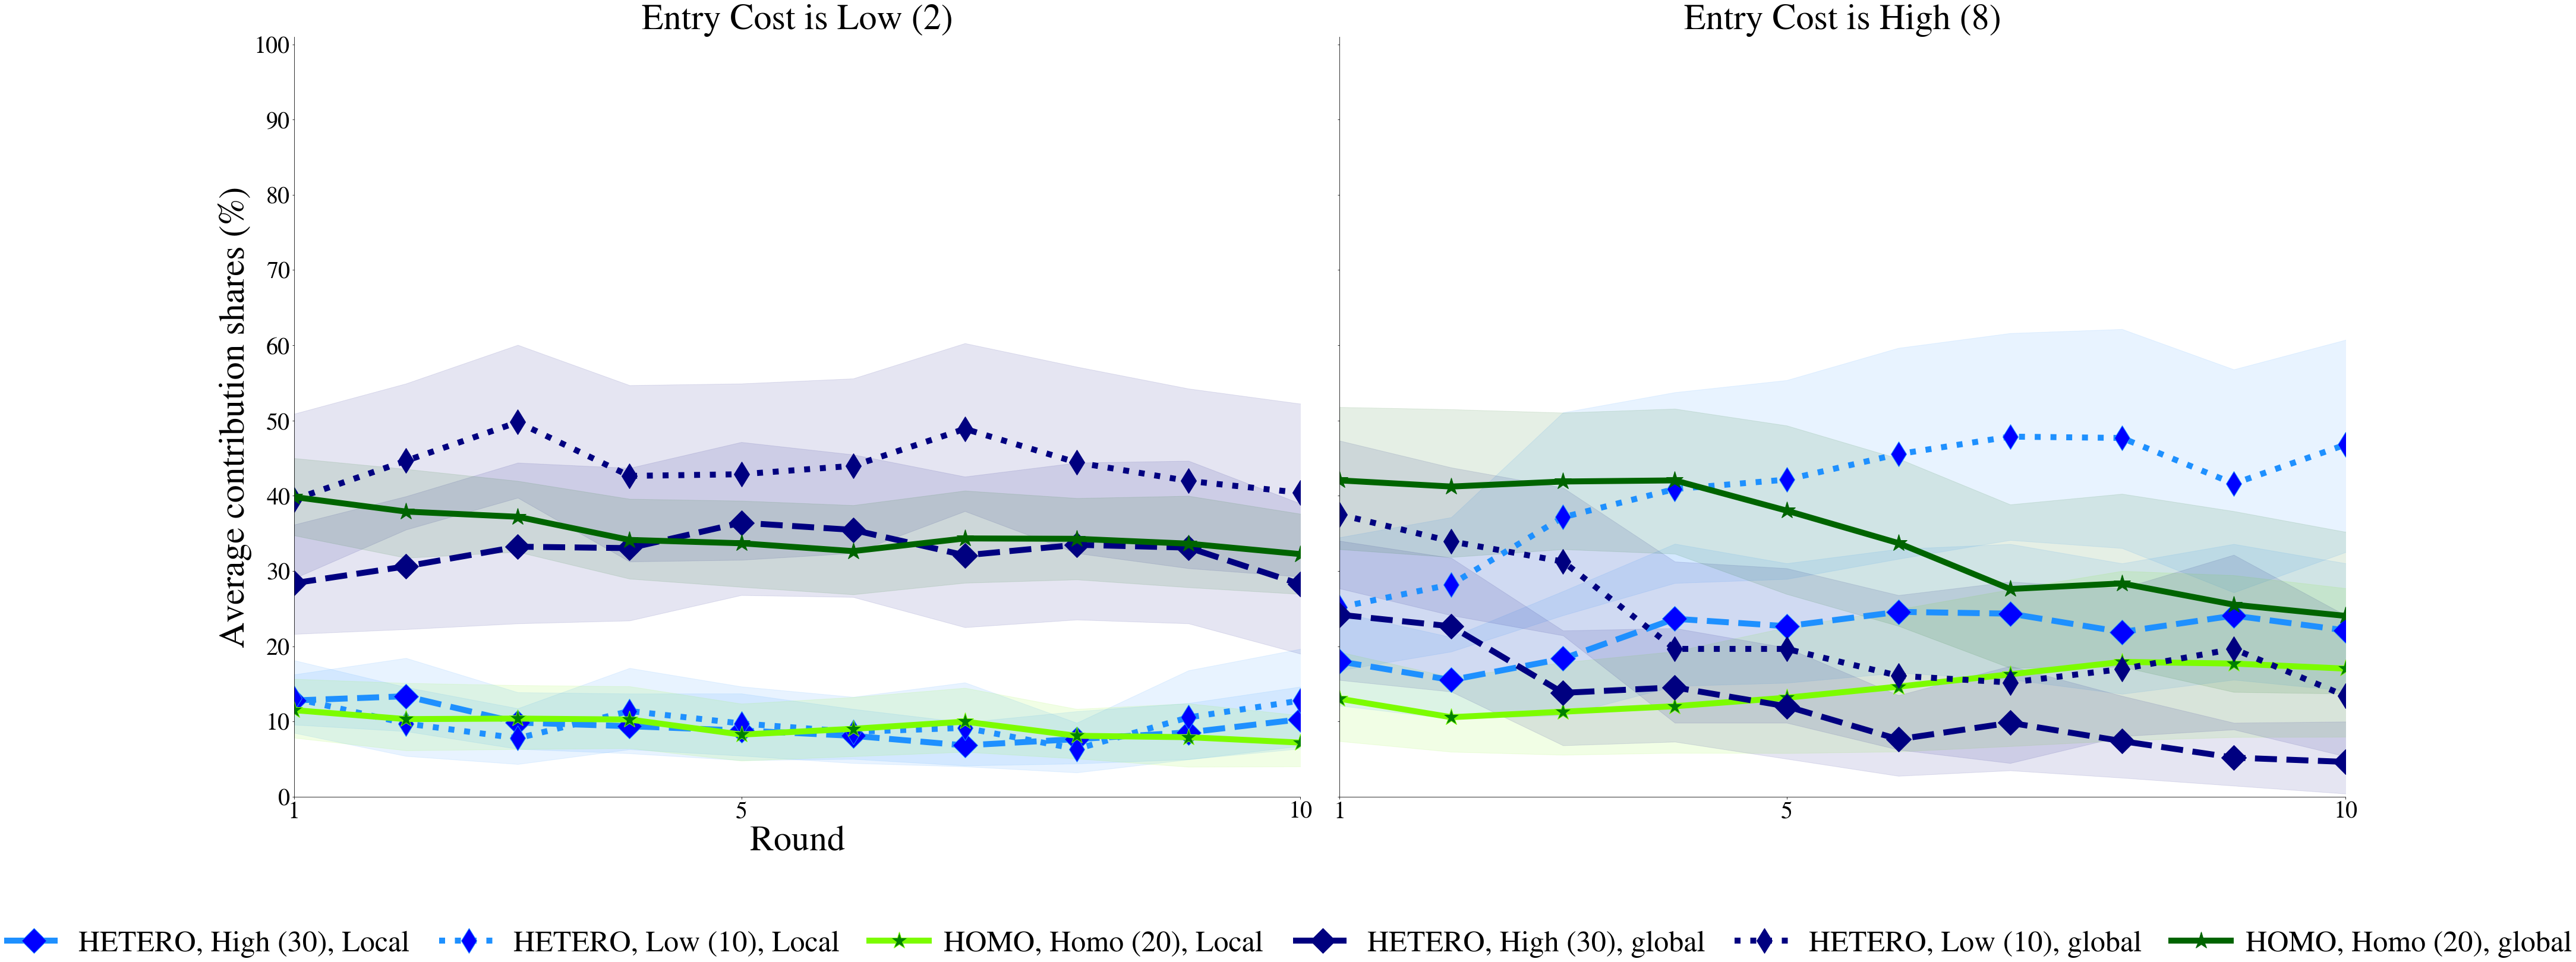

In [77]:
### This is to create the graph for all rounds
# Treatment by endowment 
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_l = 'local_share'
var_g = 'global_share'
var_of_interest =  [var_l, var_g]
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()


treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_l = 'local_share'
var_g = 'global_share'
var_of_interest =  [var_l, var_g]
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_l,treatment_var,treatment_list_r , 20)

df1 = pd.DataFrame(output1[0,:,:], columns = treatment_list_r)
df_ci_l1 = pd.DataFrame(output1[1,:,:], columns = treatment_list_r)
df_ci_u1 = pd.DataFrame(output1[2,:,:], columns = treatment_list_r)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_g,treatment_var,treatment_list_r , 20)

df2 = pd.DataFrame(output2[0,:,:], columns = treatment_list_r)
df_ci_l2 = pd.DataFrame(output2[1,:,:], columns = treatment_list_r)
df_ci_u2 = pd.DataFrame(output2[2,:,:], columns = treatment_list_r)


# right graph for absolute value 

output1 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_l,treatment_var,treatment_list_r , 20)

dfr1 = pd.DataFrame(output1[0,:,:], columns = treatment_list_r)
df_ci_lr1 = pd.DataFrame(output1[1,:,:], columns = treatment_list_r)
df_ci_ur1 = pd.DataFrame(output1[2,:,:], columns = treatment_list_r)

output2 = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_g,treatment_var,treatment_list_r , 20)

dfr2 = pd.DataFrame(output2[0,:,:], columns = treatment_list_r)
df_ci_lr2 = pd.DataFrame(output2[1,:,:], columns = treatment_list_r)
df_ci_ur2 = pd.DataFrame(output2[2,:,:], columns = treatment_list_r)



pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=10)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['dodgerblue','dodgerblue', 'lawngreen', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u1.index, df_ci_u1[yy],df_ci_l1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['navy','navy', 'darkgreen', ]
custom_markerfacecolor = ['navy', 'navy','darkgreen']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u2.index, df_ci_u2[yy],df_ci_l2[yy], alpha=0.1, color=custom_markercolor[j])

    
    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average contribution shares (%)', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['dodgerblue','dodgerblue', 'lawngreen', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(dfr1[yy], label=yy+', Local', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur1.index, df_ci_ur1[yy],df_ci_lr1[yy], alpha=0.1, color=custom_markercolor[j])

treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['navy','navy', 'darkgreen', ]
custom_markerfacecolor = ['navy', 'navy','darkgreen']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(dfr2[yy], label=yy+', global', marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur2.index, df_ci_ur2[yy],df_ci_lr2[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff.pdf', bbox_inches="tight" )  


### % Join the club (both)

Return: 
 [Local + Global Environment](#Local-+-Global-Environment)


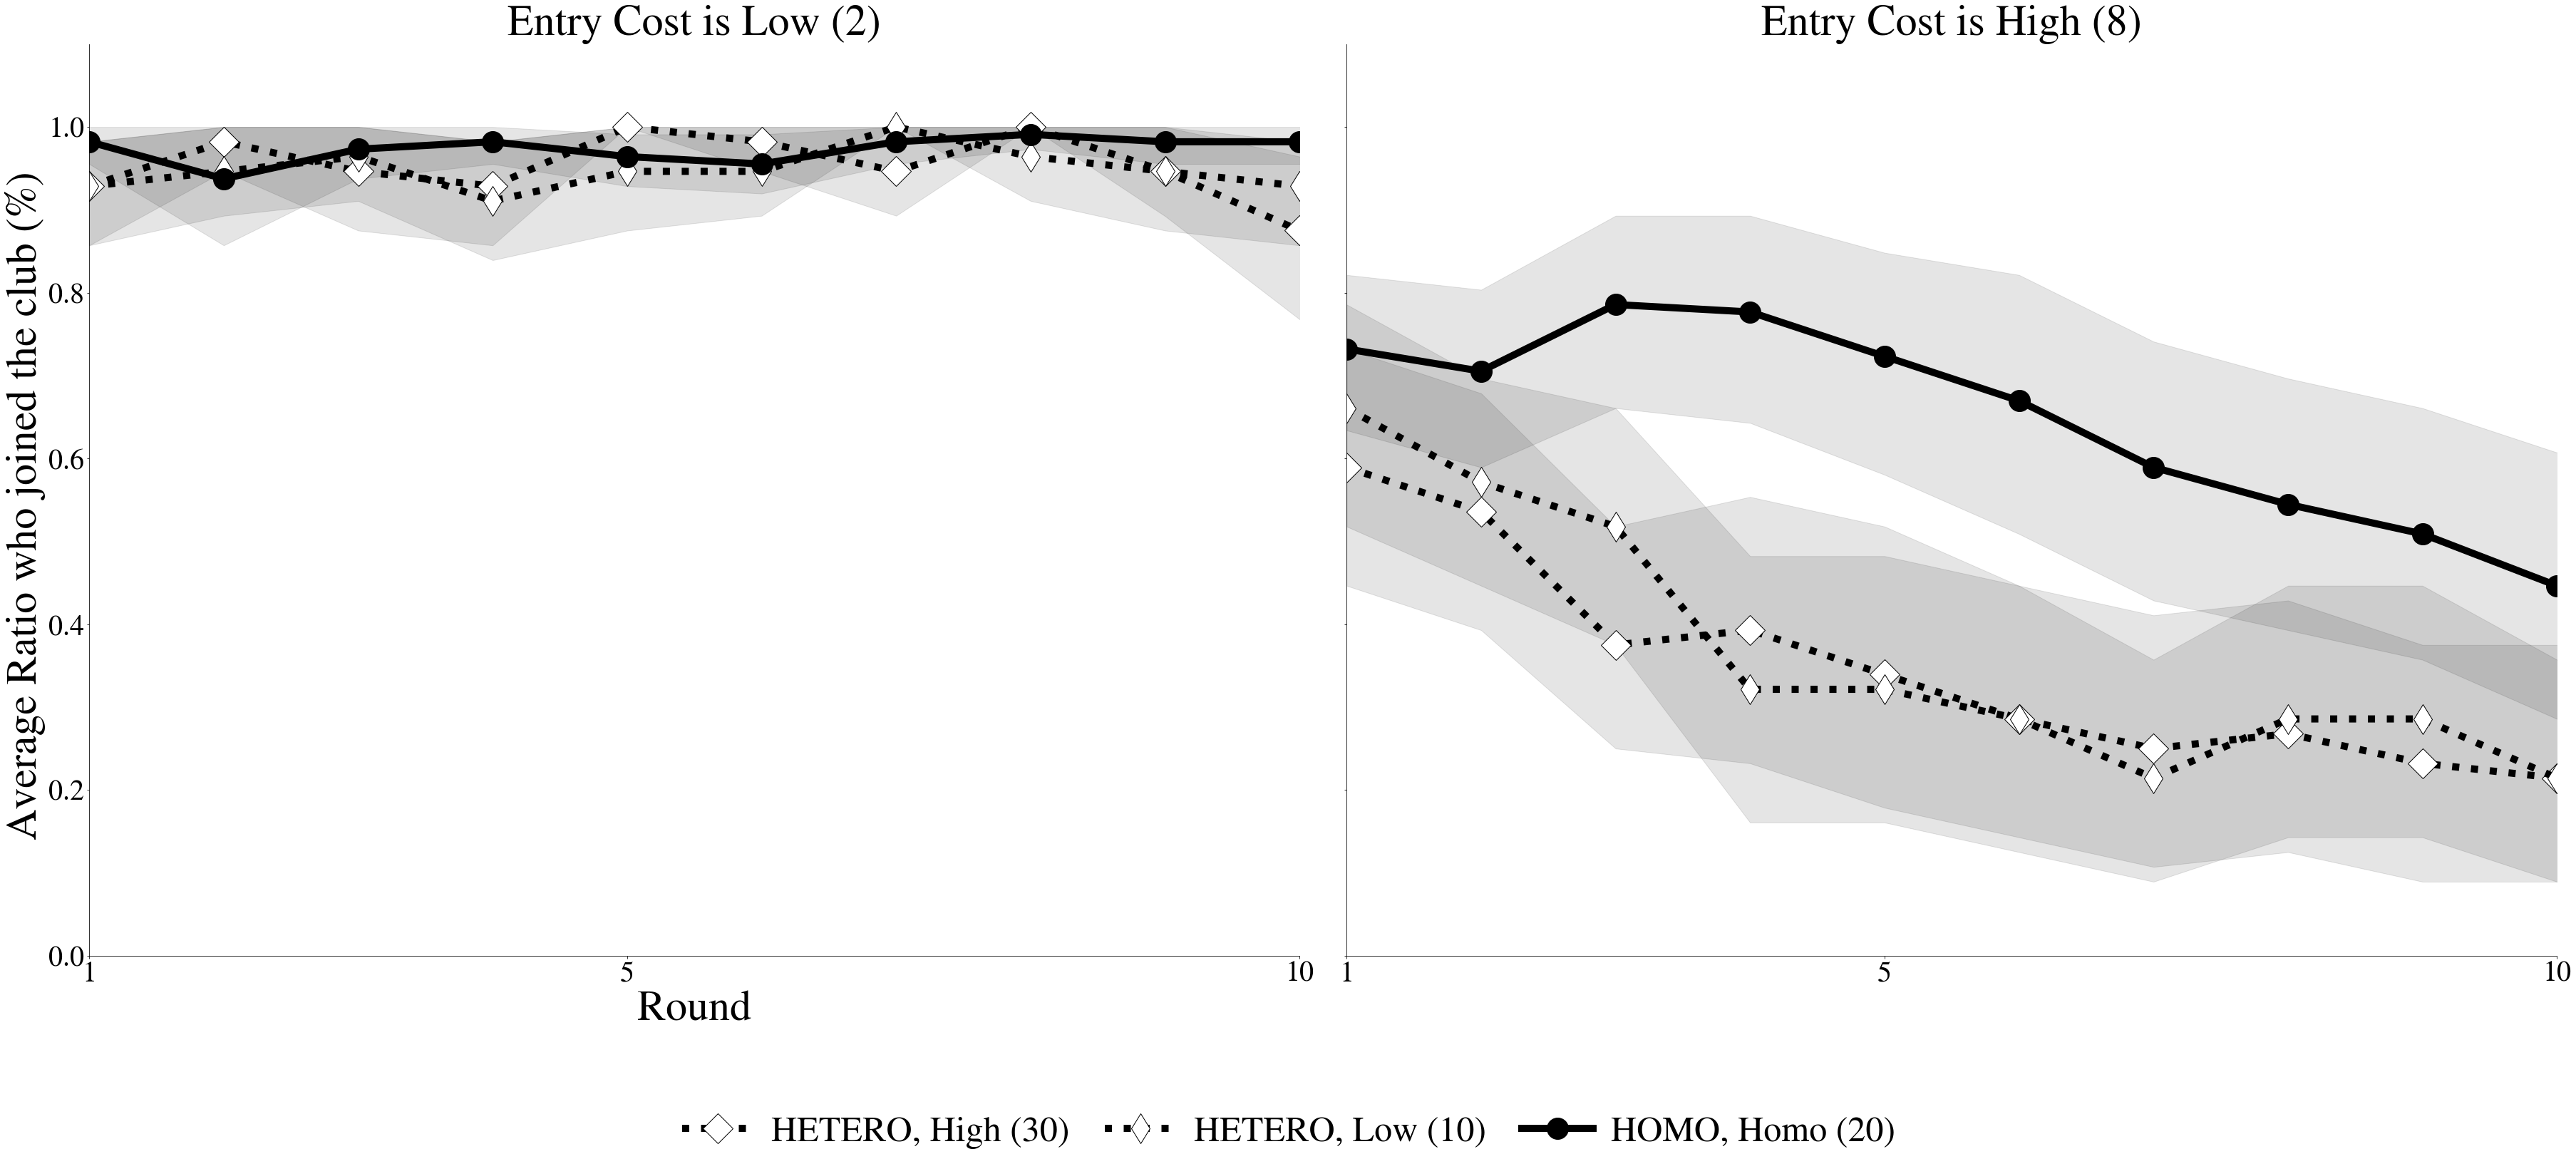

In [41]:
### This is to create the graph for all rounds
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.join_club'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 1.1)
custom_ytick = np.arange(0,1.1,step=0.2)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average Ratio who joined the club (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Join.pdf', bbox_inches="tight" )  


In [42]:
LocalOnly

T_endw_comp  player.local_community session.code  FC Sequence  \
0     HETERO, High (30)                       0     2fgmodqt  80       B1   
1     HETERO, High (30)                       0     2fgmodqt  80       B1   
2     HETERO, High (30)                       0     2fgmodqt  80       B1   
3     HETERO, High (30)                       0     2fgmodqt  80       B1   
4     HETERO, High (30)                       0     2fgmodqt  80       B1   
...                 ...                     ...          ...  ..      ...   
2635    HOMO, Homo (20)                       3     xiwi1u7k  80   B2_bab   
2636    HOMO, Homo (20)                       3     xiwi1u7k  80   B2_bab   
2637    HOMO, Homo (20)                       3     xiwi1u7k  80   B2_bab   
2638    HOMO, Homo (20)                       3     xiwi1u7k  80   B2_bab   
2639    HOMO, Homo (20)                       3     xiwi1u7k  80   B2_bab   

      subsession.round_number  subsession.period  player.join_club  
0                           1                  1              1.00  
1                           2                  2              1.00  
2                           3                  3              0.00  
3                           4                  4              0.50  
4                           5                  5              0.00  
...                       ...                ...               ...  
2635                        6                  6              0.75  
2636                        7                  7              0.75  
2637                        8                  8              1.00  
2638                        9                  9              0.75  
2639                       10                 10              0.75  

[2640 rows x 8 columns]

In [43]:
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.join_club'
LocalOnly = data_OpporSim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

dfSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_uSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_rSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lrSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_urSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)


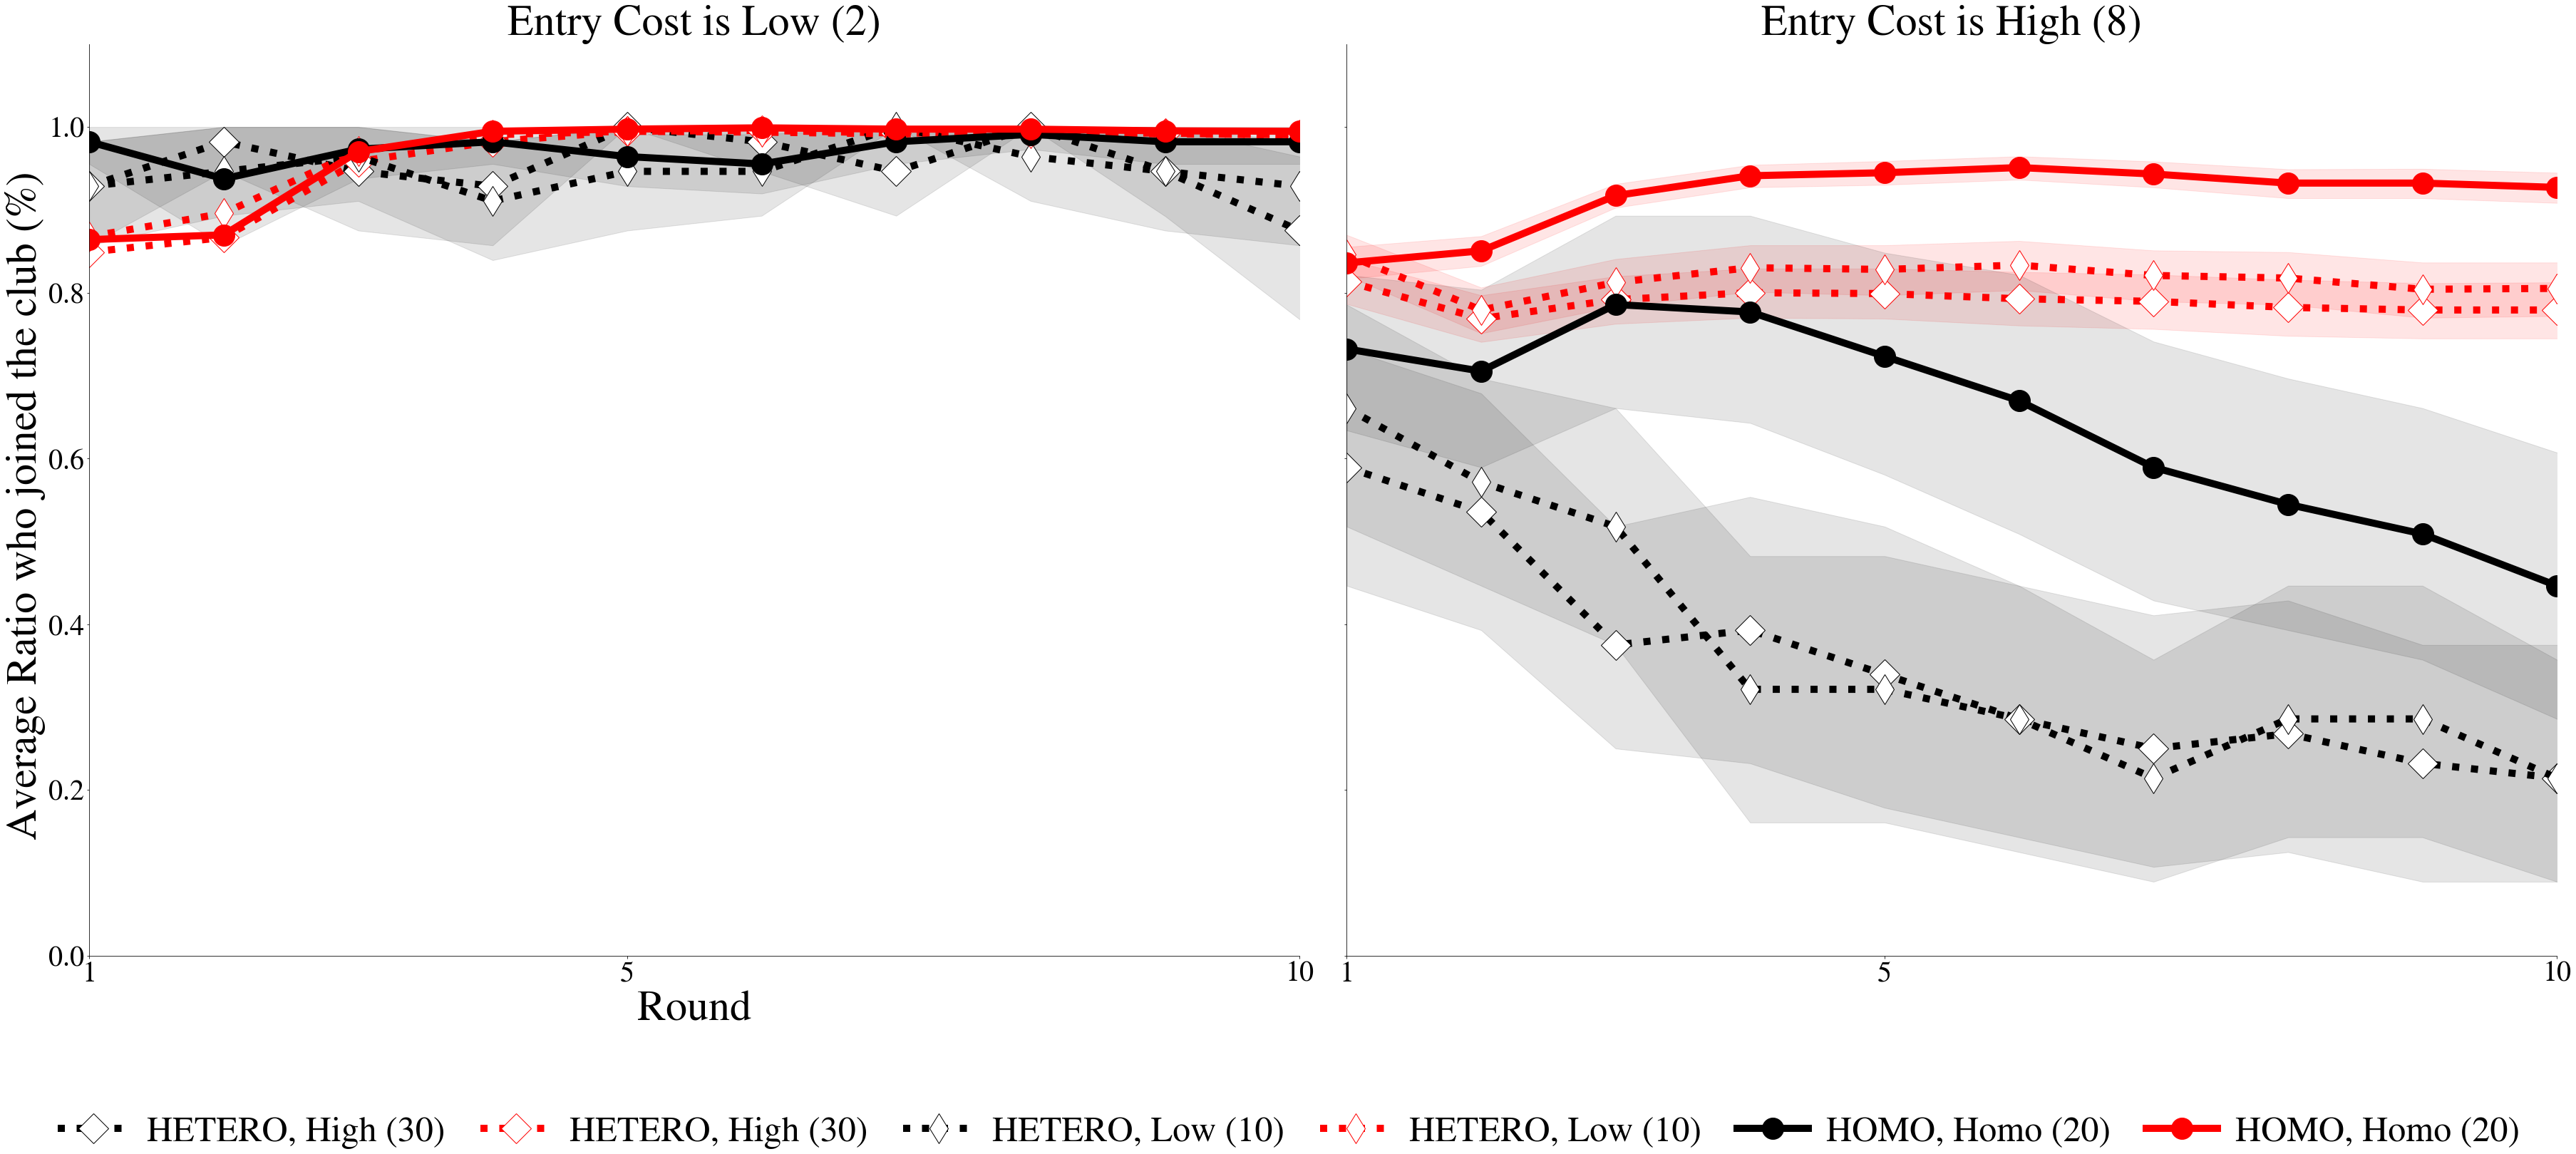

In [44]:
### This is to create the graph for all rounds
pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 1.1)
custom_ytick = np.arange(0,1.1,step=0.2)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': 'o'
                     }
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_markerfacecolor_s = ['white', 'white','red']
custom_linestyle = [':',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    axes[0].plot(dfSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )
#     axes[0].fill_between(df_ci_uSim.index, df_ci_uSim[yy],df_ci_lSim[yy], alpha=0.1, color='red')

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average Ratio who joined the club (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])
    axes[1].plot(df_rSim[yy], label=yy, marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor_s[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_urSim.index, df_ci_urSim[yy],df_ci_lrSim[yy], alpha=0.1, color='red')

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Join-add-simulation.pdf', bbox_inches="tight" )  


### % Welfare (both)

Return: 
 [Local + Global Environment](#Local-+-Global-Environment)

In [ ]:
### This is to create the graph for all rounds
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.payoff'
LocalOnly = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], var_of_interest,treatment_var,treatment_list_r , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list_r , 20)

df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0,101,step=20)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','o', 'D', 'D', '*', '*']
treatment_marker = {'HETERO, High (30)': 'D',
                    'HETERO, Low (10)': 'd',
                    'HOMO, Homo (20)': '*'
                     }
    
custom_markercolor = ['b','b', 'g', ]
custom_markerfacecolor = ['b', 'b','g']
custom_linestyle = ['--',':','-']


for j, yy in enumerate(treatment_list_r):
    axes[0].plot(df[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_ci_u.index, df_ci_u[yy],df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])

    
axes[0].set_xlabel('Round', fontsize=60)
axes[0].set_ylabel('Average Ratio who joined the club (%) ', fontsize=60)
axes[0].set_title('Entry Cost is Low (2)', fontsize=60)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list_r):
    axes[1].plot(df_r[yy], label=yy, marker=treatment_marker[yy], c=custom_markercolor[j], 
                         ls=custom_linestyle[j],markerfacecolor=custom_markerfacecolor[j],
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=custom_markercolor[j])

axes[1].set_title('Entry Cost is High (8)', fontsize=60)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=40)
    axes[i].tick_params(axis='y', labelsize=40)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels, bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=50,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Welfare.pdf', bbox_inches="tight" )  


### Analyze Global + Local (Others)


-[Local + Global Environment](#Local-+-Global-Environment)

In [ ]:
# Note: when analyzing the global club good, can't use local community as the unit, use the whole group
data_Oppor = data_Oppor_allB
# data_Oppor = data_Oppor_allB[data_Oppor_allB['Sequence']=='B1_bab'] #B1 only 
# data_Oppor = pd.concat([B1, B1_bab,B2_bab], ignore_index=True)
# data_Oppor = pd.concat([B1, B1_bab], ignore_index=True)

# For the 50 rounds in B setting, need to divide into 3 big groups
# data_Oppor['subsession.round_number_o'] = data_Oppor['subsession.round_number']
# data_Oppor['subsession.round_number'] = data_Oppor['subsession.round_number'].apply(B_round_number_transfor)


# var_of_interest = 'player.contribution_local'
# var_of_interest = 'privateAcc'
var_of_interest =  'tot_contr'

# LocalGlobal = pd.pivot_table(data_Oppor, values=var_of_interest, index=['player.local_community',  
# 'session.code', 'Treatment','FC'],
#                     columns=['subsession.round_number_o'], aggfunc=np.sum, fill_value=np.nan)

LocalGlobal = data_Oppor.groupby([ 
                      'Treatment',
        'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum()


LocalGlobal
# .groupby(['Treatment','FC']).mean()

In [ ]:
pd.pivot_table(LocalGlobal.reset_index(), index = 'subsession.period', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,20), ylim=(0,80), title='All B (Total Contribution)')

In [ ]:
data_Oppor.columns

In [ ]:
var_of_interest =  'tot_contr'
data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']

LocalGlobal = data_Oppor.groupby([ 
                      'Treatment',
    'player.local_community',  'session.code', 'Endowment_org',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean()


pd.pivot_table(LocalGlobal.reset_index(), index = 'subsession.period', 
               columns=['Treatment','Endowment_org', 'FC'], values=var_of_interest).plot(xlim=(0,20), 
                                                                                         ylim=(0,30), title='All B (Total Contribution)')

In [ ]:
var_of_interest =  'player.contribution_global'
data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']

LocalGlobal = data_Oppor.groupby([ 
                      'Treatment',
    'player.local_community',  'session.code', 'Endowment_org',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean()


pd.pivot_table(LocalGlobal.reset_index(), index = 'subsession.period', 
               columns=['Treatment','Endowment_org', 'FC'], values=var_of_interest).plot(xlim=(0,20), ylim=(0,30), title='All B (Global Contribution)')

In [ ]:
var_of_interest =  'player.contribution_local'
data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']

LocalGlobal = data_Oppor.groupby([ 
                      'Treatment',
    'player.local_community',  'session.code', 'Endowment_org',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean()


pd.pivot_table(LocalGlobal.reset_index(), index = 'subsession.period', 
               columns=['Treatment','Endowment_org', 'FC'], values=var_of_interest).plot(xlim=(0,20), ylim=(0,30), title='All B (Local Contribution)')

In [ ]:
var_of_interest =  'player.join_club'
# data_Oppor = data_Oppor_allB
data_Oppor = data_Oppor_allB[data_Oppor_allB['Sequence']=='B1_bab']

data_Oppor['Endowment_org'] = data_Oppor['player.endowment']  + data_Oppor['player.join_club']*data_Oppor['FC']

LocalGlobal = data_Oppor.groupby([ 
                      'Treatment',
    'player.local_community',  'session.code', 'Endowment_org',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean()


pd.pivot_table(LocalGlobal.reset_index(), index = 'subsession.period', 
               columns=['Treatment','Endowment_org', 'FC'], values=var_of_interest).plot(xlim=(0,20), ylim=(0,1), title='All B(% join club)')

# Both Environments

-[Welfare comparison](#Welfare-comparison)

-[Efficiency comparison](#Efficiency-comparison)

-[Experimental Data for caliberation](#Experimental-Data-for-caliberation)


-[All apps(others)](#All-apps(others))

-[Start Data Analysis](#Start-Data-Analysis)

## Experimental Data for caliberation

Return 
-[Both Environments](#Both-Environments)

In [ ]:
v1 = data_noOppor.groupby(['Treatment', 'FC'])['player.contribution_local' ].mean()
print(v1)
v1_m = v1.to_numpy()
print(v1_m)

In [ ]:
data_Oppor

In [ ]:
v2 = data_Oppor.groupby(['Treatment', 'FC'])['player.join_club','player.contribution_local',  'player.contribution_global' ].mean()
print(v2)
v2_m = v2.to_numpy()
print(v2_m)

## Welfare comparison

Return 
-[Both Environments](#Both-Environments)


In [112]:
# treatment_list = ['HETERO','HOMO']
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.payoff'
R_max = 20

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
      'Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].mean().reset_index()



LocalGlobal =data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

output_payoffs = np.empty((11, 3))
output_payoffs[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]

    output_payoffs[i, 0]=pop_a.mean()
    output_payoffs[i, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]

    output_payoffs[i+4, 0]=pop_a.mean()
    output_payoffs[i+4, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]

    output_payoffs[i+8, 0]=pop_a.mean()
    output_payoffs[i+8, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   


In [24]:
# treatment_list = ['HETERO','HOMO']
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.payoff'
R_max = 20

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
      'Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].mean().reset_index()



LocalGlobal =data_Oppor[data_Oppor['player.join_club']==1].groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

output_join = np.empty((11, 3))
output_join[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]

    output_join[i, 0]=pop_a.mean()
    output_join[i, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest]

    output_join[i+4, 0]=pop_a.mean()
    output_join[i+4, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest]

    output_join[i+8, 0]=pop_a.mean()
    output_join[i+8, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   


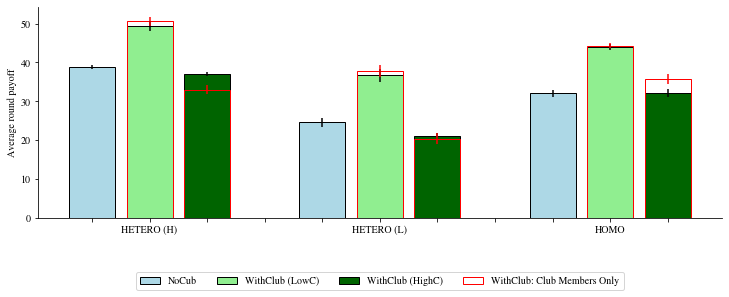

In [113]:
# Draw a graph to show the average player payoff without vs with opportunity 
# Re-group to compare the same type of subjects

# labels=  ['HETERO (H)', 'HETERO (L)','HOMO', '',
#           'HETERO (H)', 'HETERO (L)','HOMO', '',
#          'HETERO (H)', 'HETERO (L)','HOMO']

# labels = ['No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8', '',
#          'No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8', '',
#          'No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8']

labels = ['NoCub','WithClub (LowC)', 'WithClub (HighC)','WithClub: Club Members Only'  ]

labels2 =  ['', 'HETERO (H)','', '',
          '', 'HETERO (L)','', '',
         '', 'HOMO','']

colors = [ 'lightblue','lightgreen','darkgreen']
hatchs = ['', '.', 'xx']

x = np.arange(len(labels2))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))


for i in np.arange(3): 
#     toDraw = output
    axes.bar([i,i+4,i+8], output_payoffs[[i*4,i*4+1,i*4+2],0], 
             yerr=[output_payoffs[[i*4,i*4+1,i*4+2],0]-output_payoffs[[i*4,i*4+1,i*4+2],1], output_payoffs[[i*4,i*4+1,i*4+2],2]-output_payoffs[[i*4,i*4+1,i*4+2],0]],
#              hatch=hatchs[i],
             label="All: " + labels[i], 
#             fill=False,
             color = colors[i],
             edgecolor = 'black'
            )    
for i in np.arange(1,3): 
    axes.bar([i,i+4,i+8], output_join[[i*4,i*4+1,i*4+2],0], 
         yerr=[output_join[[i*4,i*4+1,i*4+2],0]-output_join[[i*4,i*4+1,i*4+2],1], output_join[[i*4,i*4+1,i*4+2],2]-output_join[[i*4,i*4+1,i*4+2],0]],
             ecolor = 'red',
#              hatch=hatchs[i],
         label= labels[3], 
            fill=False,
#          color = colors,
         edgecolor = 'red'
        )    

axes.set_ylabel('Average round payoff')
axes.set_ylabel('Average round payoff')
axes.set_xticks(x)
axes.set_xticklabels(labels2)
legend = axes.legend(labels, bbox_to_anchor=(.5,-.3), loc="center" , ncol=5)
# handles = legend.legendHandles
# for i, handle in enumerate(handles):
#     handle.set_edgecolor("black") 
#     handle.set_facecolor('white')
#     handle.set_hatch(hatchs[i])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
# axes[1].spines['top'].set_visible(False)
# axes[1].spines['right'].set_visible(False)
# axes[0].set_title('All Subjects')
# axes[1].set_title('Subjects who joined the club only')
fig.savefig('..\\Output\\01-group-data-Dec-2022-Payoff.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [88]:
# Adding simulation results 

# treatment_list = ['HETERO','HOMO']
treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
treatment_var = 'T_endw_comp'
var_of_interest =  'player.payoff'
R_max = 20

LocalOnly = data_noOppor_sim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num','FC',
      'Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].mean().reset_index()


LocalGlobal =data_OpporSim.groupby([ 
                     treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Only for mean value now 
# 3 levels of treatment_list_r , Noclub + 11 fixed cost
output_allSim = np.empty((3, 12))
output_allSim[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]
    output_allSim[i, 0]=pop_a.mean()
    
    for j in range(11):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==j*10), var_of_interest]
        output_allSim[i,j+1]=pop_a.mean()
       


    
LocalGlobal =data_OpporSim[data_OpporSim['player.join_club']==1].groupby([ 
                     treatment_var,
    'player.local_community',  'session_num',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

output_joinSim = np.empty((3,12))
output_joinSim[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]
    output_joinSim[i, 0]=pop_a.mean()
    
    for j in range(11):
        pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==j*10), var_of_interest]
        output_joinSim[i,j+1]=pop_a.mean()


<AxesSubplot:xlabel='Treatment,FC'>

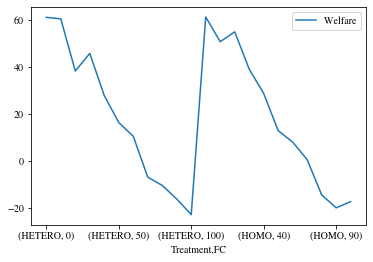

In [102]:
var_of_interest =  'player.payoff'
treatment_var = 'Treatment'
localPays_t = data_noOppor_sim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num','FC','Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

localPays = localPays_t.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num','FC',
            ])[var_of_interest].mean().reset_index()


GlobalPays_t = data_OpporSim.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num','FC','subsession.round_number', 'subsession.period'
            ])[var_of_interest].sum().reset_index()

GlobalPays = GlobalPays_t.groupby([ 
                      treatment_var,
    'player.local_community',  'session_num','FC',
            ])[var_of_interest].mean().reset_index()

MergedPays = localPays.merge(GlobalPays, on=[ treatment_var,
    'player.local_community',  'session_num','FC'])
MergedPays['Welfare'] = MergedPays['player.payoff_y'] - MergedPays['player.payoff_x']

MergedPays.set_index('FC', inplace=True)
MergedPays.groupby([  treatment_var,'FC'])['Welfare'].mean().plot(legend=True)
# MergedPays.groupby([  treatment_var,'FC'])['Welfare'].mean().reset_index()

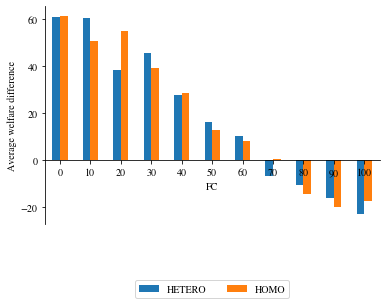

In [119]:
fig = MergedPays.pivot_table(index='FC', columns=treatment_var, values='Welfare').plot(kind='bar')
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
fig.spines['bottom'].set_position('zero')  
fig.legend(bbox_to_anchor=(.5,-0.3), loc="center" , ncol=4)
fig.set_ylabel('Average welfare difference')
fig.figure.savefig('..\\Output\\01-group-data-Dec-2022-Payoff-Simulation-Difference.pdf'  , bbox_inches="tight")  


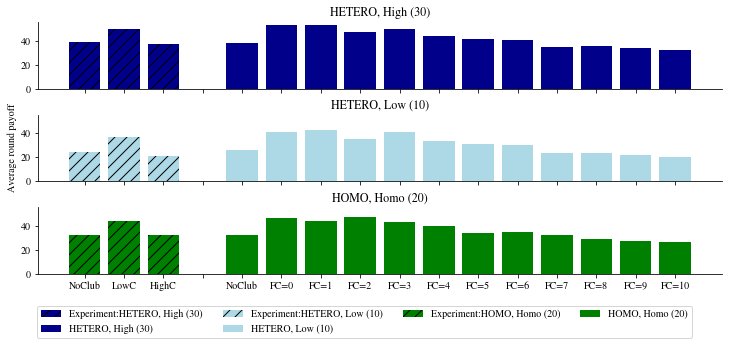

In [48]:
# Draw a graph to show the average player payoff without vs with opportunity 
# Group by environment

# labels=  ['HETERO (H)', 'HETERO (L)','HOMO', '',
#           'HETERO (H)', 'HETERO (L)','HOMO', '',
#          'HETERO (H)', 'HETERO (L)','HOMO']
labels = ['NoClub', 'LowC', 'HighC', '',]+['NoClub'] + ['FC='+str(i) for i in range(11)]

labels2 =  ['', 'No Club Opportunity','', '',
          '', 'Entry Cost = 2','', '',
         '', 'Entry Cost = 8','']

colors = [ 'darkblue','lightblue','green']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=3, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

# Hetero (H) 
for i,t in enumerate(treatment_list_r): 
#     toDraw = output
    
    axes[i].bar(np.arange(3), output_all[[i,i+4,i+8],0],
                hatch = '//',
             label='Experiment:' + t, 
#              yerr=[output[[i,i+4,i+8],0]-output[[i,i+4,i+8],1], output[[i,i+4,i+8],2]-output[[i,i+4,i+8],0]],
             color=colors[i]
            )

    
    axes[i].bar(np.arange(4,16), output_allSim[i,:], 
             label=t, 
#              yerr=[output[[i,i+4,i+8],0]-output[[i,i+4,i+8],1], output[[i,i+4,i+8],2]-output[[i,i+4,i+8],0]],
             color=colors[i]
            )
   
#     if i==2 :
#         axes[i].bar(np.arange(3), output_all[[i,i+4,i+8],0],
#             label='Experiment: Club Members Only',hatch = '//',fill=False,
# #              label='Experiment:' + t, 
# #              yerr=[output[[i,i+4,i+8],0]-output[[i,i+4,i+8],1], output[[i,i+4,i+8],2]-output[[i,i+4,i+8],0]],
#          edgecolor='red'
#         )
#         axes[i].bar(np.arange(4,16), output_joinSim[i,:], 
#          label='Club Members Only', fill=False, 
# #              yerr=[output[[i,i+4,i+8],0]-output[[i,i+4,i+8],1], output[[i,i+4,i+8],2]-output[[i,i+4,i+8],0]],
#          edgecolor='red'
#         )

#     else :
#          axes[i].bar(np.arange(4,16), output_joinSim[i,:], 
#               fill=False, 
# #              yerr=[output[[i,i+4,i+8],0]-output[[i,i+4,i+8],1], output[[i,i+4,i+8],2]-output[[i,i+4,i+8],0]],
#              edgecolor='red'
#             )
#          axes[i].bar(np.arange(3), output_all[[i,i+4,i+8],0],
#             hatch = '//',fill=False,
# #              label='Experiment:' + t, 
# #              yerr=[output[[i,i+4,i+8],0]-output[[i,i+4,i+8],1], output[[i,i+4,i+8],2]-output[[i,i+4,i+8],0]],
#          edgecolor='red'
#         )
    axes[i].set_title(t)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels)
#     axes[i].legend(['HETERO (H)', 'HETERO (L)','HOMO'])
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
axes[1].set_ylabel('Average round payoff')
fig.legend(bbox_to_anchor=(.5,-0.1), loc="center" , ncol=4)

fig.savefig('..\\Output\\01-group-data-Dec-2022-Payoff-Simulation.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

## Efficiency comparison


Efficiency: realized payoff / max possible social benefit in a global group

Efficiency2: realized payoff / max attainable social benefit in a global group (conditional on stage 1 choice)


Return 
-[Both Environments](#Both-Environments)


In [33]:
treatment_list_r = ['HETERO','HOMO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_of_interest =  'Efficiency'
R_max = 20

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
      'Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].mean().reset_index()



# LocalGlobal =data_Oppor.groupby([ 
#                      treatment_var,
#     'player.local_community',  'session.code',
#                       'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

var_of_interest_g =  'Efficiency'
LocalGlobal =data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest_g].mean().reset_index()


output_all = np.empty((11, 3))
output_all[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]

    output_all[i, 0]=pop_a.mean()
    output_all[i, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest_g]

    output_all[i+4, 0]=pop_a.mean()
    output_all[i+4, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest_g]

    output_all[i+8, 0]=pop_a.mean()
    output_all[i+8, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   


In [34]:
data_noOppor['MaxSocialBenefit'] = 8*80*0.6
data_Oppor['MaxSocialBenefit'] = 8*(160-data_Oppor['FC']/10*8) *0.6
data_Oppor['SocialBenefitMax'] /= 10
data_Oppor['AttainableShare'] = data_Oppor['SocialBenefitMax'] / data_Oppor['MaxSocialBenefit']

In [35]:
treatment_list_r = ['HETERO','HOMO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
R_max = 20


var_of_interest_g =  'AttainableShare'
LocalGlobal =data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest_g].mean().reset_index()


output_all2 = np.empty((11, 3))
output_all2[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]

    output_all2[i, 0]=pop_a.mean()
    output_all2[i, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest_g]

    output_all2[i+4, 0]=pop_a.mean()
    output_all2[i+4, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest_g]

    output_all2[i+8, 0]=pop_a.mean()
    output_all2[i+8, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   


In [36]:
output_all3 = np.empty((11, 3))
output_all3[:]=np.nan
output_all3[0:2, :]=1
output_all3[4:6, :]=1
output_all3[8:10, :]=1
output_all3

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [nan, nan, nan],
       [nan, nan, nan],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [nan, nan, nan],
       [nan, nan, nan],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [nan, nan, nan]])

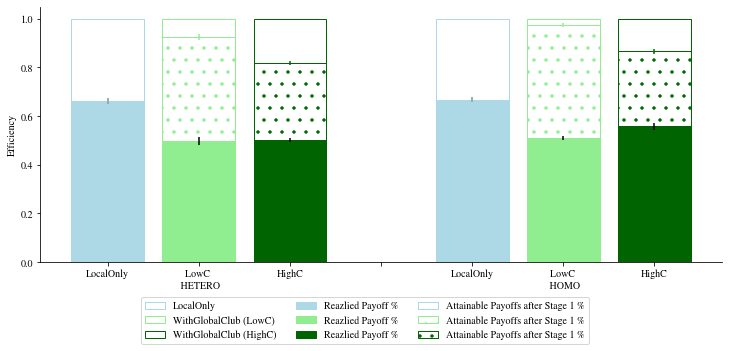

In [45]:
# Draw a graph to show the average efficiency without vs with opportunity 
# Re-group to compare the same type of subjects

# labels=  ['HETERO (H)', 'HETERO (L)','HOMO', '',
#           'HETERO (H)', 'HETERO (L)','HOMO', '',
#          'HETERO (H)', 'HETERO (L)','HOMO']

# labels = ['No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8', '',
#          'No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8', '',
#          'No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8']

labels = ['LocalOnly','WithGlobalClub (LowC)', 'WithGlobalClub (HighC)']

# labels2 =  ['', 'HETERO (H)','', '',
#           '', 'HETERO (L)','', '',
#          '', 'HOMO','']
# labels2 =  ['', 'HETERO','', '',
#          '', 'HOMO','']
labels2 =  ['LocalOnly', 'LowC \n HETERO','HighC', '',
         'LocalOnly', 'LowC \n HOMO','HighC']



colors = [ 'lightblue','lightgreen','darkgreen']
hatchs = ['', '.', 'xx']

x = np.arange(len(labels2))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

for i in np.arange(0,3): 
    axes.bar([i,i+4,i+8], output_all3[[i*4,i*4+1,i*4+2],0], 
             ecolor = colors[i],
#              hatch=hatchs[i],
         label="" + labels[i],
            fill=False,
#          color = colors,
         edgecolor = colors[i],
        )    


for i in np.arange(3): 
#     toDraw = output
    axes.bar([i,i+4,i+8], output_all[[i*4,i*4+1,i*4+2],0], 
             yerr=[output_all[[i*4,i*4+1,i*4+2],0]-output_all[[i*4,i*4+1,i*4+2],1], output_all[[i*4,i*4+1,i*4+2],2]-output_all[[i*4,i*4+1,i*4+2],0]],
#              hatch=hatchs[i],
             label="Reazlied Payoff %", 
#             fill=False,
             color = colors[i],
             edgecolor = colors[i],
            )    
for i in np.arange(0,3): 
    axes.bar([i,i+4,i+8], output_all2[[i*4,i*4+1,i*4+2],0], 
         yerr=[output_all2[[i*4,i*4+1,i*4+2],0]-output_all2[[i*4,i*4+1,i*4+2],1], output_all2[[i*4,i*4+1,i*4+2],2]-output_all2[[i*4,i*4+1,i*4+2],0]],
             ecolor = colors[i],
             hatch='.',
         label="Attainable Payoffs after Stage 1 %",
            fill=False,
#          color = colors,
         edgecolor = colors[i],
        )    
    

axes.set_ylabel('Efficiency')
axes.set_xticks(x)
axes.set_xticklabels(labels2)

# handles, labels = axes[0,0].get_legend_handles_labels() 
fig.legend(  bbox_to_anchor=(.5,-.1), loc="center" , ncol=3 )

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)


fig.savefig('..\\Output\\01-group-data-Dec-2022-Efficiency.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

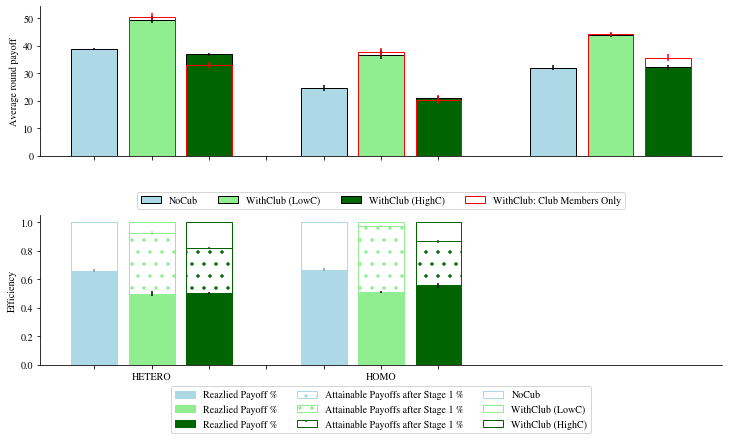

In [119]:
# Draw a graph to show the average player payoff without vs with opportunity 


labels = ['NoCub','WithClub (LowC)', 'WithClub (HighC)','WithClub: Club Members Only'  ]

labels2 =  ['', 'HETERO (H)','', '',
          '', 'HETERO (L)','', '',
         '', 'HOMO','']

colors = [ 'lightblue','lightgreen','darkgreen']
hatchs = ['', '.', 'xx']

x = np.arange(len(labels2))
fig, axes = plt.subplots(nrows=2, ncols=1,  sharex=True,   constrained_layout=True, figsize=(10, 6))


for i in np.arange(3): 
#     toDraw = output
    axes[0].bar([i,i+4,i+8], output_payoffs[[i*4,i*4+1,i*4+2],0], 
             yerr=[output_payoffs[[i*4,i*4+1,i*4+2],0]-output_payoffs[[i*4,i*4+1,i*4+2],1], output_payoffs[[i*4,i*4+1,i*4+2],2]-output_payoffs[[i*4,i*4+1,i*4+2],0]],
#              hatch=hatchs[i],
             label="All: " + labels[i], 
#             fill=False,
             color = colors[i],
             edgecolor = 'black'
            )    
for i in np.arange(1,3): 
    axes[0].bar([i,i+4,i+8], output_join[[i*4,i*4+1,i*4+2],0], 
         yerr=[output_join[[i*4,i*4+1,i*4+2],0]-output_join[[i*4,i*4+1,i*4+2],1], output_join[[i*4,i*4+1,i*4+2],2]-output_join[[i*4,i*4+1,i*4+2],0]],
             ecolor = 'red',
#              hatch=hatchs[i],
         label= labels[3], 
            fill=False,
#          color = colors,
         edgecolor = 'red'
        )    

axes[0].set_ylabel('Average round payoff')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels2)
legend = axes[0].legend(labels, bbox_to_anchor=(.5,-.3), loc="center" , ncol=5)
# handles = legend.legendHandles
# for i, handle in enumerate(handles):
#     handle.set_edgecolor("black") 
#     handle.set_facecolor('white')
#     handle.set_hatch(hatchs[i])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)




labels = ['NoCub','WithClub (LowC)', 'WithClub (HighC)']

# labels2 =  ['', 'HETERO (H)','', '',
#           '', 'HETERO (L)','', '',
#          '', 'HOMO','']
labels2 =  ['', 'HETERO','', '',
         '', 'HOMO','']


colors = [ 'lightblue','lightgreen','darkgreen']
hatchs = ['', '.', 'xx']

for i in np.arange(3): 
#     toDraw = output
    axes[1].bar([i,i+4,i+8], output_all[[i*4,i*4+1,i*4+2],0], 
             yerr=[output_all[[i*4,i*4+1,i*4+2],0]-output_all[[i*4,i*4+1,i*4+2],1], output_all[[i*4,i*4+1,i*4+2],2]-output_all[[i*4,i*4+1,i*4+2],0]],
#              hatch=hatchs[i],
             label="Reazlied Payoff %", 
#             fill=False,
             color = colors[i],
             edgecolor = colors[i],
            )    
for i in np.arange(0,3): 
    axes[1].bar([i,i+4,i+8], output_all2[[i*4,i*4+1,i*4+2],0], 
         yerr=[output_all2[[i*4,i*4+1,i*4+2],0]-output_all2[[i*4,i*4+1,i*4+2],1], output_all2[[i*4,i*4+1,i*4+2],2]-output_all2[[i*4,i*4+1,i*4+2],0]],
             ecolor = colors[i],
             hatch='.',
         label="Attainable Payoffs after Stage 1 %",
            fill=False,
#          color = colors,
         edgecolor = colors[i],
        )    
    
for i in np.arange(0,3): 
    axes[1].bar([i,i+4,i+8], output_all3[[i*4,i*4+1,i*4+2],0], 
             ecolor = colors[i],
#              hatch=hatchs[i],
         label="" + labels[i],
            fill=False,
#          color = colors,
         edgecolor = colors[i],
        )    

axes[1].set_ylabel('Efficiency')
x = np.arange(len(labels2))
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels2)
legend = axes[1].legend(bbox_to_anchor=(.5,-.3), loc="center" , ncol=3)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)



fig.savefig('..\\Output\\01-group-data-Dec-2022-Welfare.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [83]:
treatment_list_r = ['HETERO','HOMO']
# treatment_list_r = ['HETERO, High (30)','HETERO, Low (10)', 'HOMO, Homo (20)']
# treatment_var = 'T_endw_comp'
treatment_var = 'Treatment'
var_of_interest =  'MaxSocialBenefit'
R_max = 20

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code','FC',
      'Sequence','subsession.round_number', 'subsession.period'
            ])[var_of_interest].mean().reset_index()


data_Oppor
var_of_interest_g =  'SocialBenefitMax'
LocalGlobal =data_Oppor.groupby([ 
                     treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest_g].mean().reset_index()


output_all = np.empty((11, 3))
output_all[:]=np.nan

for i,t in enumerate(treatment_list_r): 
    pop_a = LocalOnly.loc[(LocalOnly[treatment_var]==t)&(LocalOnly['subsession.period']<=R_max), var_of_interest]

    output_all[i, 0]=pop_a.mean()
    output_all[i, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==20), var_of_interest_g]

    output_all[i+4, 0]=pop_a.mean()
    output_all[i+4, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)    
    
for i,t in enumerate(treatment_list_r): 
    pop_a = LocalGlobal.loc[(LocalGlobal[treatment_var]==t)&
                            (LocalGlobal['subsession.period']<=R_max)&
                            (LocalGlobal['FC']==80), var_of_interest_g]

    output_all[i+8, 0]=pop_a.mean()
    output_all[i+8, 1:3]=bootstrap_ci(np.array(pop_a), 10000, np.mean)   


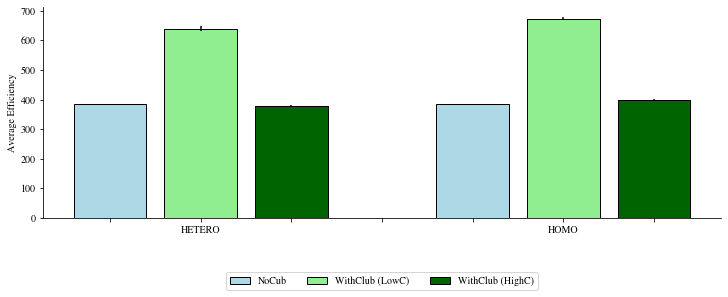

In [84]:
# Draw a graph to show the average efficiency without vs with opportunity 
# Re-group to compare the same type of subjects

# labels=  ['HETERO (H)', 'HETERO (L)','HOMO', '',
#           'HETERO (H)', 'HETERO (L)','HOMO', '',
#          'HETERO (H)', 'HETERO (L)','HOMO']

# labels = ['No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8', '',
#          'No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8', '',
#          'No Club Opportunity','Entry Cost = 2', 'Entry Cost = 8']

labels = ['NoCub','WithClub (LowC)', 'WithClub (HighC)','WithClub: Club Members Only'  ]

# labels2 =  ['', 'HETERO (H)','', '',
#           '', 'HETERO (L)','', '',
#          '', 'HOMO','']
labels2 =  ['', 'HETERO','', '',
         '', 'HOMO','']


colors = [ 'lightblue','lightgreen','darkgreen']
hatchs = ['', '.', 'xx']

x = np.arange(len(labels2))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))


for i in np.arange(3): 
#     toDraw = output
    axes.bar([i,i+4,i+8], output_all[[i*4,i*4+1,i*4+2],0], 
             yerr=[output_all[[i*4,i*4+1,i*4+2],0]-output_all[[i*4,i*4+1,i*4+2],1], output_all[[i*4,i*4+1,i*4+2],2]-output_all[[i*4,i*4+1,i*4+2],0]],
#              hatch=hatchs[i],
             label="All: " + labels[i], 
#             fill=False,
             color = colors[i],
             edgecolor = 'black'
            )    
# for i in np.arange(1,3): 
#     axes.bar([i,i+4,i+8], output_join[[i*4,i*4+1,i*4+2],0], 
#          yerr=[output_join[[i*4,i*4+1,i*4+2],0]-output_join[[i*4,i*4+1,i*4+2],1], output_join[[i*4,i*4+1,i*4+2],2]-output_join[[i*4,i*4+1,i*4+2],0]],
#              ecolor = 'red',
# #              hatch=hatchs[i],
#          label= labels[3], 
#             fill=False,
# #          color = colors,
#          edgecolor = 'red'
#         )    

axes.set_ylabel('Average Efficiency')
axes.set_xticks(x)
axes.set_xticklabels(labels2)
legend = axes.legend(labels, bbox_to_anchor=(.5,-.3), loc="center" , ncol=5)
# handles = legend.legendHandles
# for i, handle in enumerate(handles):
#     handle.set_edgecolor("black") 
#     handle.set_facecolor('white')
#     handle.set_hatch(hatchs[i])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
# axes[1].spines['top'].set_visible(False)
# axes[1].spines['right'].set_visible(False)
# axes[0].set_title('All Subjects')
# axes[1].set_title('Subjects who joined the club only')
# fig.savefig('..\\Output\\01-group-data-Dec-2022-Payoff.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

### All apps(others)

To see the trend over time

Return 
-[Both Environments](#Both-Environments)


In [ ]:
AllData = data_Oppor_allB.append(data_noOppor_AllA)
AllData['RoundNumber'] = AllData['subsession.round_number']
AllData.loc[AllData['Sequence']=='B1', 'RoundNumber'] += 10
AllData.loc[AllData['Sequence']=='A2', 'RoundNumber'] += 60
AllData.loc[AllData['Sequence']=='A2_bab', 'RoundNumber'] += 50
AllData.loc[AllData['Sequence']=='B2_bab', 'RoundNumber'] += 70
AllData['SeqOrder']  = 'ABA'
AllData.loc[( AllData['Sequence'].str.contains('bab')), 'SeqOrder'] = 'BAB'
AllData['RoundNumber_comparable'] = AllData['RoundNumber']
AllData.loc[AllData['SeqOrder']=='BAB','RoundNumber_comparable'] += 10
AllData['tot_contr_shares'] = AllData['tot_contr']/AllData['endowment']

In [ ]:
# AllData.columns
# AllData['tot_contr_shares'].unique()
AllData['RoundNumber_comparable'].sort_values().unique()

In [ ]:
# average should start from local group
var_of_interest =  'tot_contr'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].sum().reset_index()

ABA = AllDataGroupAverage[AllDataGroupAverage['SeqOrder']=='ABA']
# ABA
pd.pivot_table(ABA, index = 'RoundNumber', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,80), ylim=(0,80), title='Data (ABA): Total Contribution')

In [ ]:
BAB = AllDataGroupAverage[AllDataGroupAverage['SeqOrder']=='BAB']
pd.pivot_table(BAB, index = 'RoundNumber', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,80), ylim=(0,80), title='Data (BAB): Total Contribution')

In [ ]:
# average should start from local group
var_of_interest =  'tot_contr'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].sum().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,80), title='Data: Total Contribution')

In [ ]:
# average should start from local group
var_of_interest =  'tot_contr_shares'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].mean().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,1), title='Data: Total Contribution Shares')

In [ ]:
# average should start from local group
var_of_interest =  'player.payoff'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].mean().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,80), title='Data: Average Payoff')

In [ ]:
# average should start from local group
var_of_interest =  'player.contribution_local'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].sum().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,80), title='Data: Local Contribution')

In [ ]:
# average should start from local group
var_of_interest =  'player.contribution_global'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].sum().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,80), title='Data: Global Contribution')

In [ ]:
# average should start from local group
var_of_interest =  'player.join_club'

AllDataGroupAverage = AllData.groupby([ 
                      'Treatment', 'session.code','FC','RoundNumber_comparable','SeqOrder',
        'player.local_community',  
                      ])[var_of_interest].mean().reset_index()


pd.pivot_table(AllDataGroupAverage, index = 'RoundNumber_comparable', 
               columns=['Treatment', 'FC'], values=var_of_interest).plot(xlim=(0,90), ylim=(0,1), title='Data: % join')

In [ ]:
var_of_interest = 'player.contribution_global'
# var_of_interest = 'privateAcc'

LocalGlobal = pd.pivot_table(data_Oppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=np.nan)

LocalGlobal.groupby(['Treatment','FC']).mean()  # when the FC is small and hetero, the contribution is relatively stable;
    # when the FC is small and homo, the contribution decrease;
    # when FC is large, both hetero and homo decreases (but hetero move to local? homo doesn't? )
    
    # Need to calculate confidence interval!! group as individual unit, may have very large confidence interval!!!)
    # If interval is too big, need to use the simulation result to help make predictions!!!!

In [ ]:
# Group Level data
Group_NoOpp = data_noOppor.groupby(['player.local_community', 'Sequence',
                                    'session.code', 'Treatment','FC',
                                    'subsession.round_number', 
                                    'subsession.period'])['player.contribution_local',
                                                          'endowment', 'tot_contr',
                                                          'privateAcc',
                                                         'player.payoff',
                                                          'player.join_club',
                                                        ].sum().reset_index()


Group_Opp = data_Oppor.groupby(['player.local_community', 'Sequence',
                                    'session.code', 'Treatment', 'FC',
                                    'subsession.round_number','subsession.round_number_o',
                                    'subsession.period'])['player.contribution_local',
                                                          'player.contribution_global',
                                                          'endowment', 'tot_contr',
                                                          'privateAcc',
                                                         'player.payoff',
                                                         'player.join_club'].sum().reset_index()


# data_Oppor.
# Group_NoOpp


In [ ]:
Group_Opp.groupby(['Treatment','FC'])['player.payoff'].agg(['mean']).reset_index()

In [ ]:
Group_NoOpp.groupby(['Treatment','FC'])['player.payoff'].agg(['mean']).reset_index()

In [ ]:
# Draw a graph to show the total contribution without vs with opportunity 

Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr',
                                                                    'player.contribution_global',
                                                                   'player.payoff', 'player.join_club'].mean().reset_index()
# Contribution_Combined =pd.pivot_table(Group_Opp, values=['player.contribution_local','player.contribution_global'], 
#               index=['Treatment'],columns=['group.FC'] ).reset_index()
temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr', 'player.payoff', 'player.join_club'].mean().reset_index()
Contribution_Combined = Contribution_Combined.merge(temp, on=['Treatment','FC'])

Contribution_Combined_std = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local',
                                                                    'player.contribution_global','tot_contr',].std().reset_index()
temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local', 'tot_contr'].std().reset_index()
Contribution_Combined_std = Contribution_Combined_std.merge(temp, on=['Treatment','FC'])

# Try s.e.
Contribution_Combined_std['player.contribution_local_x']=Contribution_Combined_std['player.contribution_local_x']/np.sqrt(80)
Contribution_Combined_std['player.contribution_local_y']=Contribution_Combined_std['player.contribution_local_y']/np.sqrt(20)
Contribution_Combined_std['player.contribution_global']=Contribution_Combined_std['player.contribution_global']/np.sqrt(80)

In [ ]:
Contribution_Combined_CI9 = copy.deepcopy(Contribution_Combined)

for t in Contribution_Combined.Treatment.unique():
    for fc in Contribution_Combined['FC'].unique():
        data = Group_NoOpp[(Group_NoOpp['Treatment']==t) & (Group_NoOpp['FC']==fc)]
        x = bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0] 

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                      'player.contribution_local_y'] -= x

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                      'player.payoff_y'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
        
        data = Group_Opp[(Group_Opp['Treatment']==t) & (Group_Opp['FC']==fc)]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc),
                                      'player.contribution_local_x'] -= bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) 
                                      & (Contribution_Combined_CI9['FC']==fc), 
                                      'player.contribution_global'] -= bootstrap_ci(np.array(data['player.contribution_global']), 10000, np.mean)[0]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc), 
                                  'player.payoff_x'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc), 
                                   'player.join_club_x'] -= bootstrap_ci(np.array(data['player.join_club']), 10000, np.mean)[0] 
    
    

In [ ]:
labels=  ['HETERO', 'HOMO', '','HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.bar(Contribution_Combined.Treatment, Contribution_Combined['player.contribution_local_y'], 
         label="Group Account", 
         yerr=Contribution_Combined_CI9['player.contribution_local_y'], 
#          yerr=Contribution_Combined_std['player.contribution_local_y'],
         color='lightblue')

axes.bar(Contribution_Combined.index+3, Contribution_Combined['player.contribution_local_x'],
#          label="Group Account",
         yerr=Contribution_Combined_CI9['player.contribution_local_x'],
#          yerr=Contribution_Combined_std['player.contribution_local_x'],
         color='lightblue')
# Stacked bars
axes.bar(Contribution_Combined.index+3,
         Contribution_Combined['player.contribution_global'], label="Group Account #2", 
         bottom=Contribution_Combined['player.contribution_local_x'],
#         yerr=Contribution_Combined_std['player.contribution_global'],
         yerr=Contribution_Combined_CI9['player.contribution_global'],
         color='lightgreen')

axes.set_xticks(labels)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-Contribution.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [ ]:
# Draw a graph to show the total contribution without vs with opportunity 
def ContributionGraph(Group_Opp, Group_NoOpp):
    Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr',
                                                                        'player.contribution_global',
                                                                       'player.payoff', 'player.join_club'].mean().reset_index()
    # Contribution_Combined =pd.pivot_table(Group_Opp, values=['player.contribution_local','player.contribution_global'], 
    #               index=['Treatment'],columns=['group.FC'] ).reset_index()
    temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr', 'player.payoff', 'player.join_club'].mean().reset_index()
    Contribution_Combined = Contribution_Combined.merge(temp, on=['Treatment','FC'])

    Contribution_Combined_std = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local',
                                                                        'player.contribution_global','tot_contr',].std().reset_index()
    temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local', 'tot_contr'].std().reset_index()
    Contribution_Combined_std = Contribution_Combined_std.merge(temp, on=['Treatment','FC'])

    # Try s.e.
    Contribution_Combined_std['player.contribution_local_x']=Contribution_Combined_std['player.contribution_local_x']/np.sqrt(80)
    Contribution_Combined_std['player.contribution_local_y']=Contribution_Combined_std['player.contribution_local_y']/np.sqrt(20)
    Contribution_Combined_std['player.contribution_global']=Contribution_Combined_std['player.contribution_global']/np.sqrt(80)
    Contribution_Combined_CI9 = copy.deepcopy(Contribution_Combined)

    for t in Contribution_Combined.Treatment.unique():
        for fc in Contribution_Combined['FC'].unique():
            data = Group_NoOpp[(Group_NoOpp['Treatment']==t) & (Group_NoOpp['FC']==fc)]
            x = bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0] 

            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                          'player.contribution_local_y'] -= x

            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                          'player.payoff_y'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 

            data = Group_Opp[(Group_Opp['Treatment']==t) & (Group_Opp['FC']==fc)]
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                          (Contribution_Combined_CI9['FC']==fc),
                                          'player.contribution_local_x'] -= bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0]
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) 
                                          & (Contribution_Combined_CI9['FC']==fc), 
                                          'player.contribution_global'] -= bootstrap_ci(np.array(data['player.contribution_global']), 10000, np.mean)[0]
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                          (Contribution_Combined_CI9['FC']==fc), 
                                      'player.payoff_x'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                          (Contribution_Combined_CI9['FC']==fc), 
                                       'player.join_club_x'] -= bootstrap_ci(np.array(data['player.join_club']), 10000, np.mean)[0] 

    labels=  ['HETERO', 'HOMO', '','HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
    x = np.arange(len(labels))
    fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

    axes.bar(Contribution_Combined.Treatment, Contribution_Combined['player.contribution_local_y'], 
             label="Group Account", 
             yerr=Contribution_Combined_CI9['player.contribution_local_y'], 
    #          yerr=Contribution_Combined_std['player.contribution_local_y'],
             color='lightblue')

    axes.bar(Contribution_Combined.index+3, Contribution_Combined['player.contribution_local_x'],
    #          label="Group Account",
             yerr=Contribution_Combined_CI9['player.contribution_local_x'],
    #          yerr=Contribution_Combined_std['player.contribution_local_x'],
             color='lightblue')
    # Stacked bars
    axes.bar(Contribution_Combined.index+3,
             Contribution_Combined['player.contribution_global'], label="Group Account #2", 
             bottom=Contribution_Combined['player.contribution_local_x'],
    #         yerr=Contribution_Combined_std['player.contribution_global'],
             yerr=Contribution_Combined_CI9['player.contribution_global'],
             color='lightgreen')

    axes.set_xticks(labels)
    axes.legend()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    # fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-Contribution.pdf'  , bbox_inches="tight")  
    # fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [ ]:
ContributionGraph(Group_Opp[Group_Opp['subsession.period']<=10], Group_NoOpp[Group_NoOpp['subsession.period']<=10] )

In [ ]:
# Draw a graph to show the average player payoff without vs with opportunity 


labels=  ['HETERO (L)', 'HETERO (H)','HOMO (L)', 'HOMO (H)', '', 'HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.bar(Contribution_Combined.index, Contribution_Combined['player.payoff_y'], 
         label="Average Group Payoff (No Global)", 
#          yerr=Contribution_Combined_CI9['player.payoff_y'], 
         yerr=Contribution_Combined_std['player.contribution_local_y'],
#          color='lightblue'
        )

axes.bar(Contribution_Combined.index+5, Contribution_Combined['player.payoff_x'],
         label="Average Group Payoff (With Global)", 
#          yerr=Contribution_Combined_CI9['player.payoff_x'],
         yerr=Contribution_Combined_std['player.contribution_local_x'],
#          color='lightblue'
        )

# axes.axhline(y=80, linestyle='dashed')

axes.set_xticks(x)
axes.set_xticklabels(labels)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-Payoff.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [ ]:
# Draw a graph to show the number of players who join the club with opportunity 


labels=  ['HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.bar(list(Contribution_Combined.index), Contribution_Combined['player.join_club_x'],
#          label="Group Account",
         yerr=Contribution_Combined_CI9['player.join_club_x'],
#          yerr=Contribution_Combined_std['player.contribution_local_x'],
         color='lightgreen')

axes.set_xticks(ticks=list(Contribution_Combined.index))
axes.set_xticklabels(labels)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-NumJoinClubInEachGroup.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

## Group Level data, inequality

In [ ]:
# Group Level data
Group_NoOpp = data_noOppor.groupby(['player.local_community', 
                                    'session.code', 'Treatment','FC',
                                    'subsession.round_number',
                                    'subsession.period'])['endowment',
                                                         'player.payoff',
                                                        ].std().reset_index()


Group_Opp = data_Oppor.groupby(['player.local_community', 
                                    'session.code', 'Treatment', 'FC',
                                    'subsession.round_number', 'subsession.round_number_o',
                                    'subsession.period'])['endowment','player.payoff'].std().reset_index()


Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['endowment','player.payoff'].mean().reset_index()
# Contribution_Combined =pd.pivot_table(Group_Opp, values=['player.contribution_local','player.contribution_global'], 
#               index=['Treatment'],columns=['group.FC'] ).reset_index()
temp = Group_NoOpp.groupby(['Treatment','FC'])['endowment','player.payoff'].mean().reset_index()
Contribution_Combined = Contribution_Combined.merge(temp, on=['Treatment','FC'])

# Calculate confidence intervals
Contribution_Combined_CI9 = copy.deepcopy(Contribution_Combined)

for t in Contribution_Combined.Treatment.unique():
    for fc in Contribution_Combined['FC'].unique():
        data = Group_NoOpp[(Group_NoOpp['Treatment']==t) & (Group_Opp['FC']==fc)]

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) & (Group_Opp['FC']==fc), 
                                      'endowment_y'] -= bootstrap_ci(np.array(data['endowment']), 10000, np.mean)[0] 

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) & (Group_Opp['FC']==fc), 
                                      'player.payoff_y'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 


    
        
     
        
        data = Group_Opp[(Group_Opp['Treatment']==t) & (Group_Opp['FC']==fc)]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc),
                                      'endowment_x'] -= bootstrap_ci(np.array(data['endowment']), 10000, np.mean)[0]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc), 
                                  'player.payoff_x'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
    
    


# Draw a graph to show the average player payoff without vs with opportunity 


labels=  ['HETERO', 'HOMO', '','HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.scatter(Contribution_Combined.Treatment, Contribution_Combined['endowment_y'], 
         label="Within-Group Endowment Standard Deviation", 
         color='red',zorder=1)
axes.bar(Contribution_Combined.Treatment, Contribution_Combined['player.payoff_y'], 
         label="Within-Group Payoff Standard Deviation", 
         yerr=Contribution_Combined_CI9['player.payoff_y'], 
         color='lightblue',zorder=-1)


axes.scatter(Contribution_Combined.index+3, Contribution_Combined['endowment_x'], 
         color='red',zorder=1)
axes.bar(Contribution_Combined.index+3, Contribution_Combined['player.payoff_x'],
#          label="Group Account",
         yerr=Contribution_Combined_CI9['player.payoff_x'],
         color='lightblue',zorder=-1)

# axes.axhline(y=80, linestyle='dashed')
axes.set_ylim(-0.1,15)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_xticks(labels)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-PayoffVariance.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [ ]:
# Private Account 
var_of_interest = 'privateAcc'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community',  'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()
# LocalOnly = group.groupby(['Treatment']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')


axes.set_title(str(var_of_interest))
axes.set_xlim(1,10)
axes.set_ylim(0,80)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-PrivateAccTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
# Total Contribution
var_of_interest = 'tot_contr'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()
# LocalOnly = group.groupby(['Treatment']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
# axes.set_xlim(1,10)
axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)

# fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-LocalContributionTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
# Local Group Account 
var_of_interest = 'player.contribution_local'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
# axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)

# fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-LocalContributionTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
# Global Group Account 
var_of_interest = 'player.contribution_global'

data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()

axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
# axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

# fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-GlobalContributionTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
LocalOnly

In [ ]:
LocalWith

In [ ]:
# Payoff 
var_of_interest = 'player.payoff'
# var_of_interest = 'player.join_club'


LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-PayoffTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
# Payoff 
# var_of_interest = 'player.payoff'
var_of_interest = 'player.join_club'


LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()

axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-JoinClubTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
pd.pivot_table(data_Oppor, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'],
#                            columns=['subsession.period'],
                           aggfunc=np.mean, fill_value=np.nan)

In [ ]:
var_of_interest =  'player.join_club'
# var_of_interest = 'player.contribution_global'
# var_of_interest = 'player.contribution_local' 
# var_of_interest = 'privateAcc'

LocalGlobal = pd.pivot_table(data_Oppor, values=var_of_interest, 
                    index=['group.id_in_subsession',  'session.code', 'Treatment','subsession.sg', 'FC' ],
                    columns=['subsession.period'], aggfunc=np.mean)


In [ ]:
SuperGames = LocalGlobal.groupby(['Treatment','FC']).mean()
SuperGames
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# # fig.plot()
axes.plot(SuperGames.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(SuperGames.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(SuperGames.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(SuperGames.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')
axes.set_title(str(var_of_interest))
axes.set_xlim(1,20)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll3Matches-JoinClubTimeTrend.pdf'  , bbox_inches="tight")  

In [ ]:
SuperGames = LocalGlobal.groupby(['Treatment','FC','subsession.sg']).mean()
SuperGames
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
for i in range(1,4):
    axes.plot(SuperGames.T['HOMO'][20][i], label='HOMO (L) '+str(i), c='blue', alpha=0.05*(10-2*i))
#     axes.plot(SuperGames.T['HETERO'][20][i], label='HETERO (L) '+str(i), c='orange',alpha=0.05*(10-2*i))
    axes.plot(SuperGames.T['HOMO'][80][i], label='HOMO (H) '+str(i), c='green', alpha=0.05*(10-2*i))
#     axes.plot(SuperGames.T['HETERO'][80][i], label='HETERO (H) '+str(i), c='red', alpha=0.05*(10-2*i))
axes.set_title(str(var_of_interest))
axes.legend()

In [ ]:
col_WOpp = 'PGSO_08_WithClubOppVariedCost_Part3'
col_names = [col_WOpp+'.'+str(1)+'.'+ x for x in variables]
col_rename = {}
for x in variables:
    col_rename[col_WOpp+'.'+str(1)+'.'+ x ] =  x
temp = data[col_names]
temp = temp.rename(columns=col_rename) 
data_WOppor = temp
# data_noOppor = []
for i in range(2,11):
    col_names = [col_WOpp+'.'+str(i)+'.'+ x for x in variables]
    col_rename = {}
    for x in variables:
        col_rename[col_WOpp+'.'+str(i)+'.'+ x ] =  x
    temp = data[col_names]
    temp = temp.rename(columns=col_rename) 
    data_WOppor = data_WOppor.append(temp, ignore_index=True)
    
LocalGlobal_l = pd.pivot_table(data_WOppor, values='player.contribution_local', index=['player.local_community'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0)
LocalGlobal_l

In [ ]:
LocalGlobal_gF = pd.pivot_table(data_WOppor, values=[
                                            'player.join_club',
                                                     'player.contribution_local', 
                                                     'player.contribution_global'],
                                index=['subsession.round_number'],
                    columns=['player.local_community','group.id_in_subsession', 'group.FC' ], aggfunc=np.sum, fill_value=0)
LocalGlobal_gF

In [ ]:
LocalGlobal_gF2 = pd.pivot_table(data_WOppor, values=[
                                            'group.total_contribution_global'],
                                index=['subsession.round_number'],
                    columns=['player.local_community','group.id_in_subsession', 'group.FC' ], aggfunc=np.mean, fill_value=0)
LocalGlobal_gF2

In [ ]:
condition = (data_WOppor['subsession.round_number'] == 2 )  & (data_WOppor['group.id_in_subsession'] == 2 )
data_WOppor[condition]

# Check page time



In [ ]:
# Some useful code in the past

In [ ]:
sessions = {
            'all_apps_wide_2022-11-04.csv':['pilot_1',125,'DynamicPower_05_Experiment.','T6 END',4], 
        
    
    
           }

rows = {}

nRows = 0
for i,s in enumerate(sessions):
    print("------------")
    print(s)
    data=pd.read_csv('..\\RawData\\'+s)
    sessions[s].append(nRows)
    nRows += data.shape[0]
    sessions[s].append(nRows)
    if not sessions[s][3] in rows:
        rows[sessions[s][3]]=np.arange(sessions[s][5],sessions[s][6])
    else:
        rows[sessions[s][3]]=np.concatenate([rows[sessions[s][3]],np.arange(sessions[s][5],sessions[s][6])])

sessions

#session dictionary
#session file : [sequence, experiment label within file, start row, end row + 1]

In [ ]:
rows

In [ ]:
columns = [ '.group.matchNumber','.group.roundNumber','.group.id_in_subsession','.player.id_in_group',
            '.player.myChoice','.player.myPayoff','.player.roundPayoff','.player.myPower',
              '.player.myBelief_firstX', '.player.myBelief_secondX', '.player.myBelief_thirdX',
          '.player.myPNorm_X', '.player.myPNorm_Y', '.player.mySNorm_X', '.player.mySNorm_Y',
          '.player.myEffort',
          '.group.total_contribution', 
          '.player.calculatorHistory3', '.player.calculatorHistory4','.player.calculatorHistory5','.player.calculatorHistory6','.player.calculatorHistory8'
          ]

additional_columns = ['participant.code','session.code','treatment', 'session']

ncols = 272

out = {}
for col in additional_columns+columns:
    out[col]=np.empty((nRows,ncols))
    out[col][:]=np.nan

In [ ]:
# for j,part_name in enumerate(['part2_play.','part3_play.']):

j=0
for i,s in enumerate(sessions):
    
    print(s)
    data=pd.read_csv('..\\RawData\\'+s)
    start_row = sessions[s][5]
    end_row = sessions[s][6]
    part_name = sessions[s][2]
    ncols = sessions[s][1]

    for col in columns:
        #part2 group qualification
        if i==0 and col=='.player.roundPayoff':
            pass
        else:
            colnames = [part_name+str(x)+col for x in range(1,ncols+1)]
            temp=data[colnames].to_numpy()
            if type(temp[0][0])==str:
                out[col]=out[col].astype(str)
            out[col][start_row:end_row,0:ncols]=temp

    #sessionID
    colnames = ['session.code' for x in range(1,ncols+1)]
    temp=data[colnames].to_numpy()
    if type(temp[0][0])==str:
        out['session.code']=out['session.code'].astype(str)
    out['session.code'][start_row:end_row,0:ncols]=temp
    
    #subjectID
    colnames = ['participant.code' for x in range(1,ncols+1)]
    temp=data[colnames].to_numpy()
    if type(temp[0][0])==str:
        out['participant.code']=out['participant.code'].astype(str)
    out['participant.code'][start_row:end_row,0:ncols]=temp
    
    #treatment
    temp=sessions[s][3]
    if type(temp)==str:
        out['treatment']=out['treatment'].astype(str)
    out['treatment'][start_row:end_row,0:ncols]=temp
    
    #session name 
    temp = sessions[s][0]
    if type(temp)==str:
        out['session']=out['session'].astype(str)
    out['session'][start_row:end_row,0:ncols]=temp

In [ ]:
for col in out:
    out[col]=out[col].flatten()

In [ ]:
out_data = pd.DataFrame(out)
# Drop when myChoice==-1
out_data = out_data[out_data['.player.myChoice']!=-1]
# Drop nan
out_data = out_data[~out_data['.group.matchNumber'].isnull()]
# Drop first session, match7-10
out_data = out_data.drop(out_data[ (out_data['session']=='pilot_1' ) & (out_data['.group.matchNumber'] >= 7 )].index)

# Added on May 22nd: 
#Drop 10 observations where the group contribution is not recorded correctly (end of crashed program, problematic)
out_data['group_total_contribution_check'] = out_data.groupby(['session.code', '.group.id_in_subsession', '.group.matchNumber', '.group.roundNumber',])['.player.myChoice'].transform('sum')

out_data = out_data.drop(out_data[out_data['group_total_contribution_check']!=out_data['.group.total_contribution']].index)
out_data.to_csv("01-clean-data-may-2022.csv",index=False)

In [ ]:
# len(out_data['participant.code'].unique())
len(out_data['session.code'].unique())

In [ ]:
len(out_data['session'].unique())

In [ ]:
out_data['session'].unique()